In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [2]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [3]:
def basic_som(data, err, info_data, dim, preproc, distance, data_type, iteration = 1, sigma = 1, rate = 1, b_scale = 1.042, save = False, save_record = True):
    lupmag = -np.arcsinh(data / 10 ** 3 /  (2 * b_scale * err / 10 ** 3))
    color = -np.diff(lupmag, axis = -1)
    proc_data = (color- np.mean(color, axis=0)) / np.std(color, ddof = 1, axis=0)
    print(f"Data shape: {proc_data.shape}")

    som = MiniSom(dim, dim, proc_data.shape[1], sigma = sigma, learning_rate = rate, activation_distance = distance)
    som.random_weights_init(proc_data)
    som.train(proc_data, np.zeros_like(proc_data), num_iteration = iteration, use_epochs = True)

    print("Finish traininging SOM.")
    print("Start making diagrams...")

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    
    labels_map_1 = som.labels_map(proc_data, np.zeros_like(proc_data), [0] * len(proc_data))
    labels_map_2 = som.labels_map(proc_data, np.zeros_like(proc_data), tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))

    for i in labels_map_1.keys():
        density_map[int(list(i)[0]), int(list(i)[1])] = labels_map_1[i][0]

    print("Finish collecting data for density map.")
    
    for i in labels_map_2.keys():
        properties = np.mean(np.array(list(labels_map_2[i].keys())), axis = 0)
        magnitude_map[int(list(i)[0]), int(list(i)[1])] = properties[0]
        z_map[int(list(i)[0]), int(list(i)[1])] = properties[1]

    print("Finish collecting data for magnitude map.")
    print([dim, sigma, rate])
    print(f"Topological error: {som.topographic_error(proc_data)}")
    print(f"Quantization error: {som.quantization_error(proc_data)}")
    print(np.sum(density_map))

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (25, 25))
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn') 
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar()
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("HSC I Magnitude Map")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="plasma")
    plt.colorbar()
    plt.title("True Redshift Map")
    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/3rd_exploration/diagram/{data_type}_{len(proc_data[0])}_{dim}_{sigma}_{rate}_{iteration}_{b_scale}.jpg", bbox_inches = "tight")
    
    plt.show()
    if save_record:
        if os.path.isfile("D:/SPHEREx_SOM/record/3rd_exploration/record2.pkl"):
            with open("D:/SPHEREx_SOM/record/3rd_exploration/record2.pkl", "rb") as fh:
                record = pickle.load(fh)
        else:
            record = []
    
        map_record = {}
        map_record["dim"] = dim
        map_record["sigma"] = sigma
        map_record["rate"] = rate
        map_record["band_cut"] = len(proc_data[0])
        map_record["mag_cut"] = len(proc_data)
        map_record["preproc"] = preproc
        map_record["som"] = som
        map_record["topo_err"] = som.topographic_error(proc_data)
        map_record["quan_err"] = som.quantization_error(proc_data)
        map_record["density"] = density_map
        map_record["magnitude"] = magnitude_map
        map_record["z"] = z_map
        map_record["type"] = data_type
        map_record["distance"] = distance
        map_record["iter"] = iteration
        map_record["b_scale"] = b_scale
        
        record.append(map_record)
        
        try:
            with open("D:/SPHEREx_SOM/record/3rd_exploration/record2.pkl", 'wb') as fh:
                pickle.dump(record, fh, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    
    return som

In [4]:
data = pd.DataFrame(data_all[:, 0::2]).dropna().to_numpy()
info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
err = data_all[0, 1::2]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_46116\836707857.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]


In [ ]:
for i in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 10 ** 5, 10 ** 6, 10 ** 7, 10 ** 8, 10 ** 9, 10 ** 10]:
    som = basic_som(data = data, data_type = "noisy_lupcolor_deep", err = err, info_data = info, dim = 30, preproc = "default", iteration = 2, sigma = 0.6, rate = 0.2, b_scale  = i, save = True, distance = "euclidean")

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 0.1]
Topological error: 0.6765151770373614
Quantization error: 8.77115522559113
29683.0


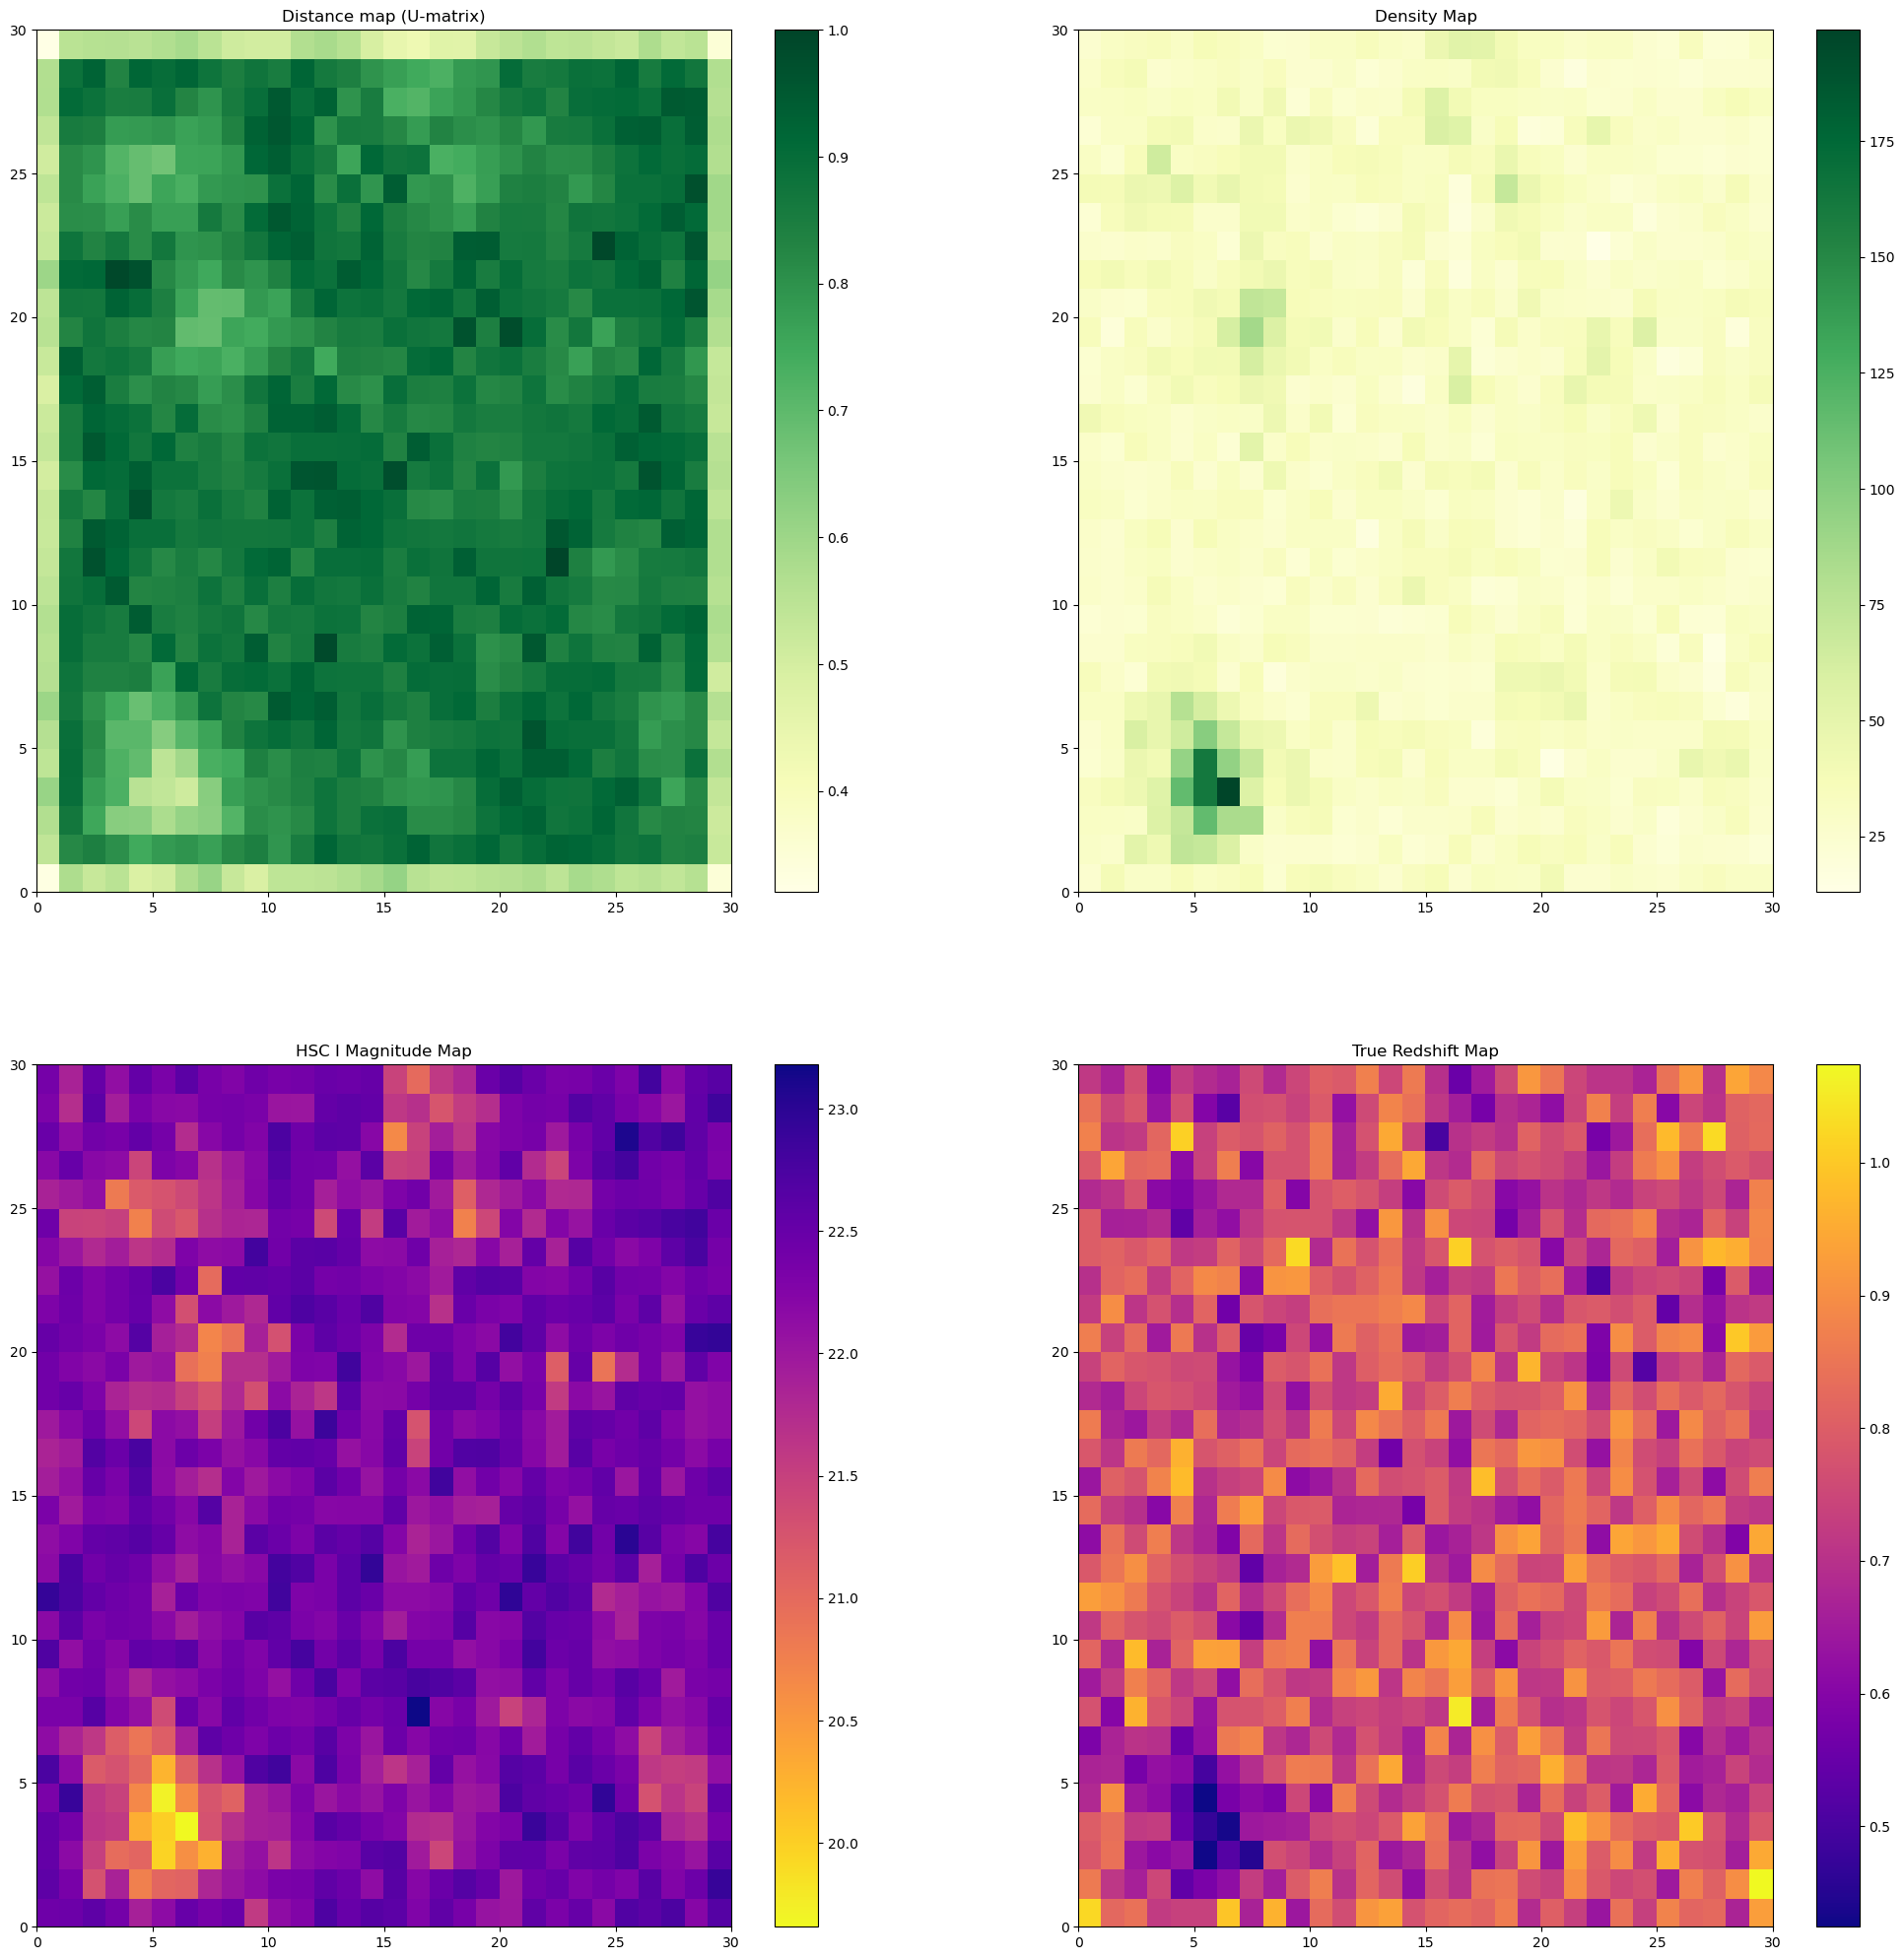

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 0.2]
Topological error: 0.855304382980157
Quantization error: 8.789149116961067
29683.0


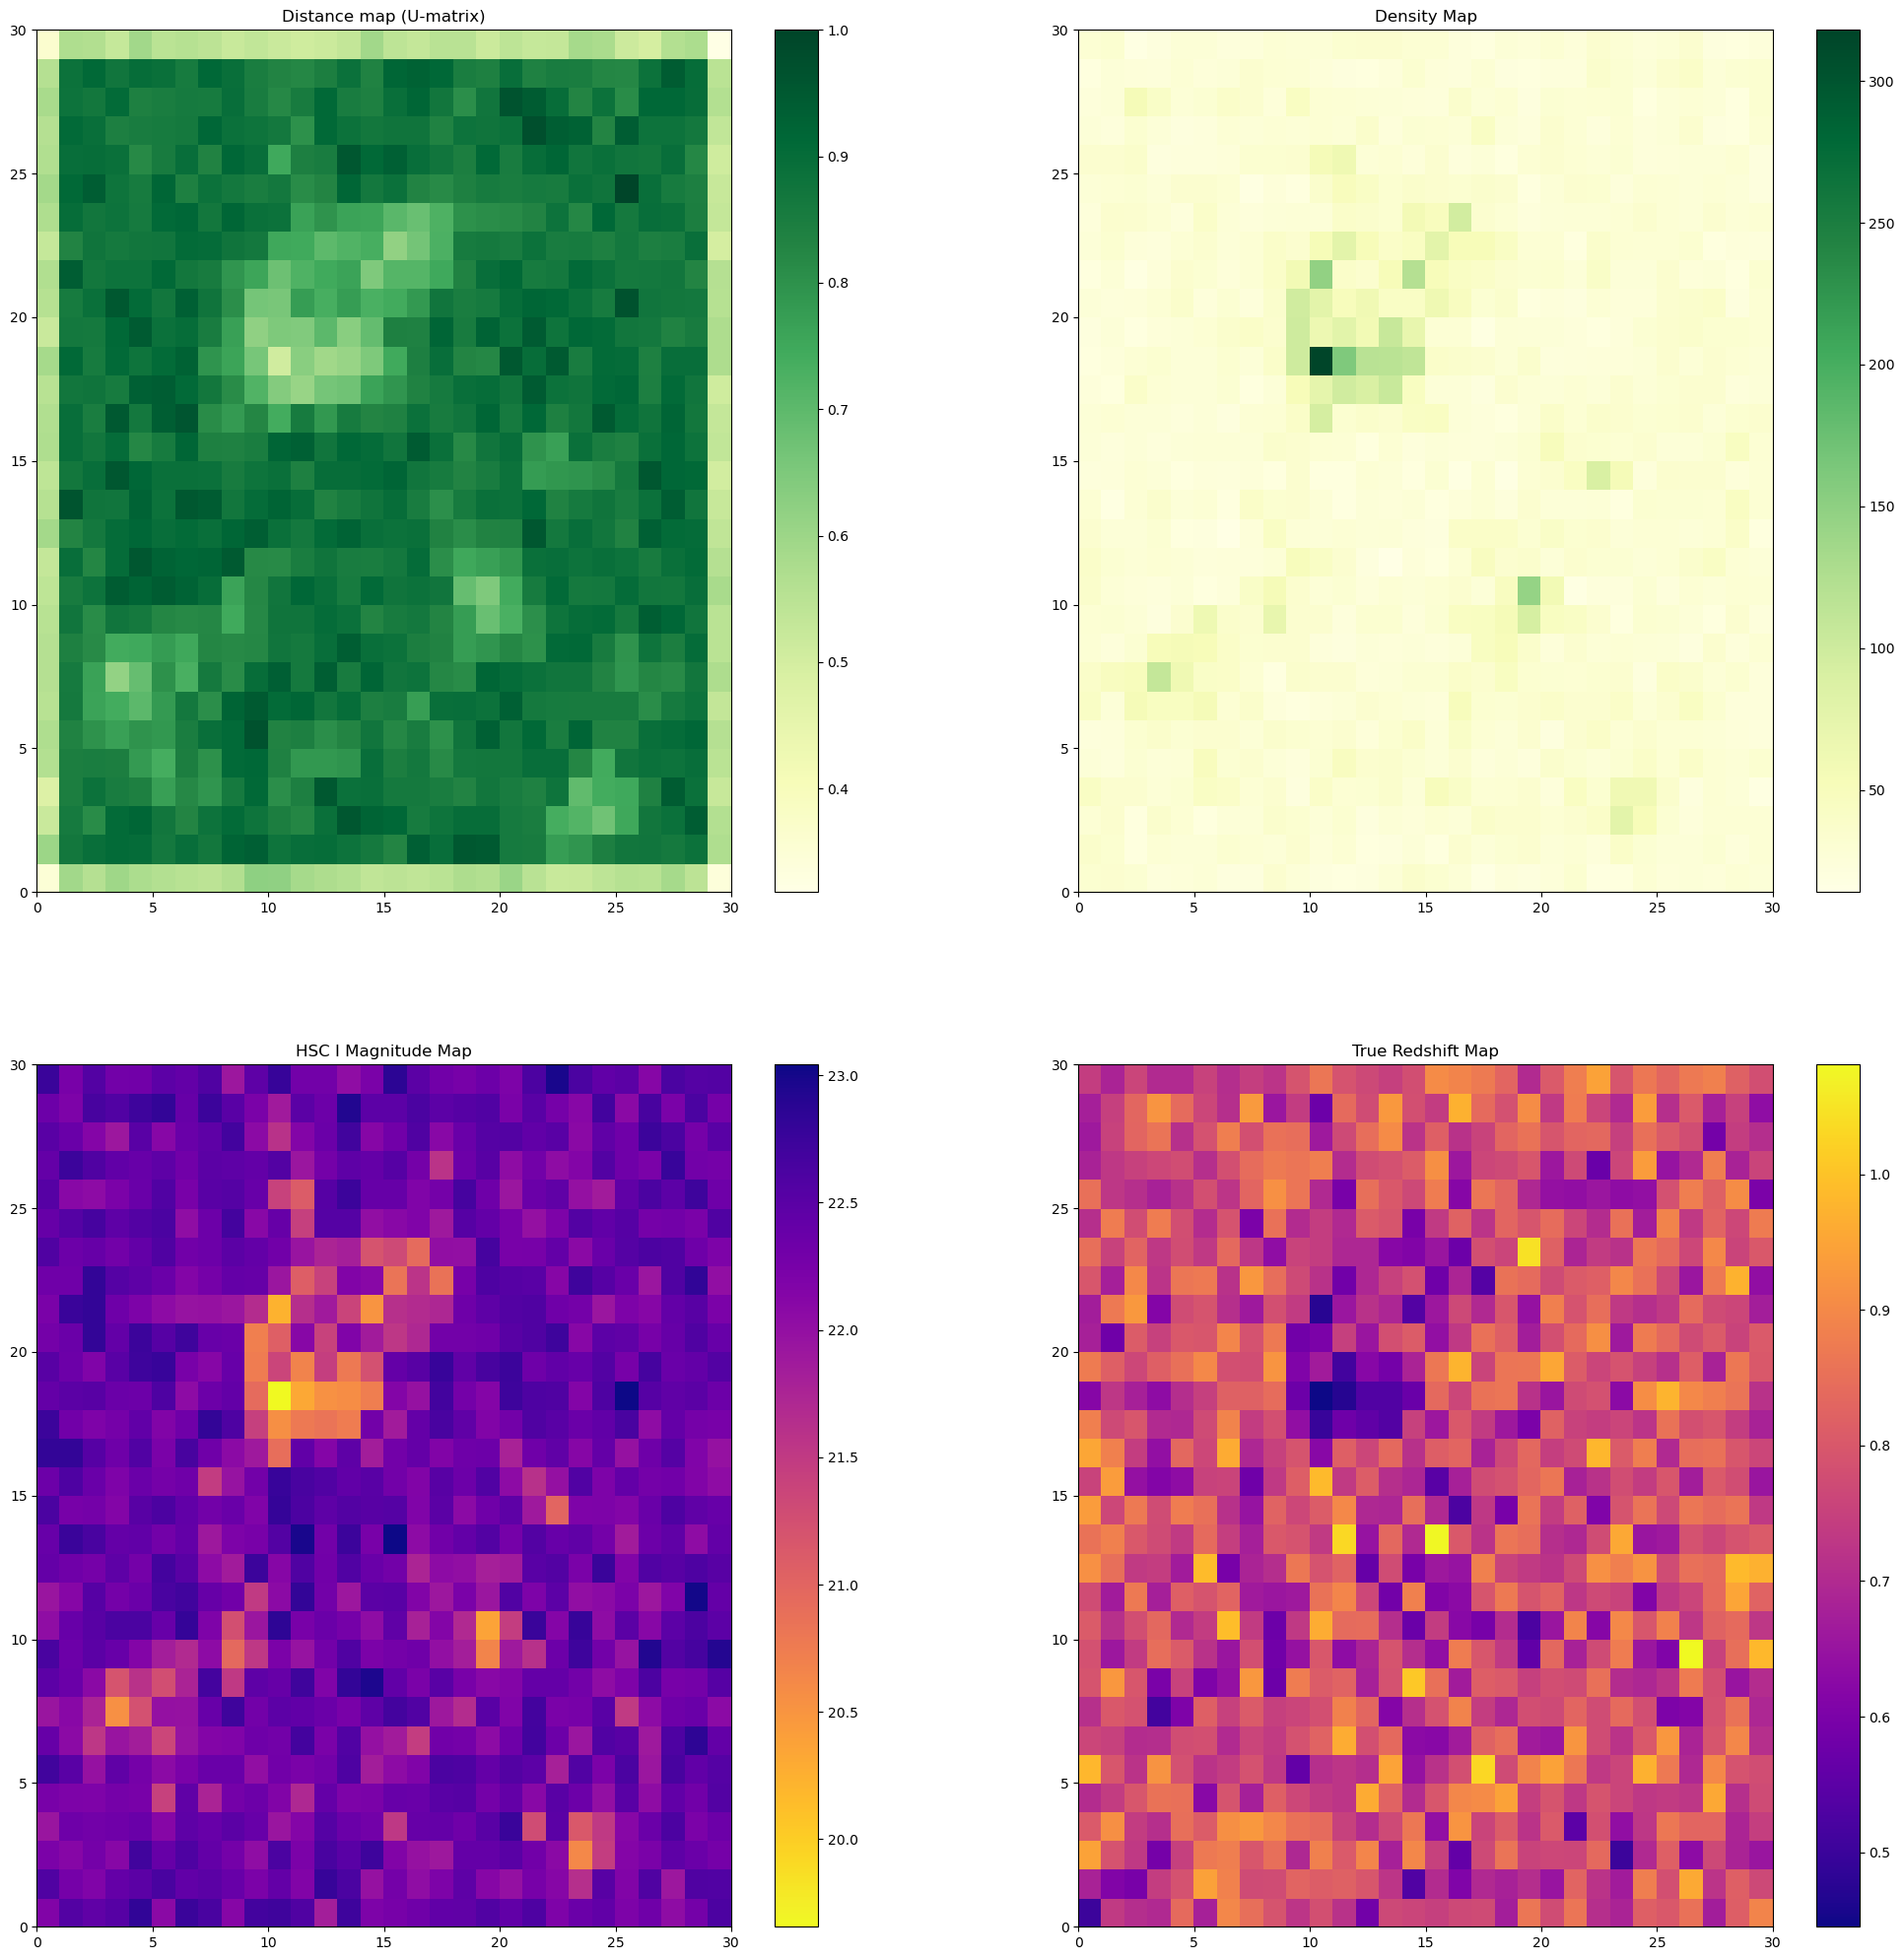

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 0.3]
Topological error: 0.9197857359431324
Quantization error: 8.855694797590523
29683.0


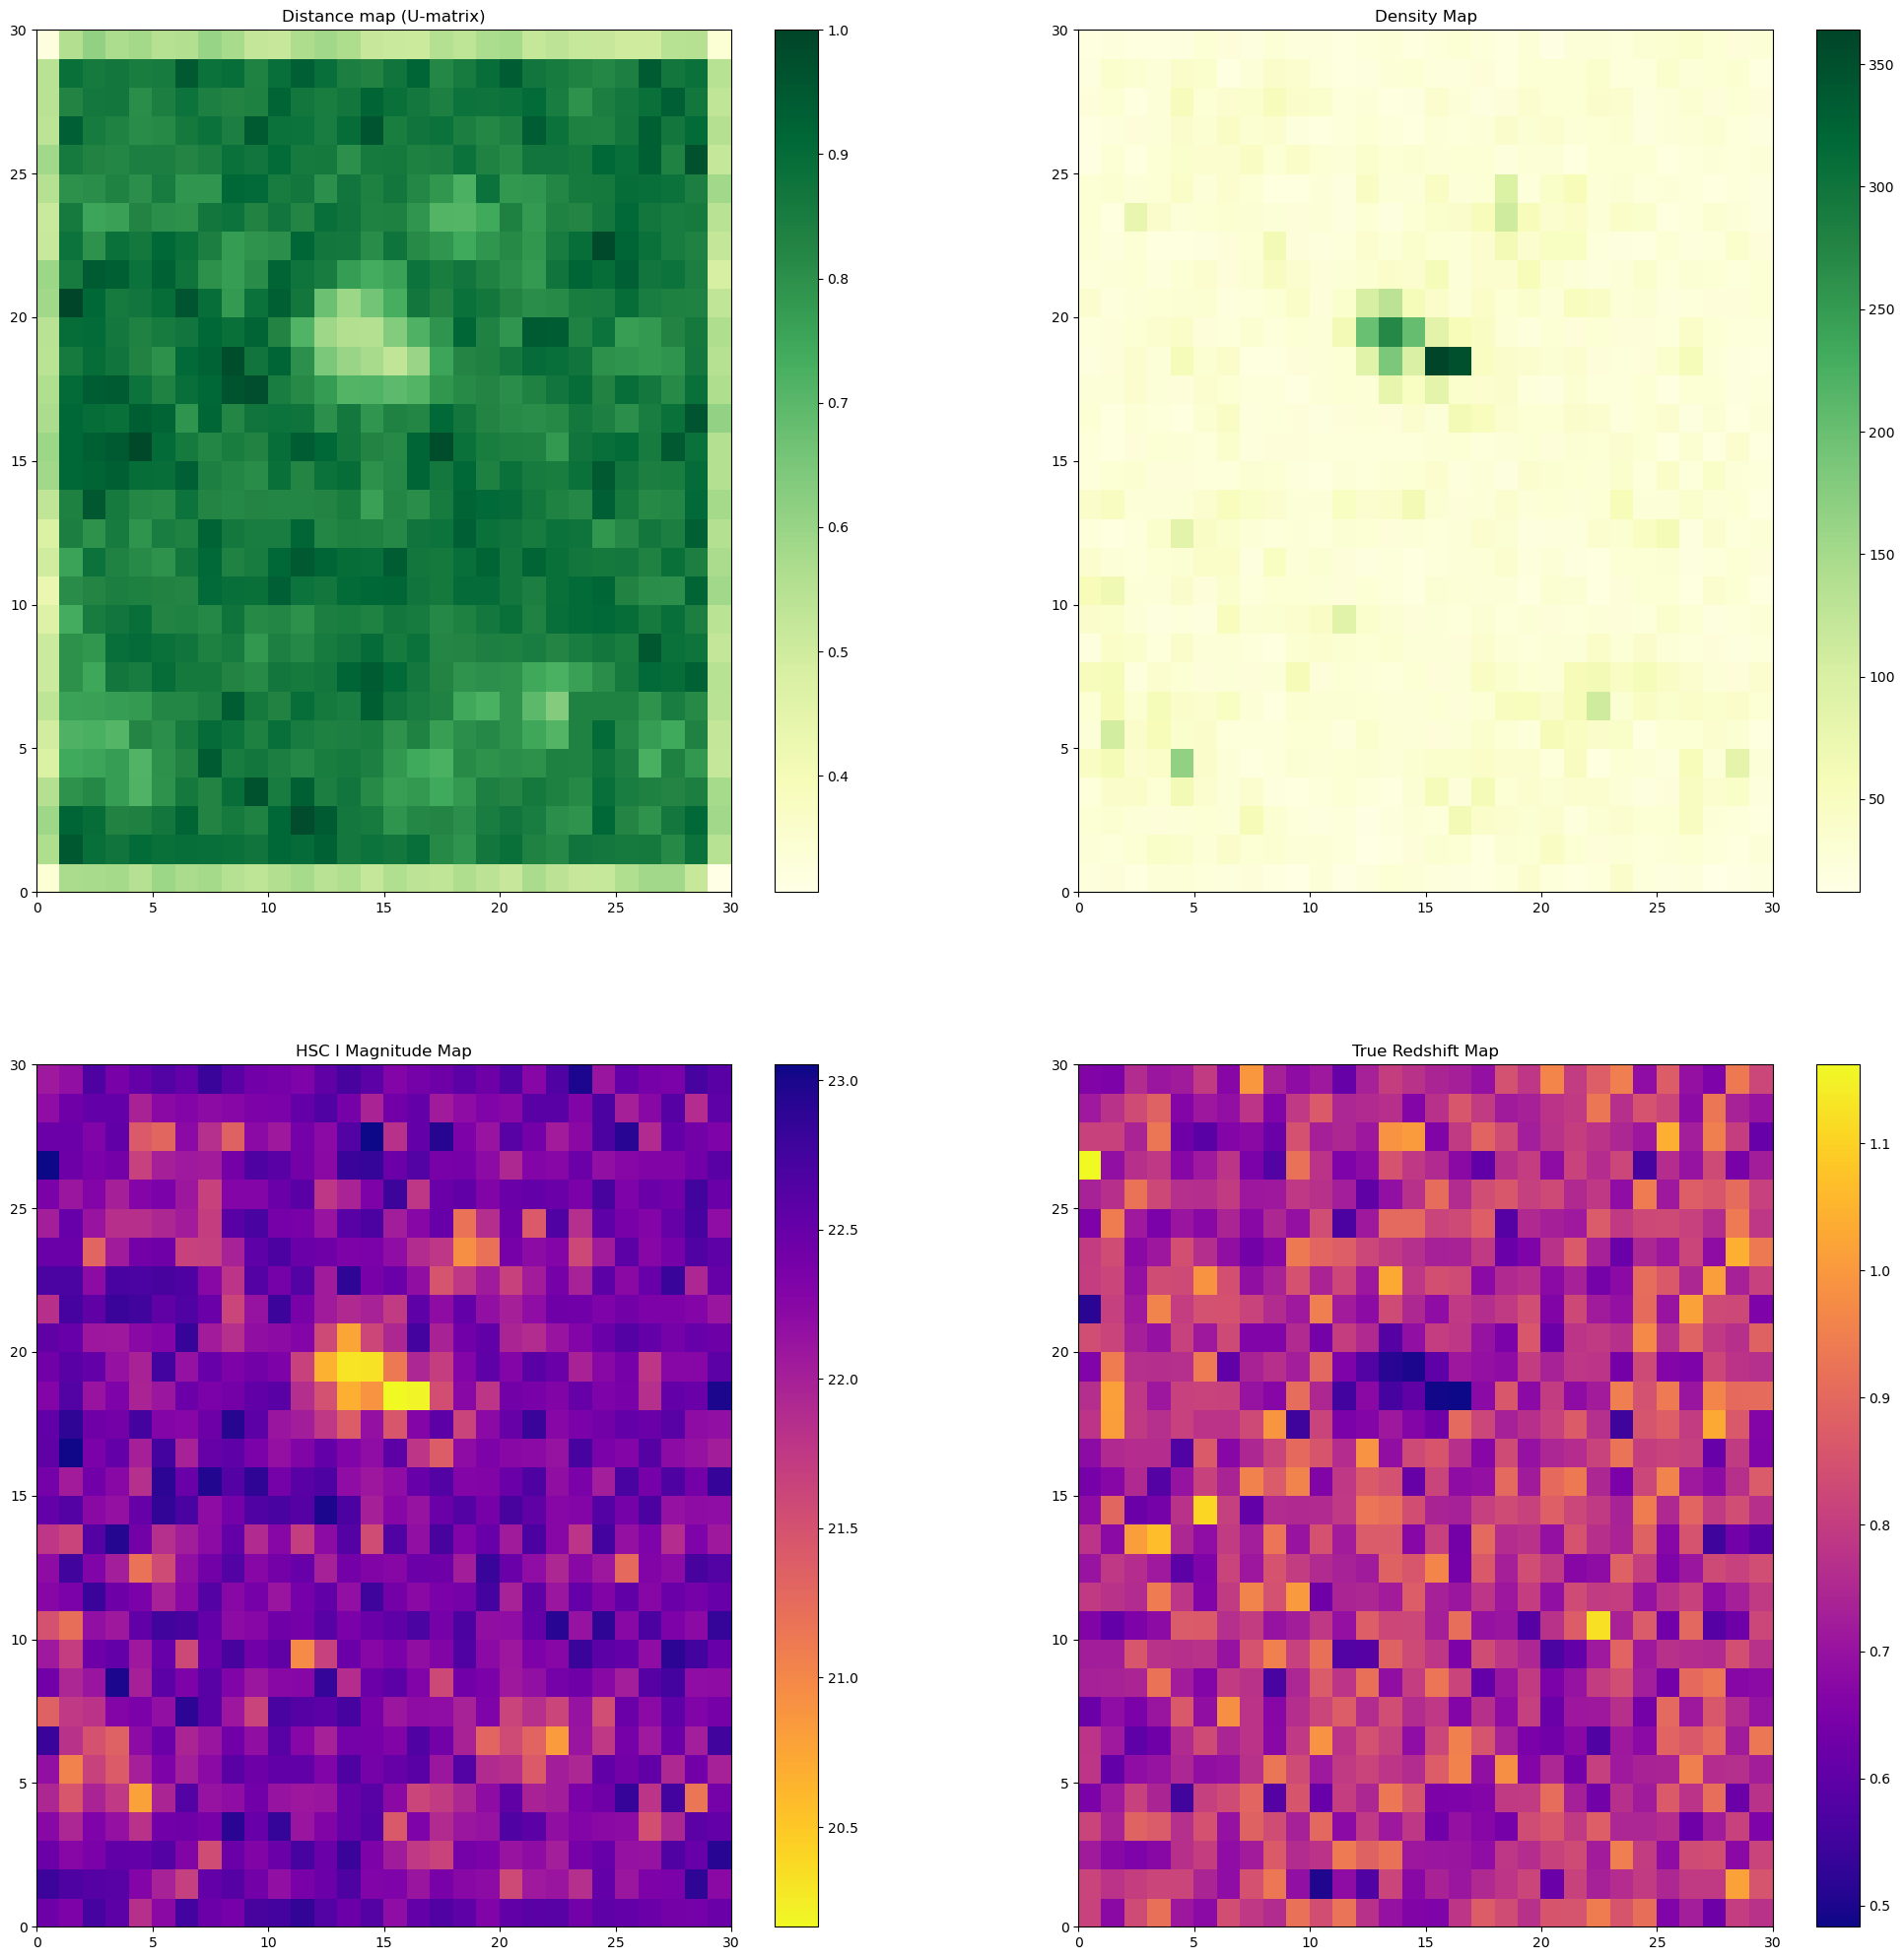

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 0.4]
Topological error: 0.957113499309369
Quantization error: 8.91903154351143
29683.0


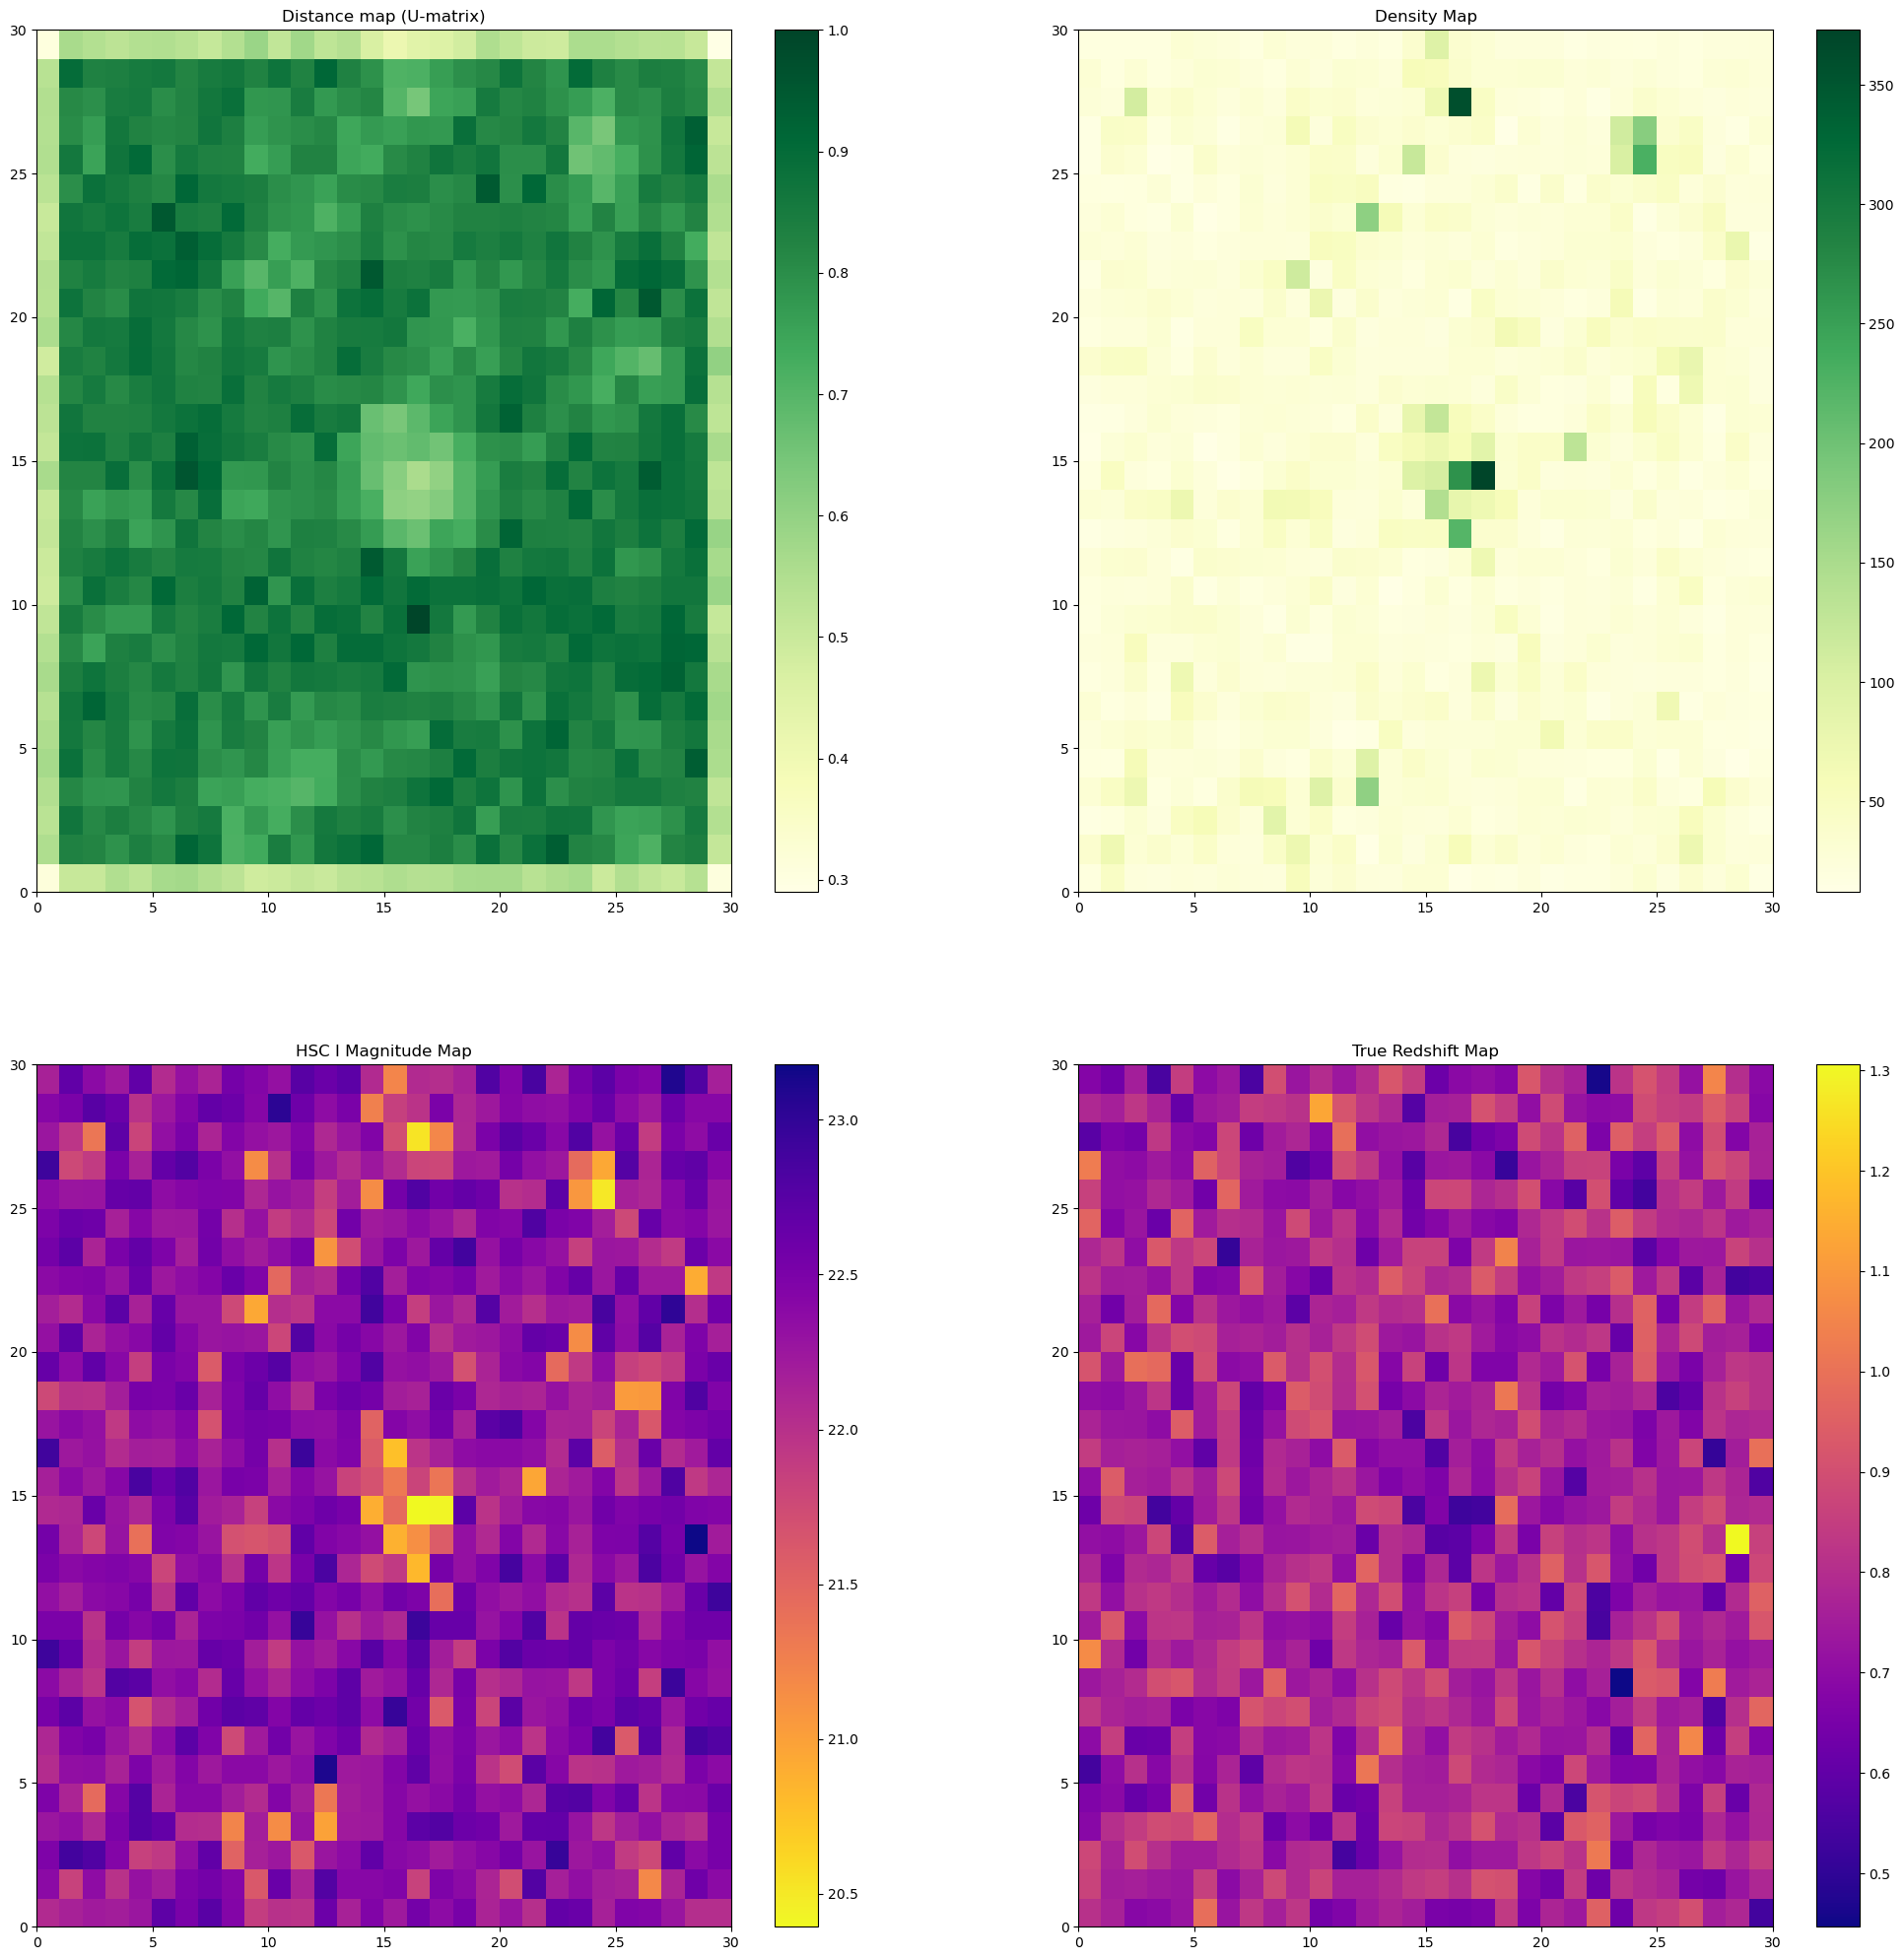

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 0.5]
Topological error: 0.9620321396085302
Quantization error: 8.983888682805096
29683.0


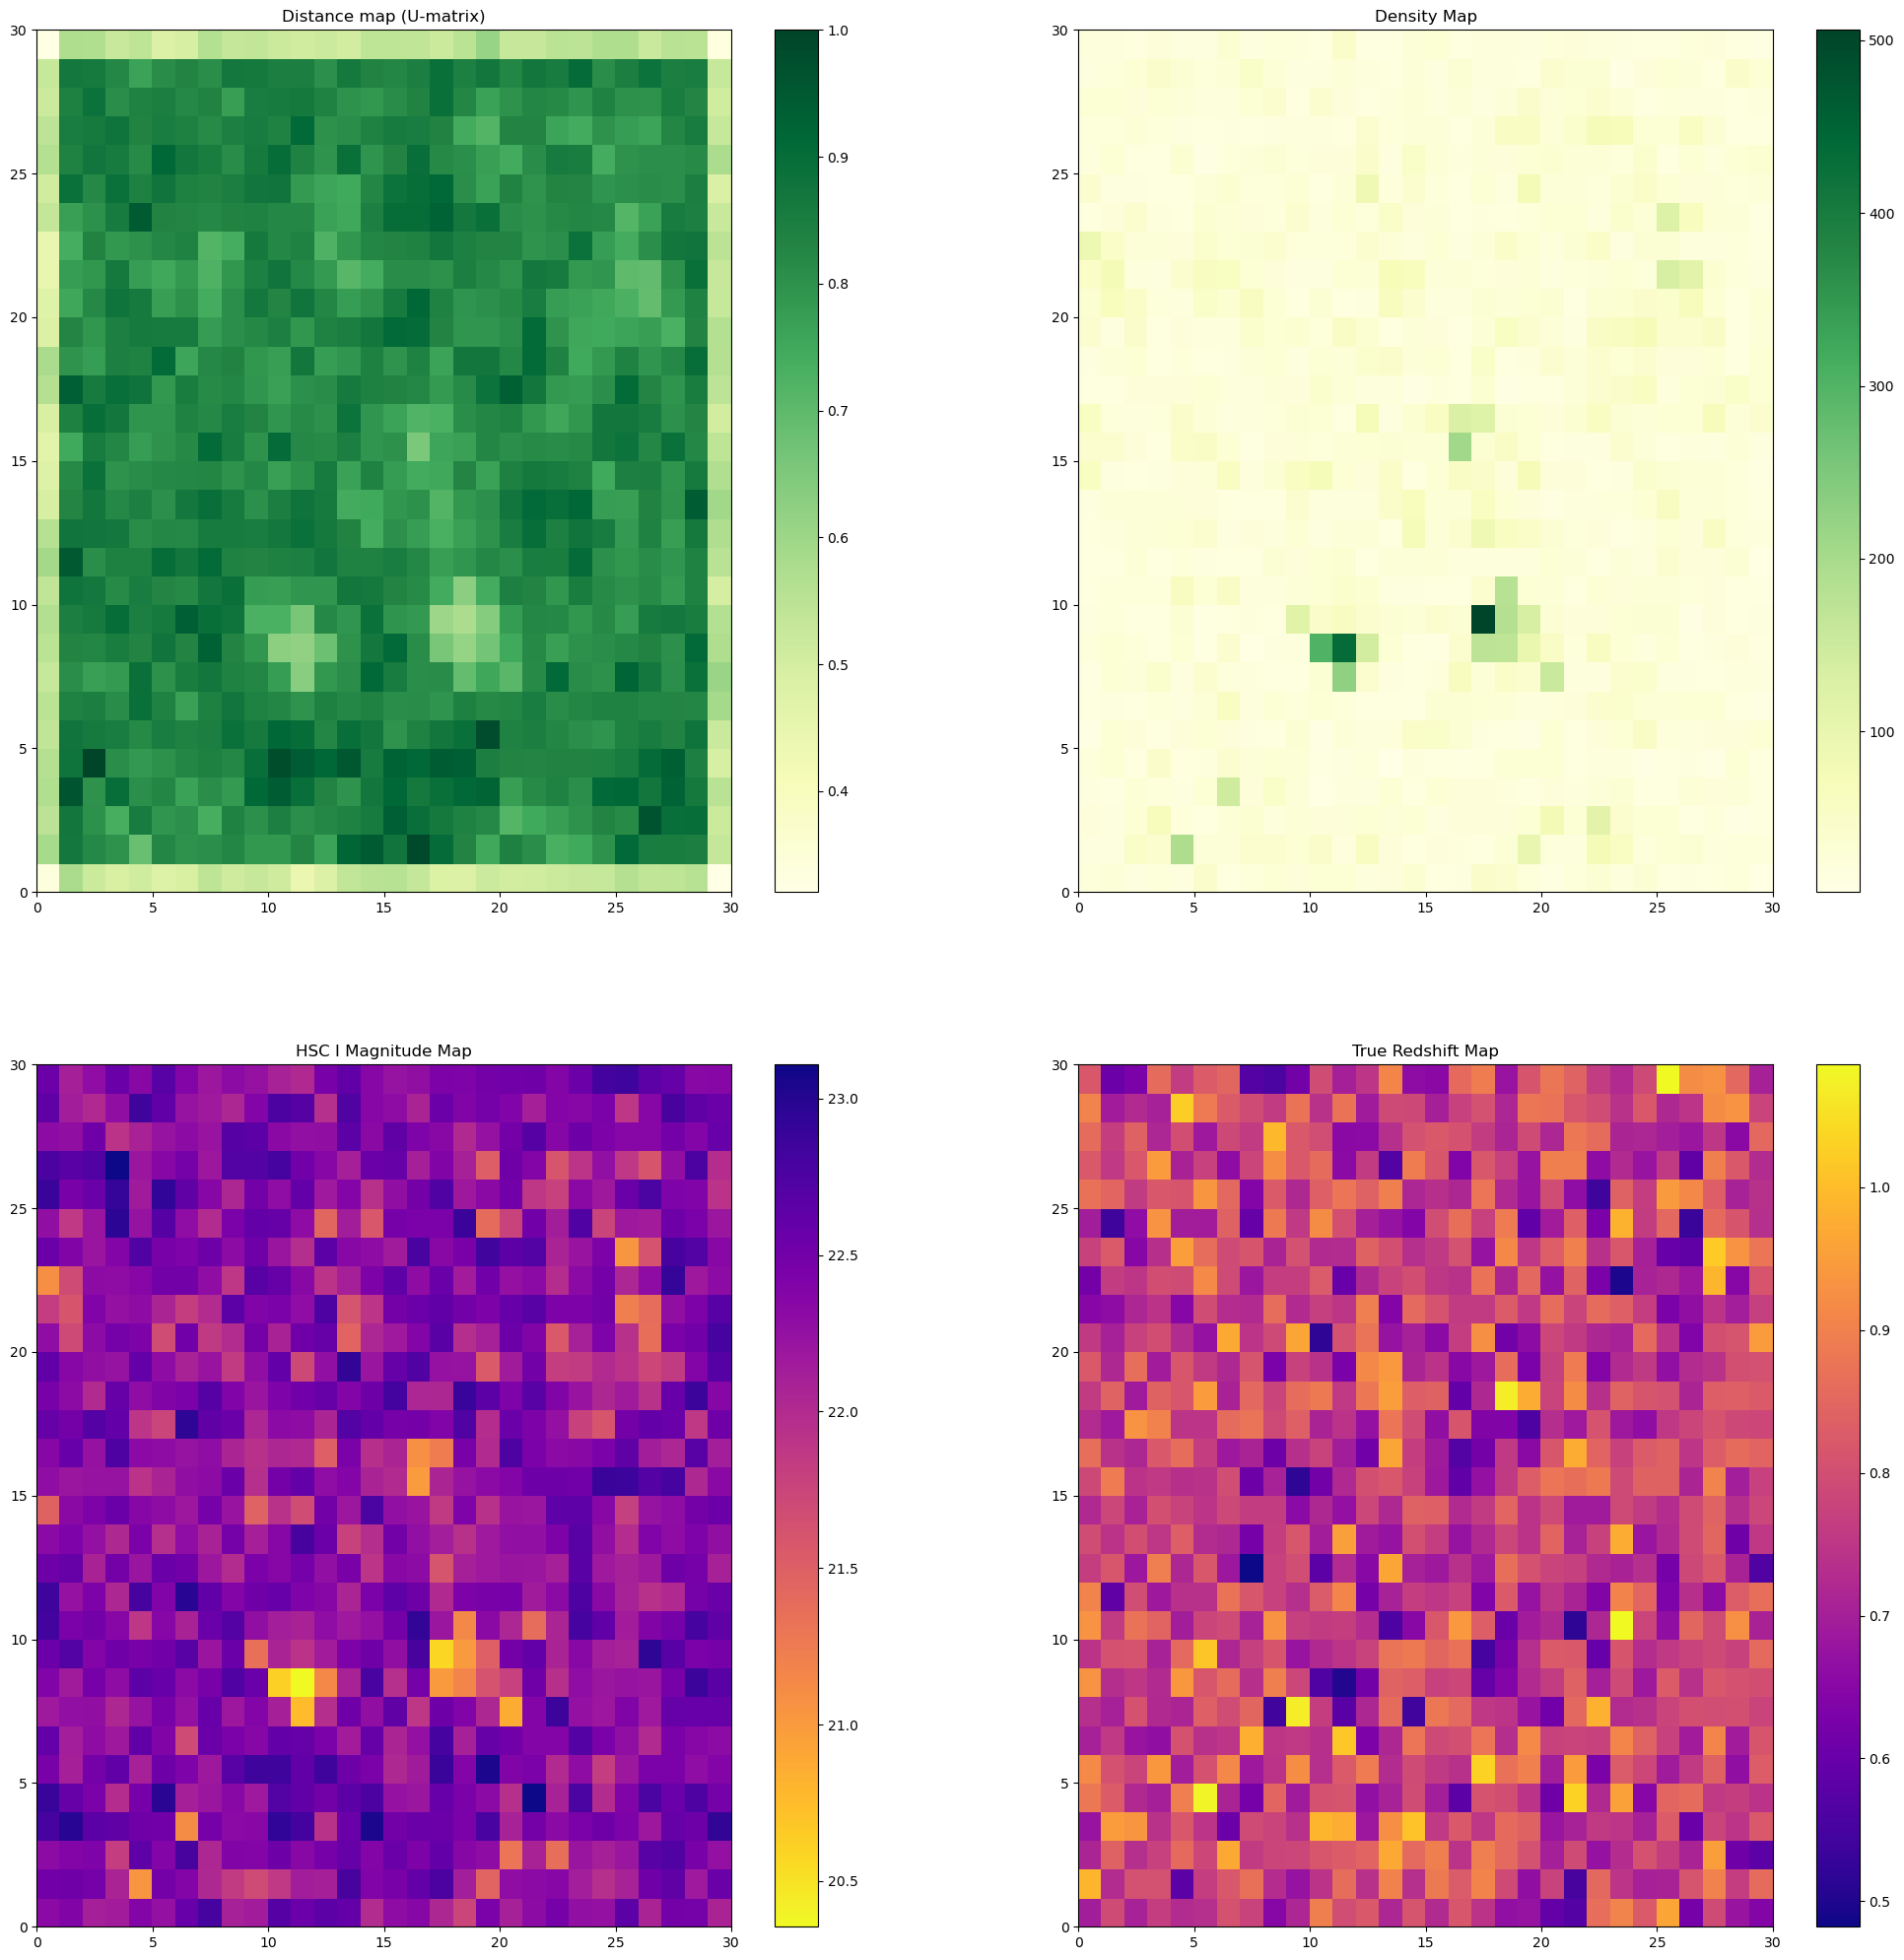

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 0.6]
Topological error: 0.9770575750429539
Quantization error: 9.051833138881554
29683.0


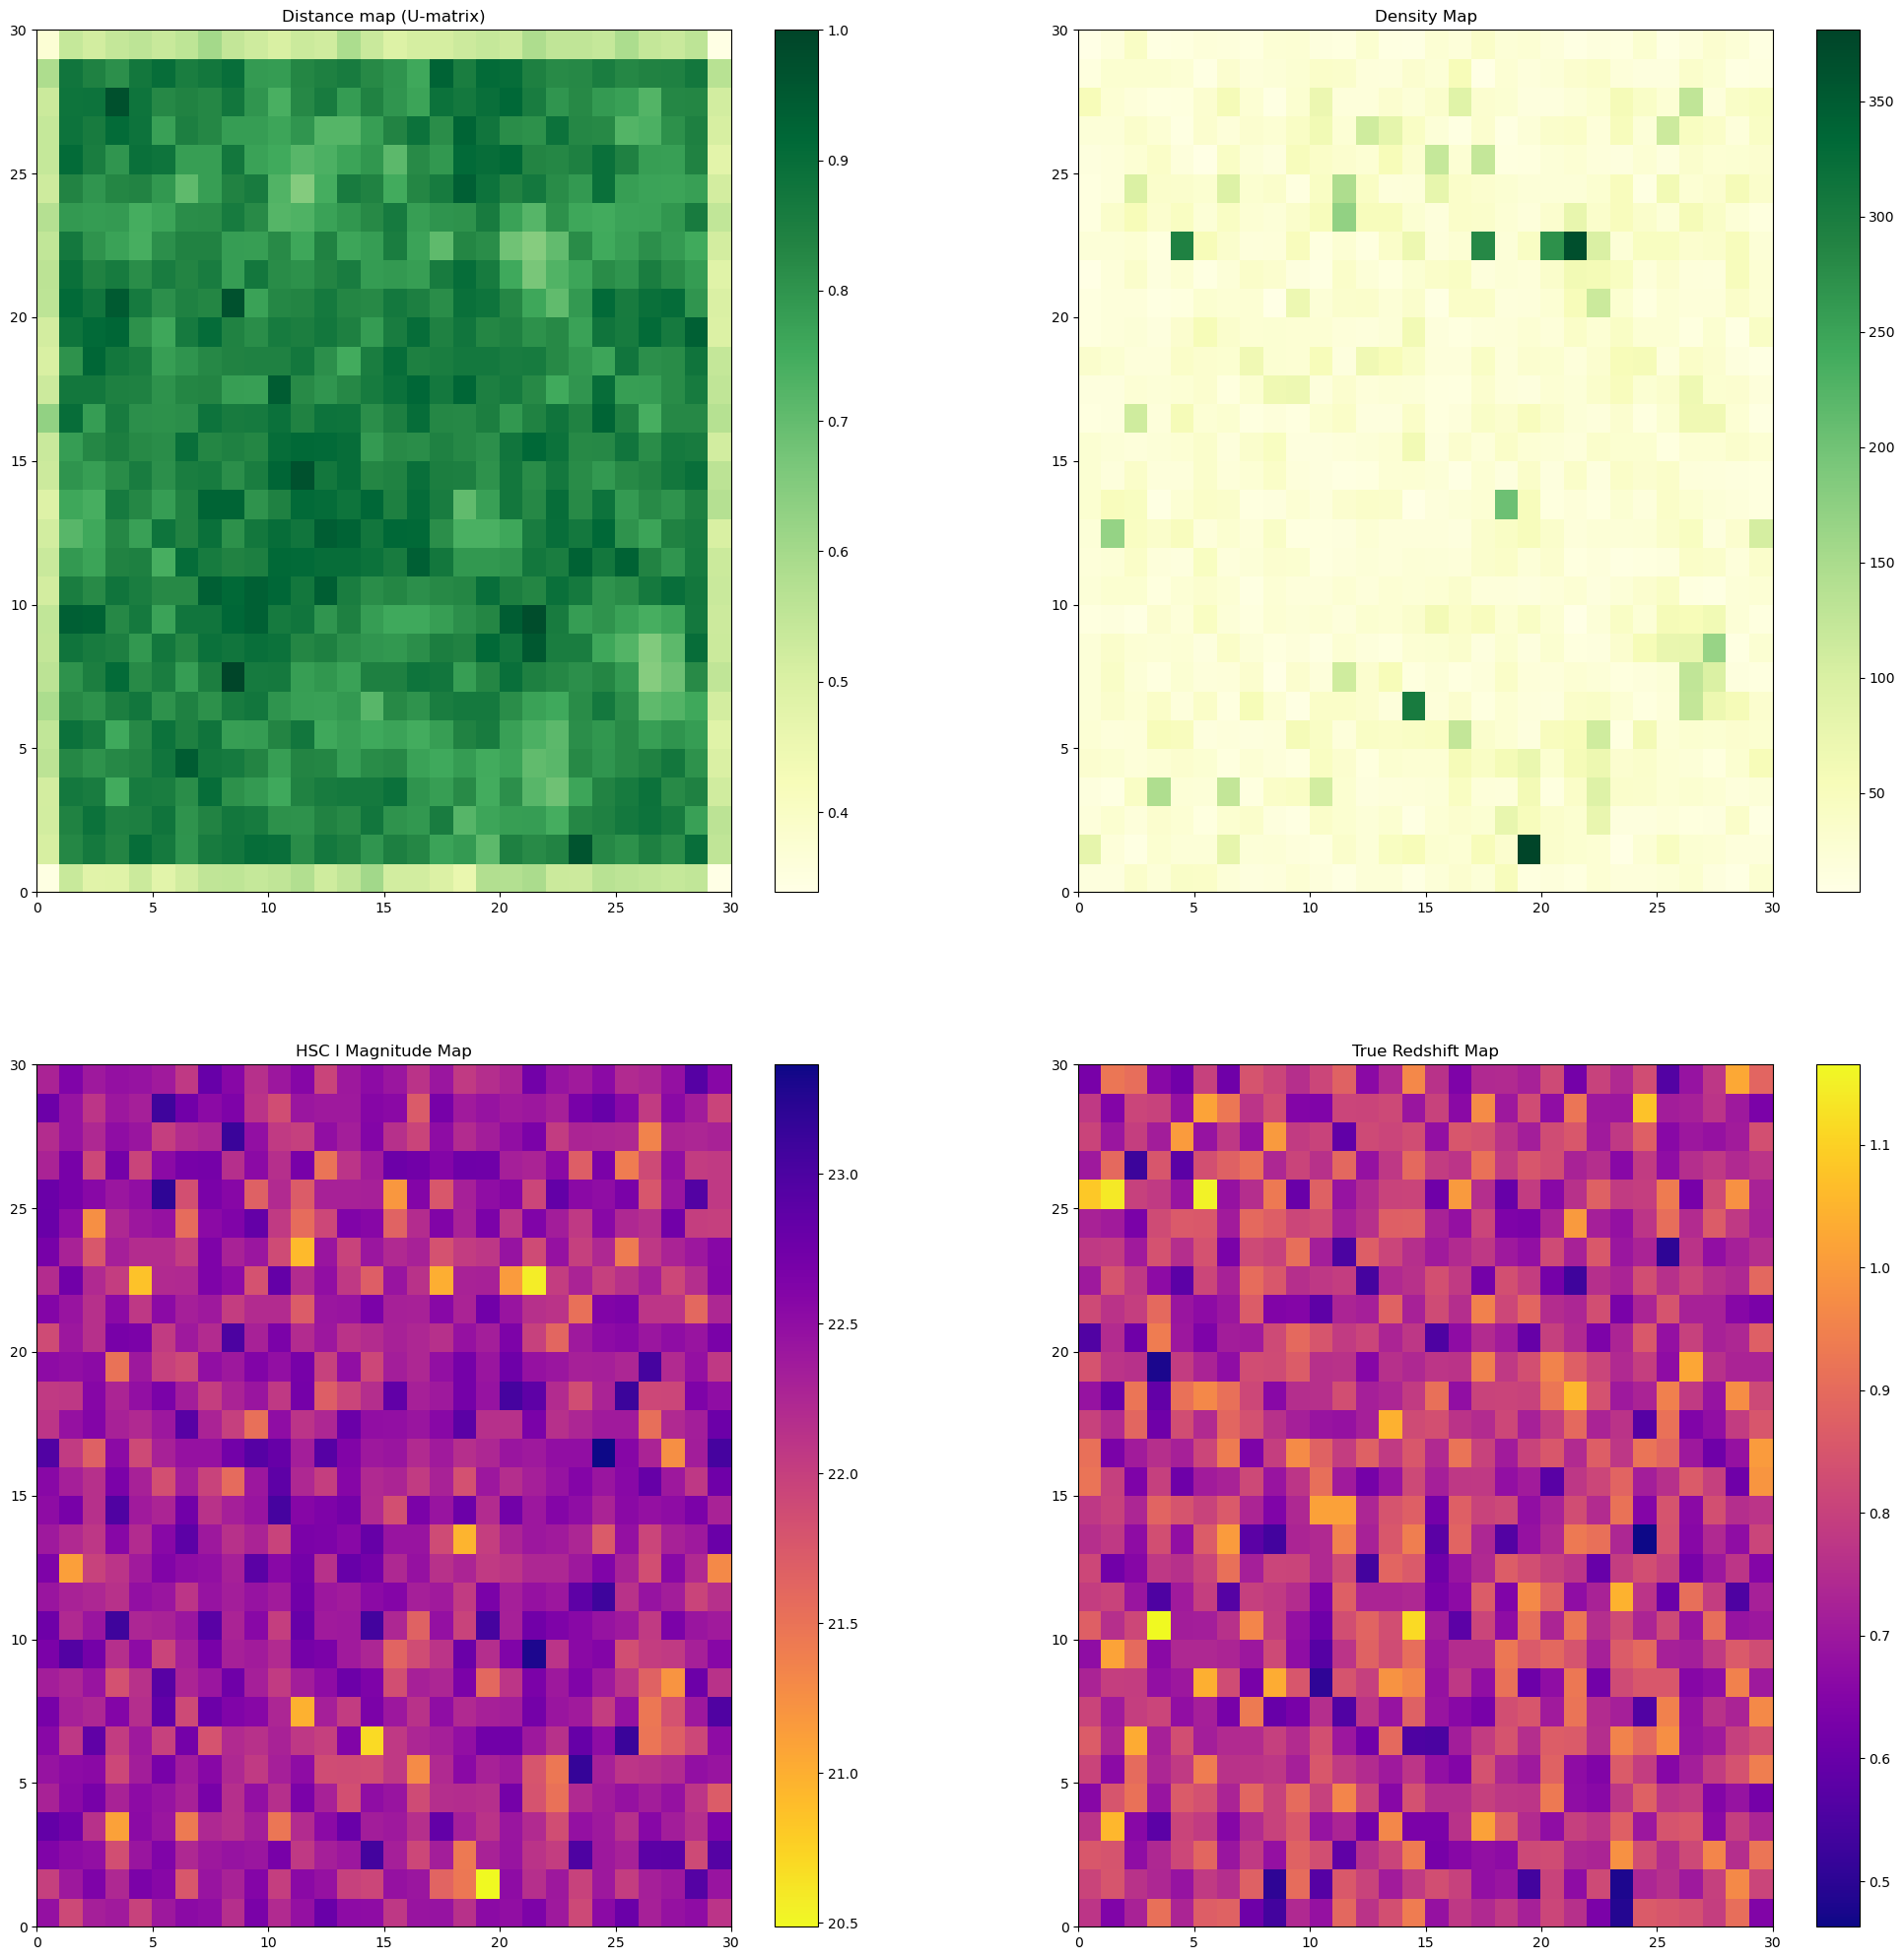

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 0.7]
Topological error: 0.9667149546878685
Quantization error: 9.112874053743695
29683.0


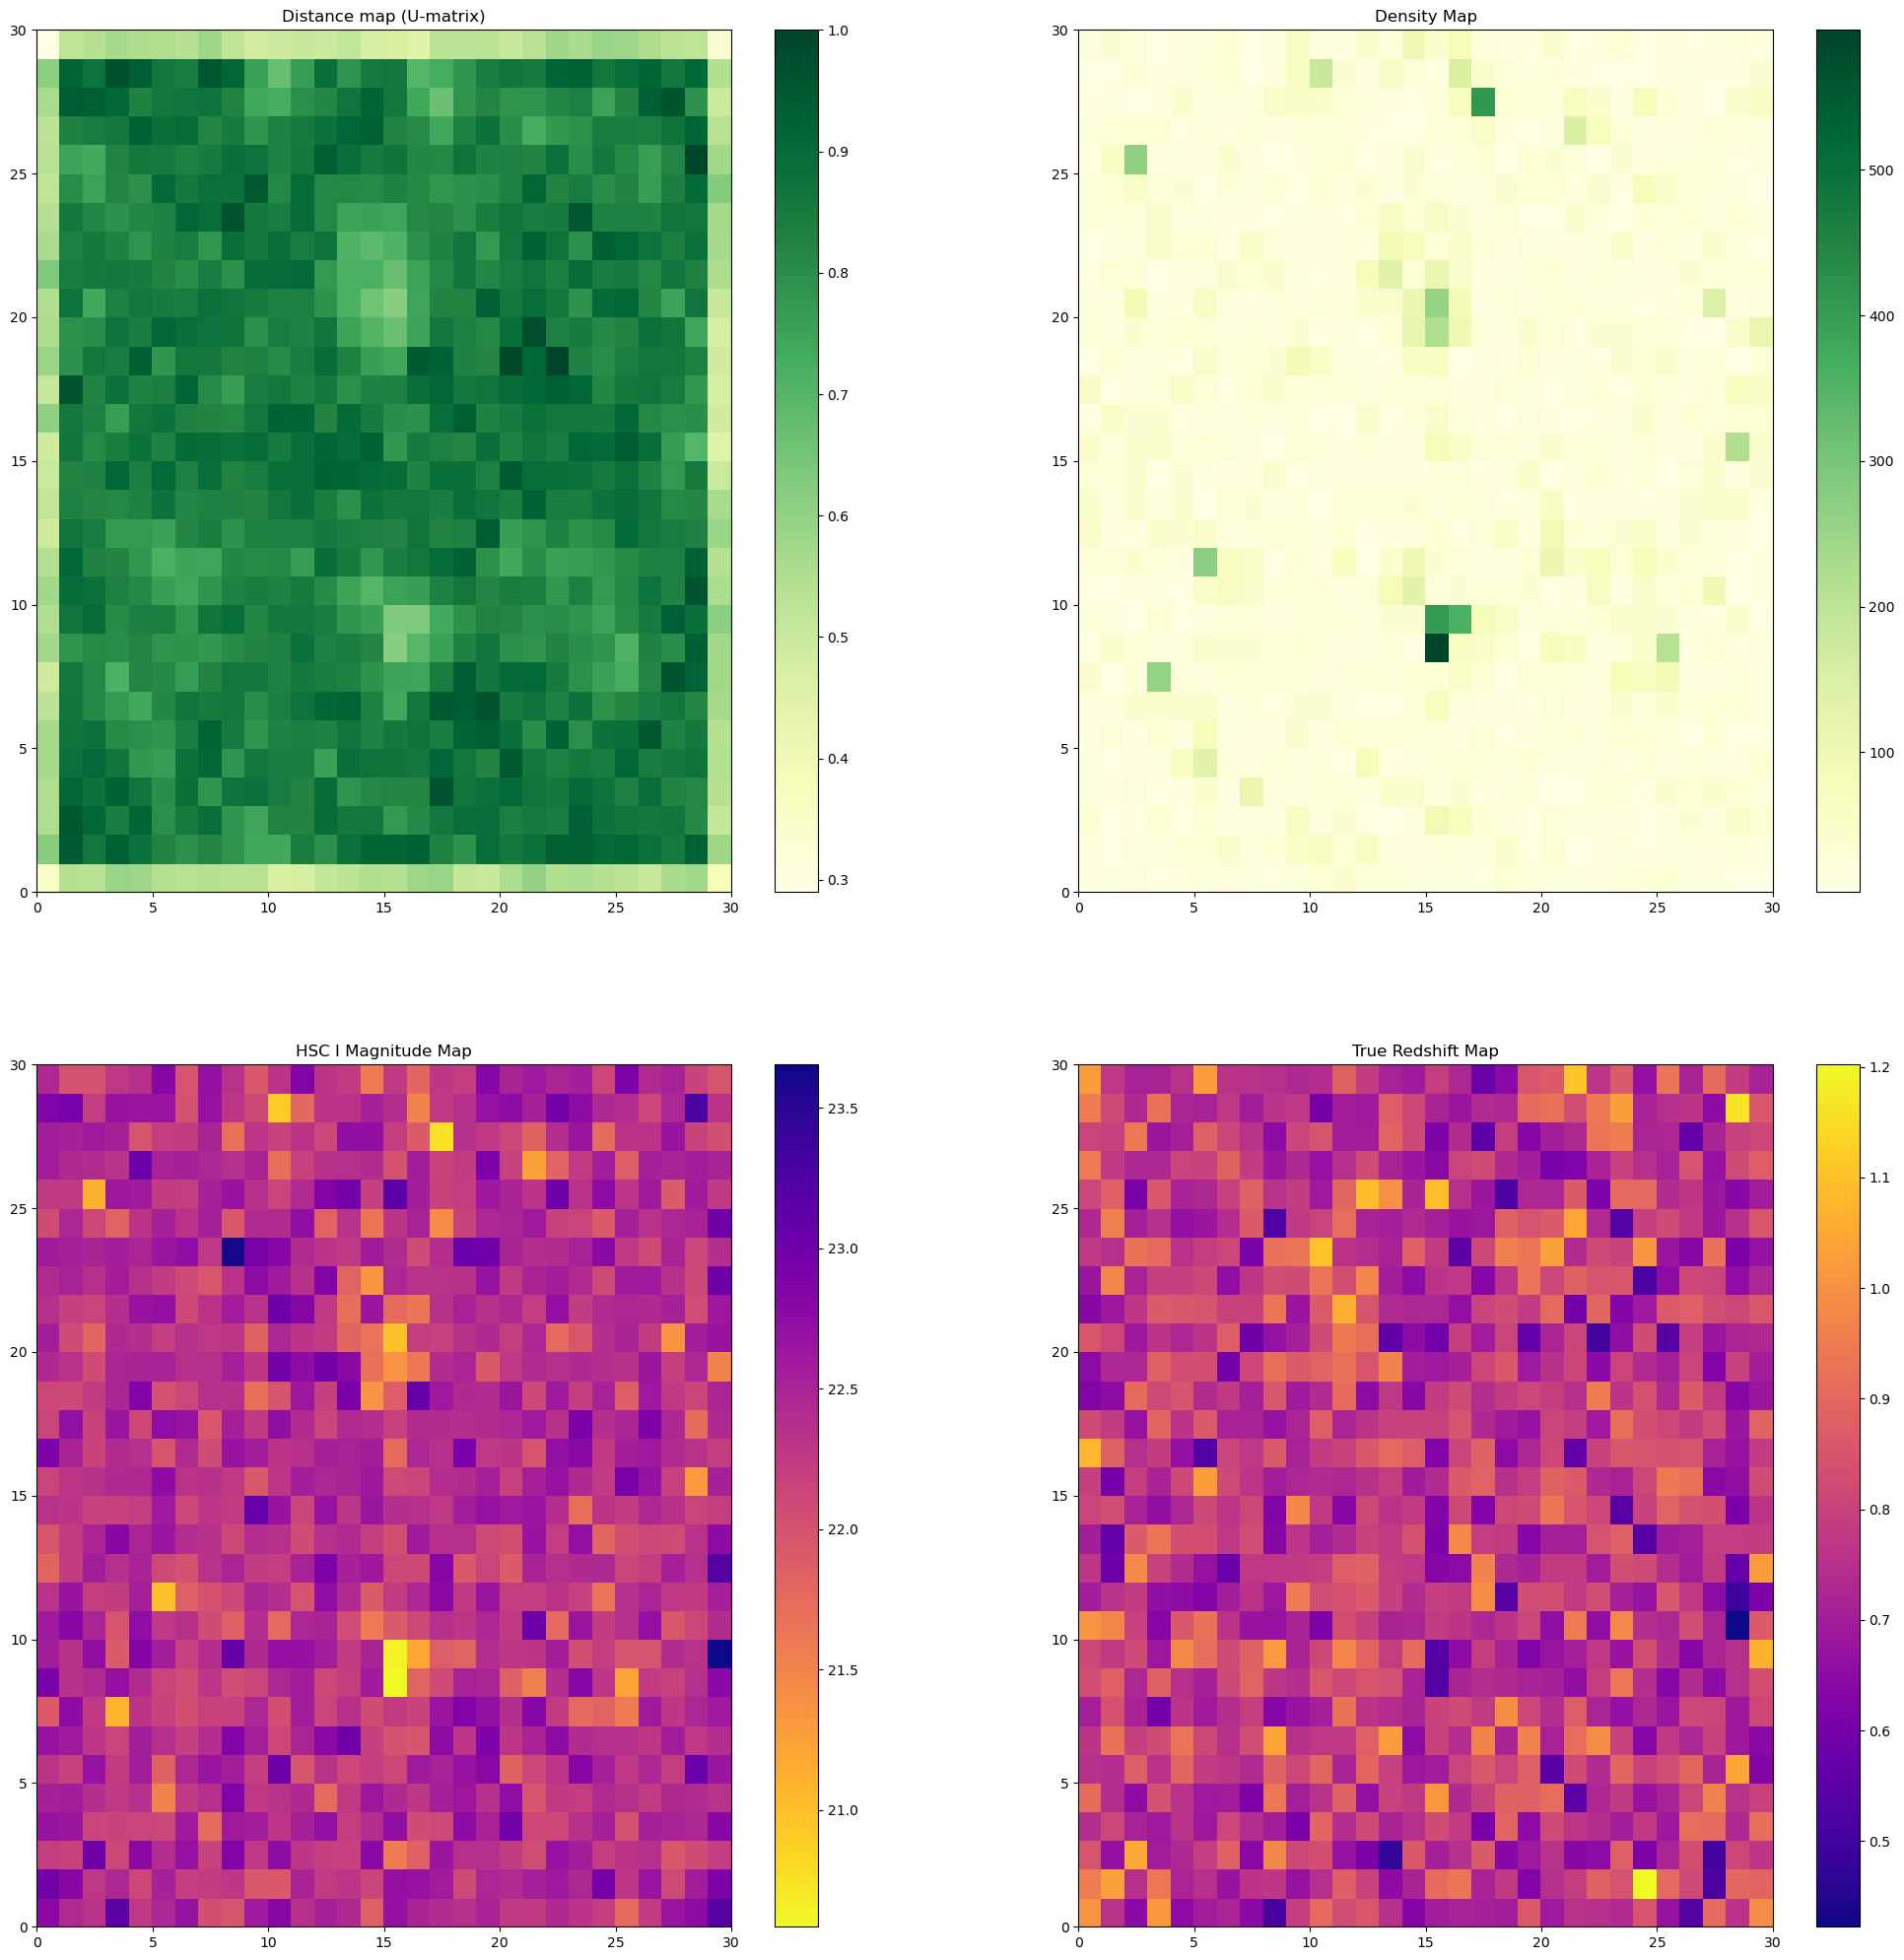

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 0.8]
Topological error: 0.9731833035744365
Quantization error: 9.181520461087958
29683.0


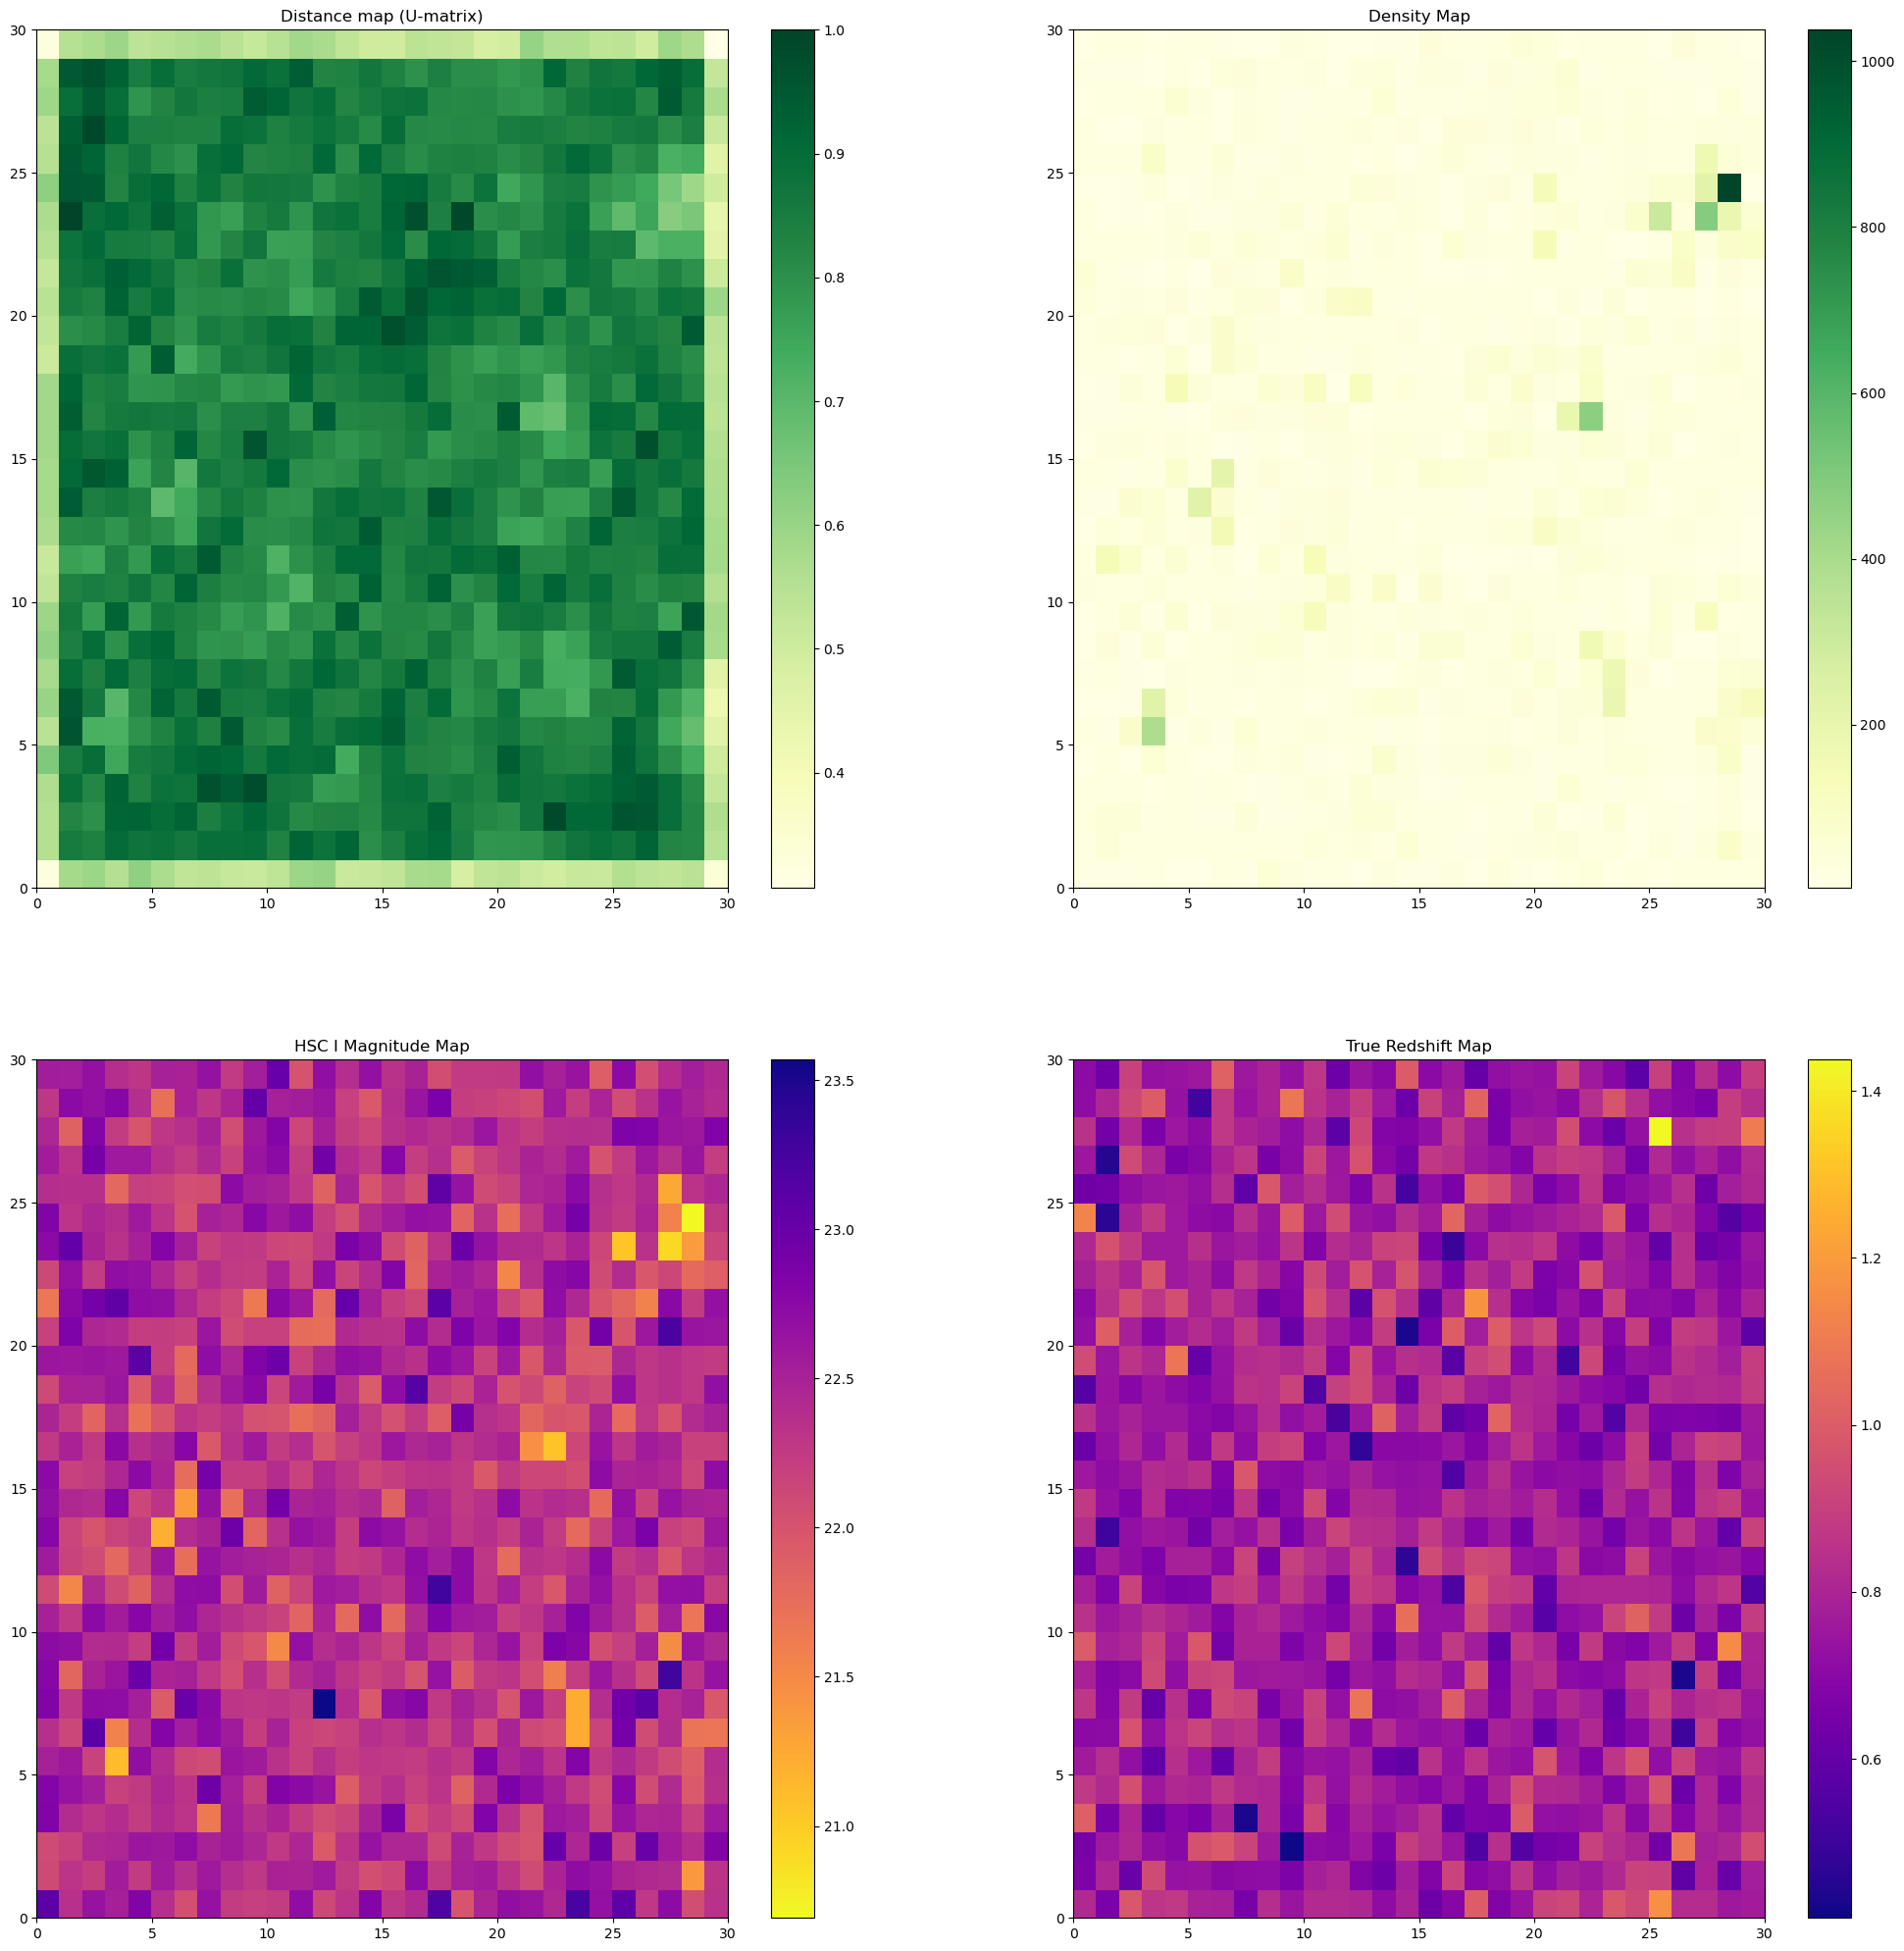

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 0.9]
Topological error: 0.9656368965401071
Quantization error: 9.259484667718077
29683.0


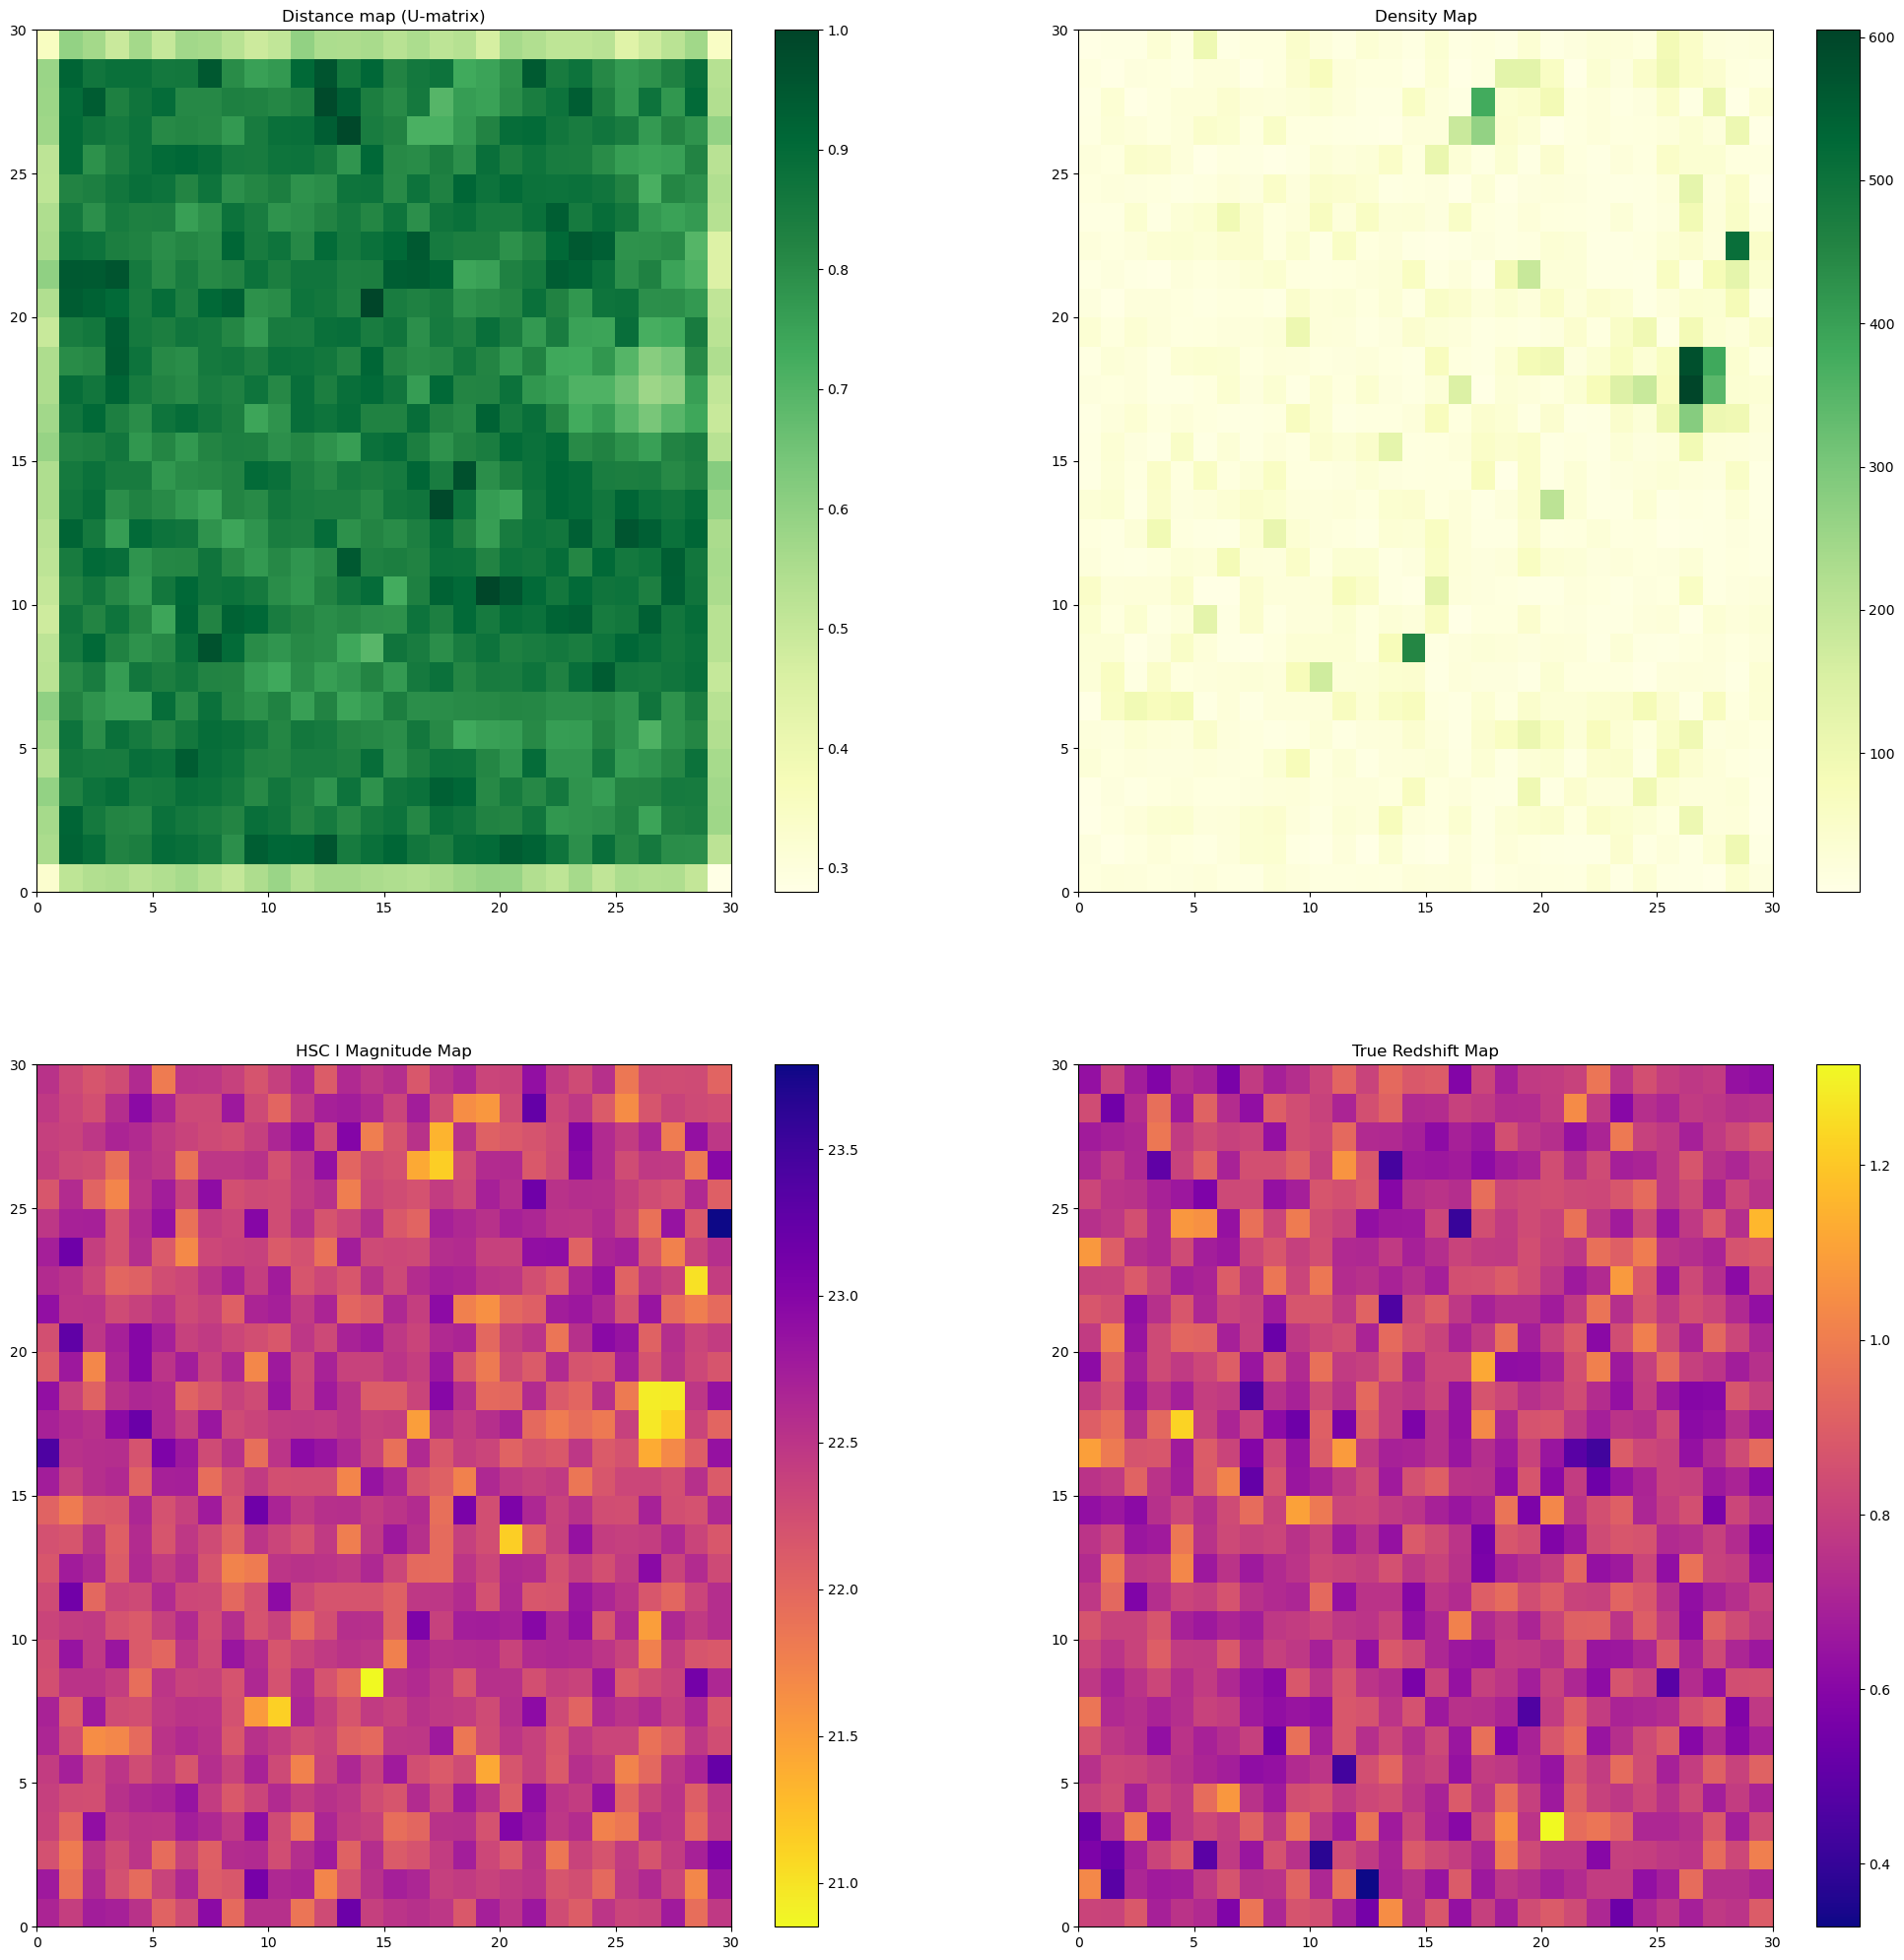

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 1.0]
Topological error: 0.9799885456321801
Quantization error: 9.343016832751333
29683.0


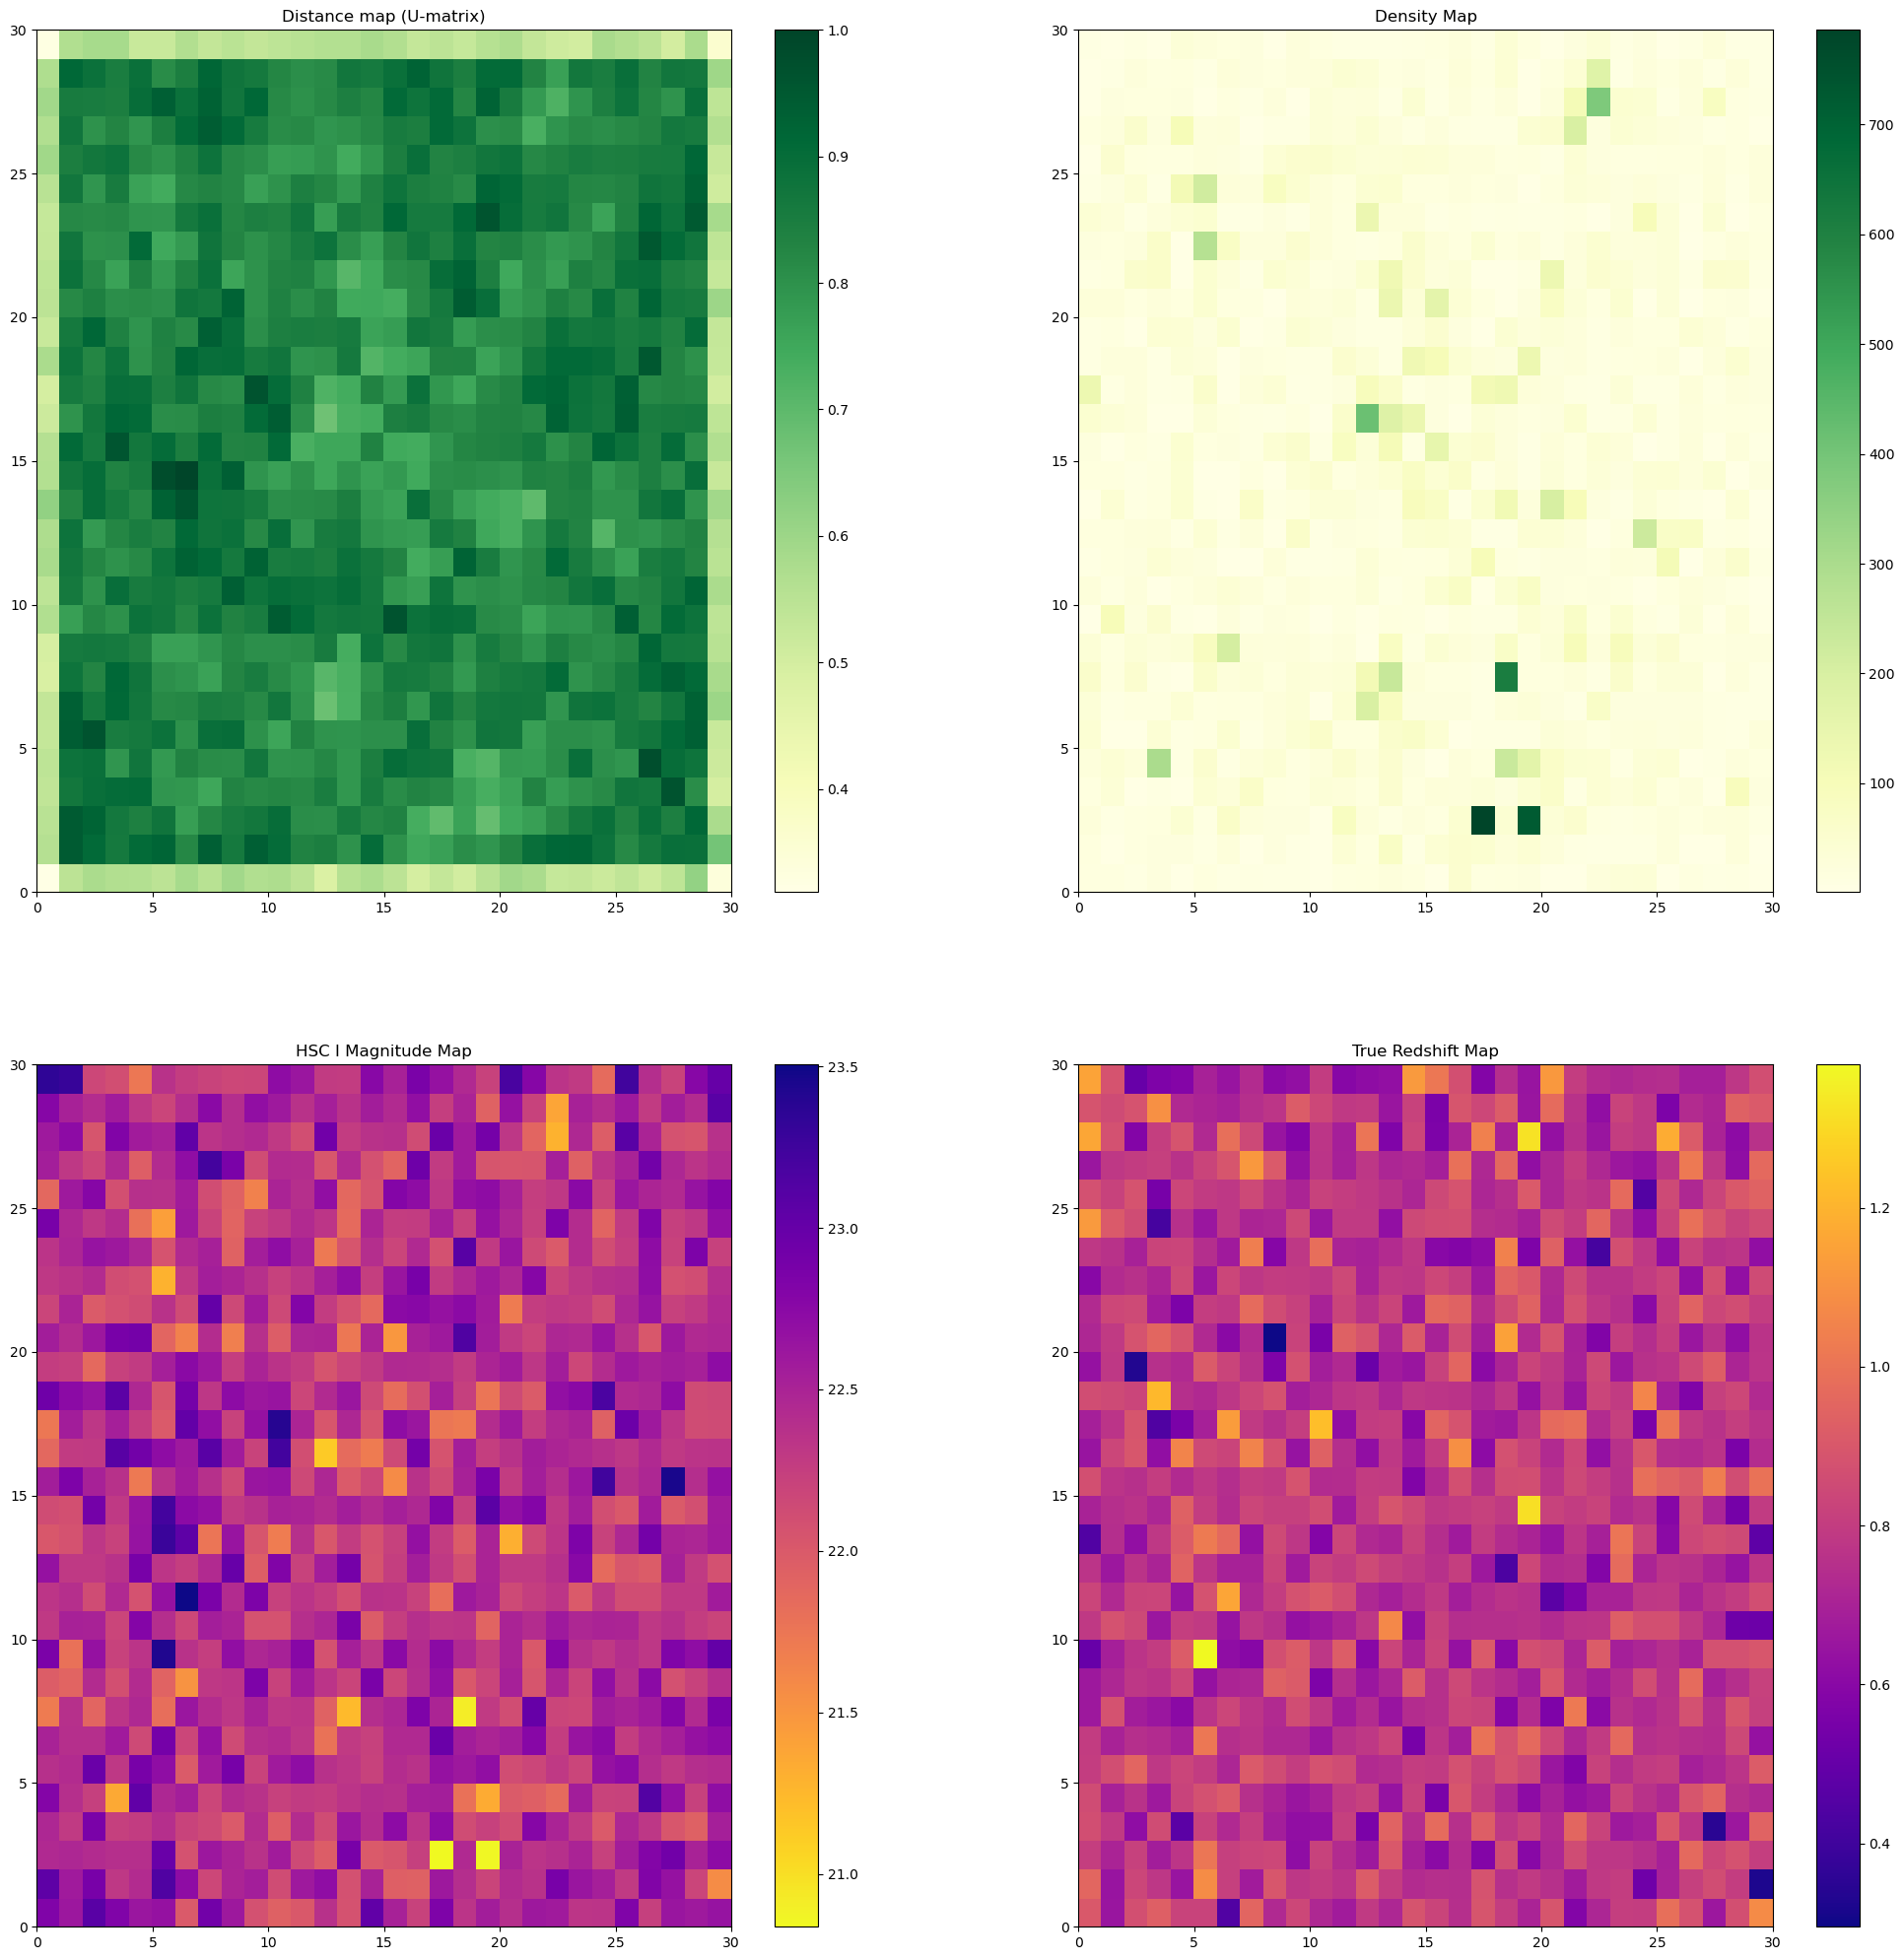

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 1.1]
Topological error: 0.9768891284573662
Quantization error: 9.422469054111884
29683.0


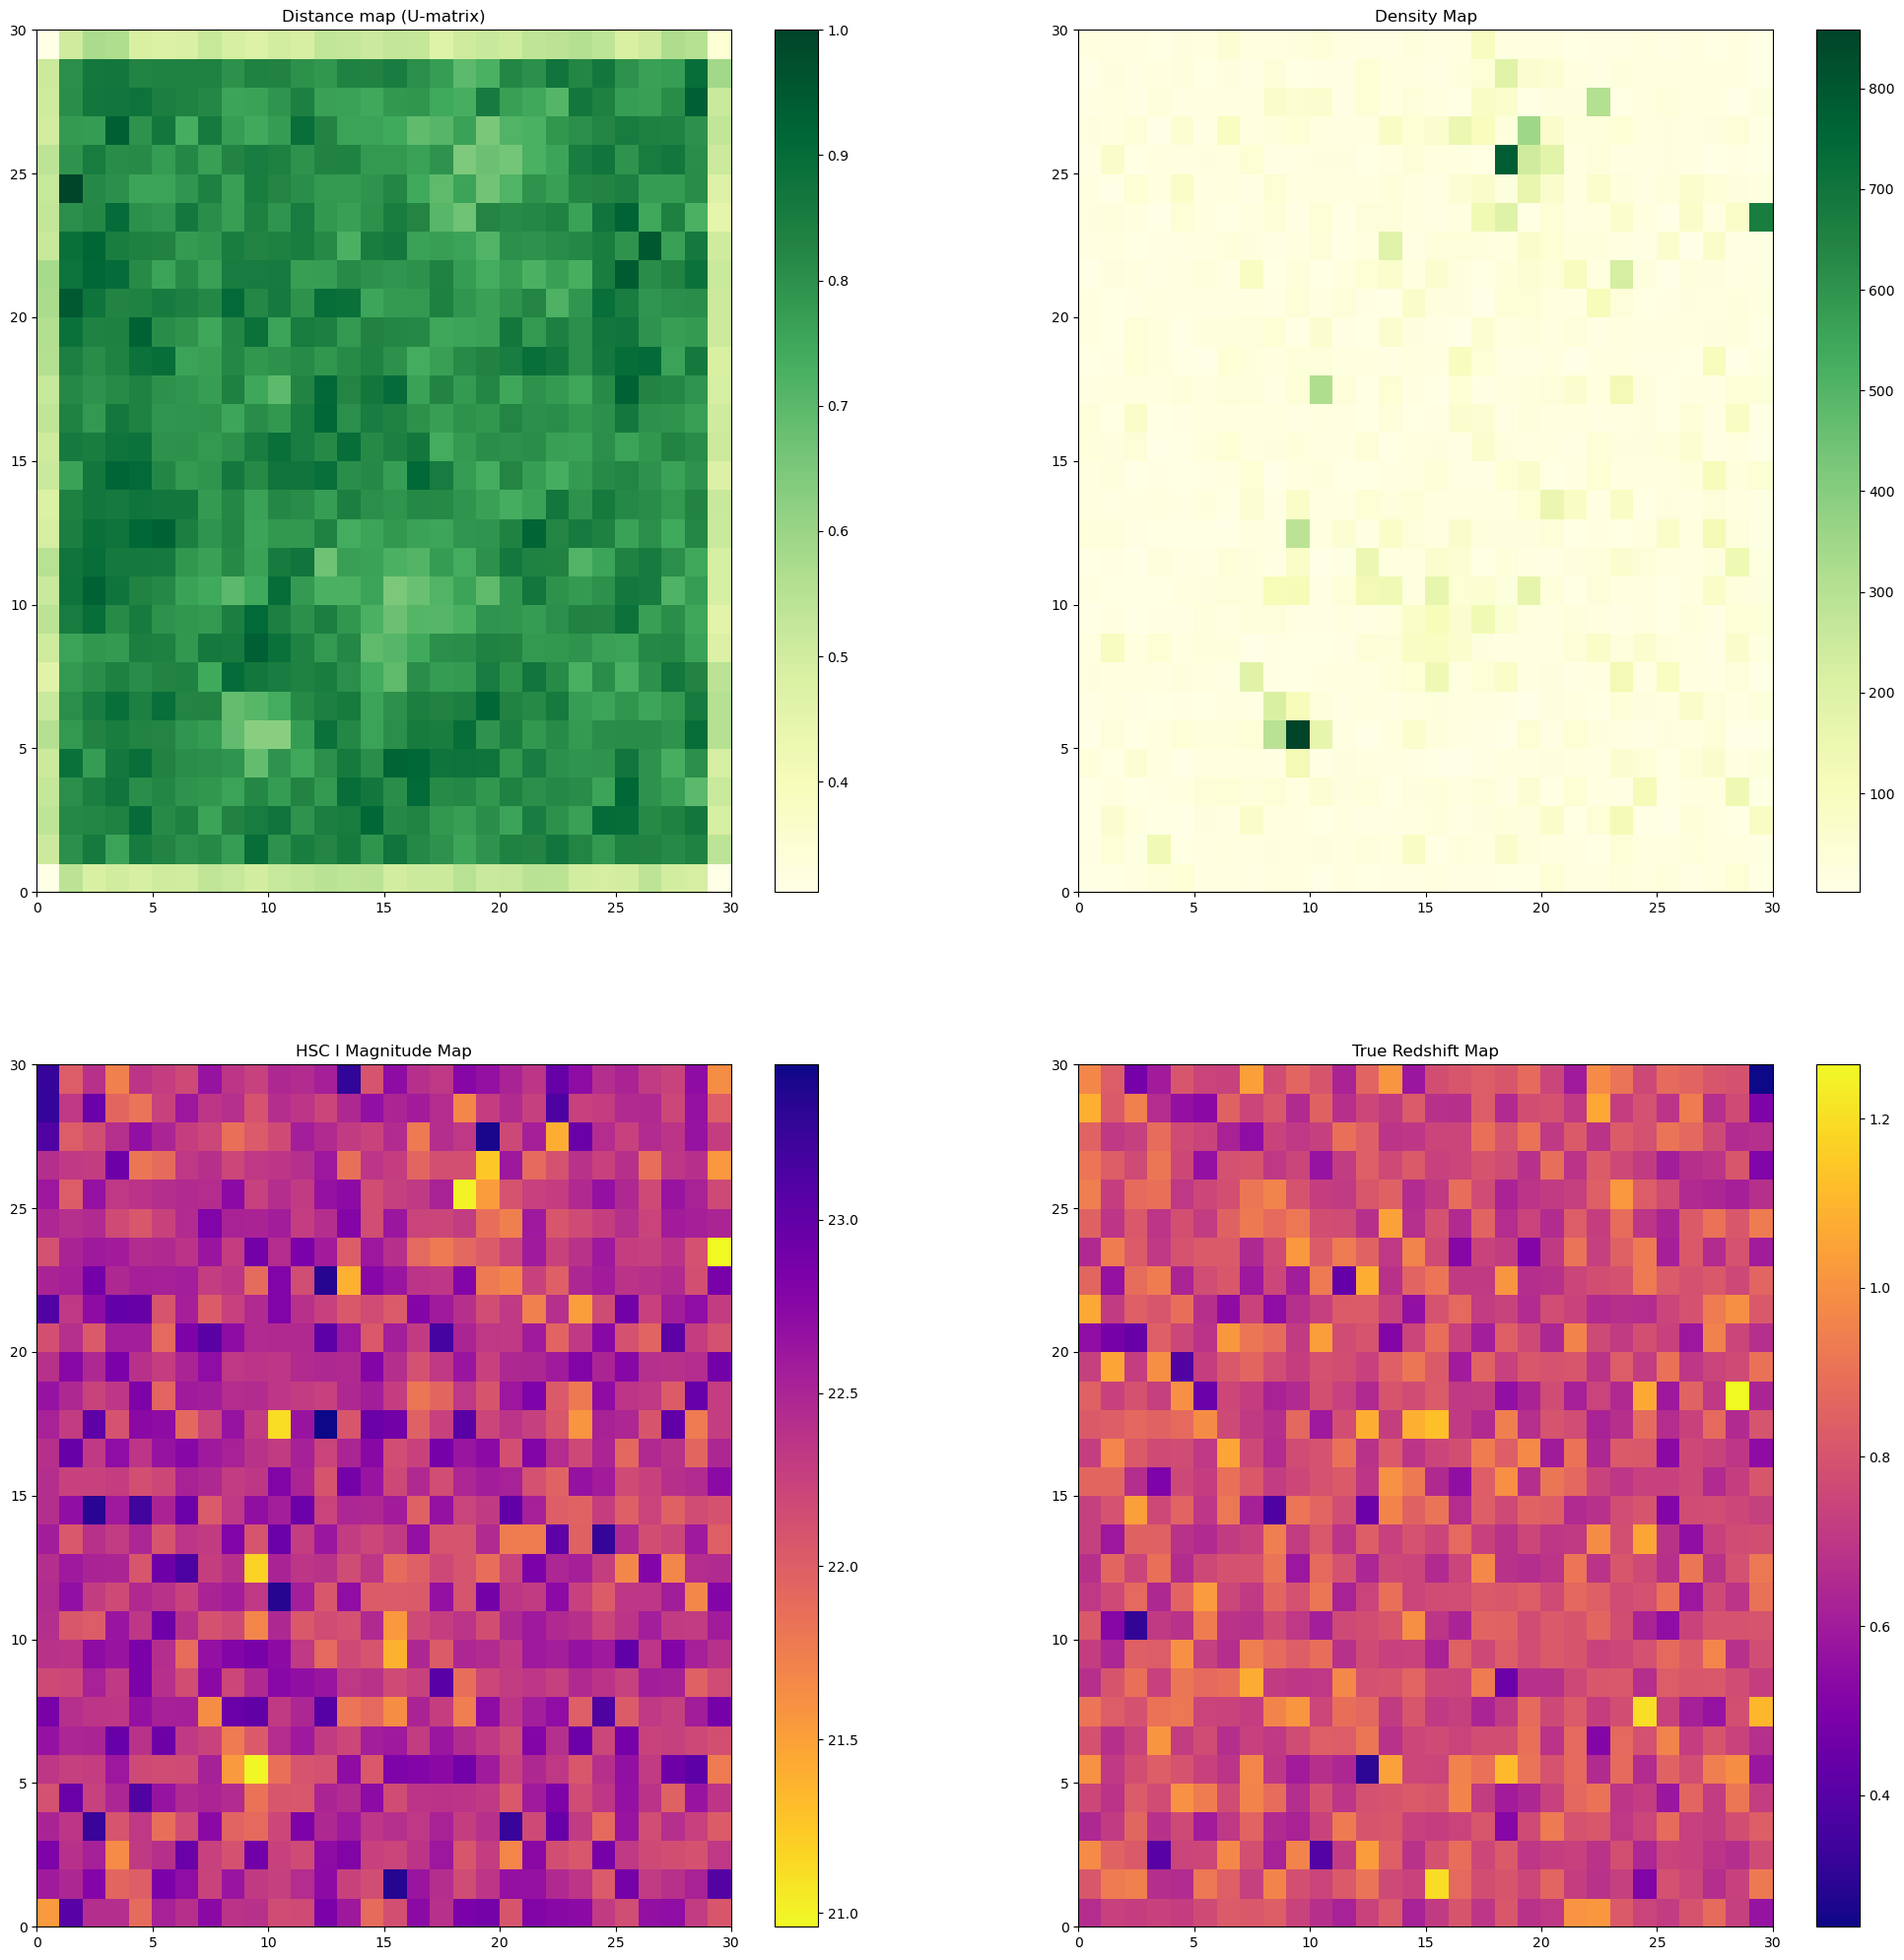

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 1.2]
Topological error: 0.9821783512448202
Quantization error: 9.516658998044047
29683.0


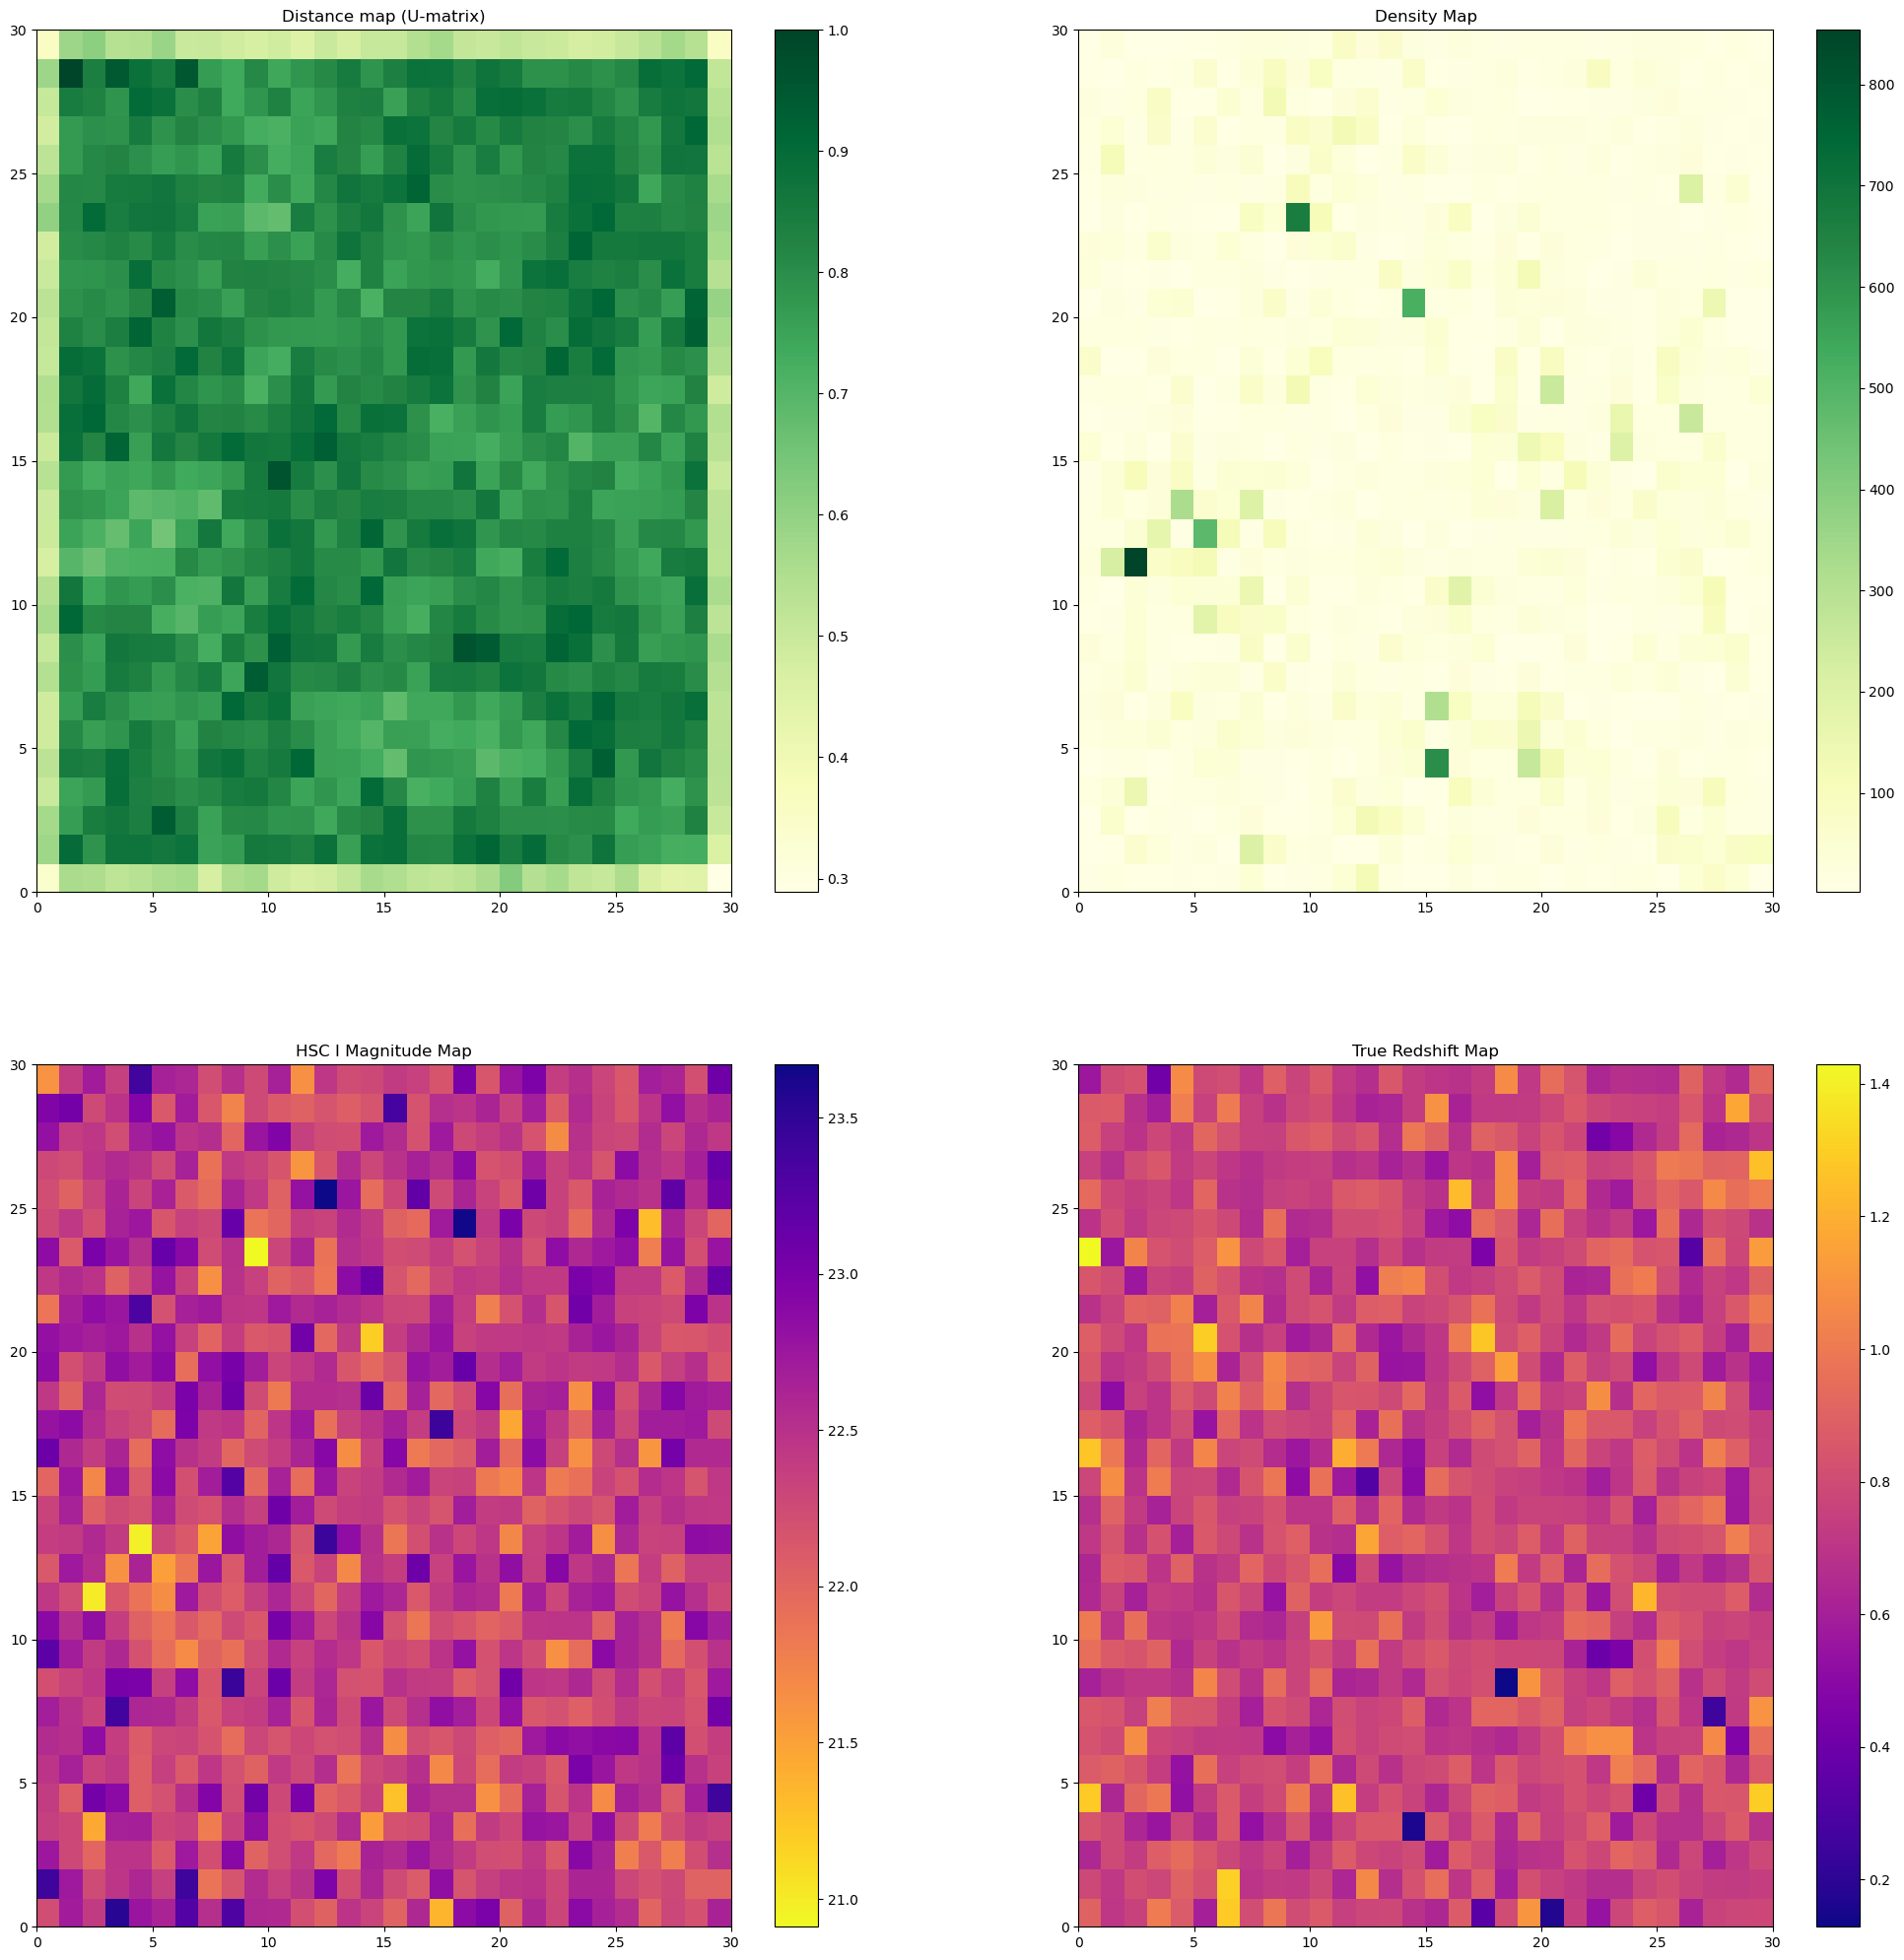

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 1.3]
Topological error: 0.9749014587474312
Quantization error: 9.59804474763938
29683.0


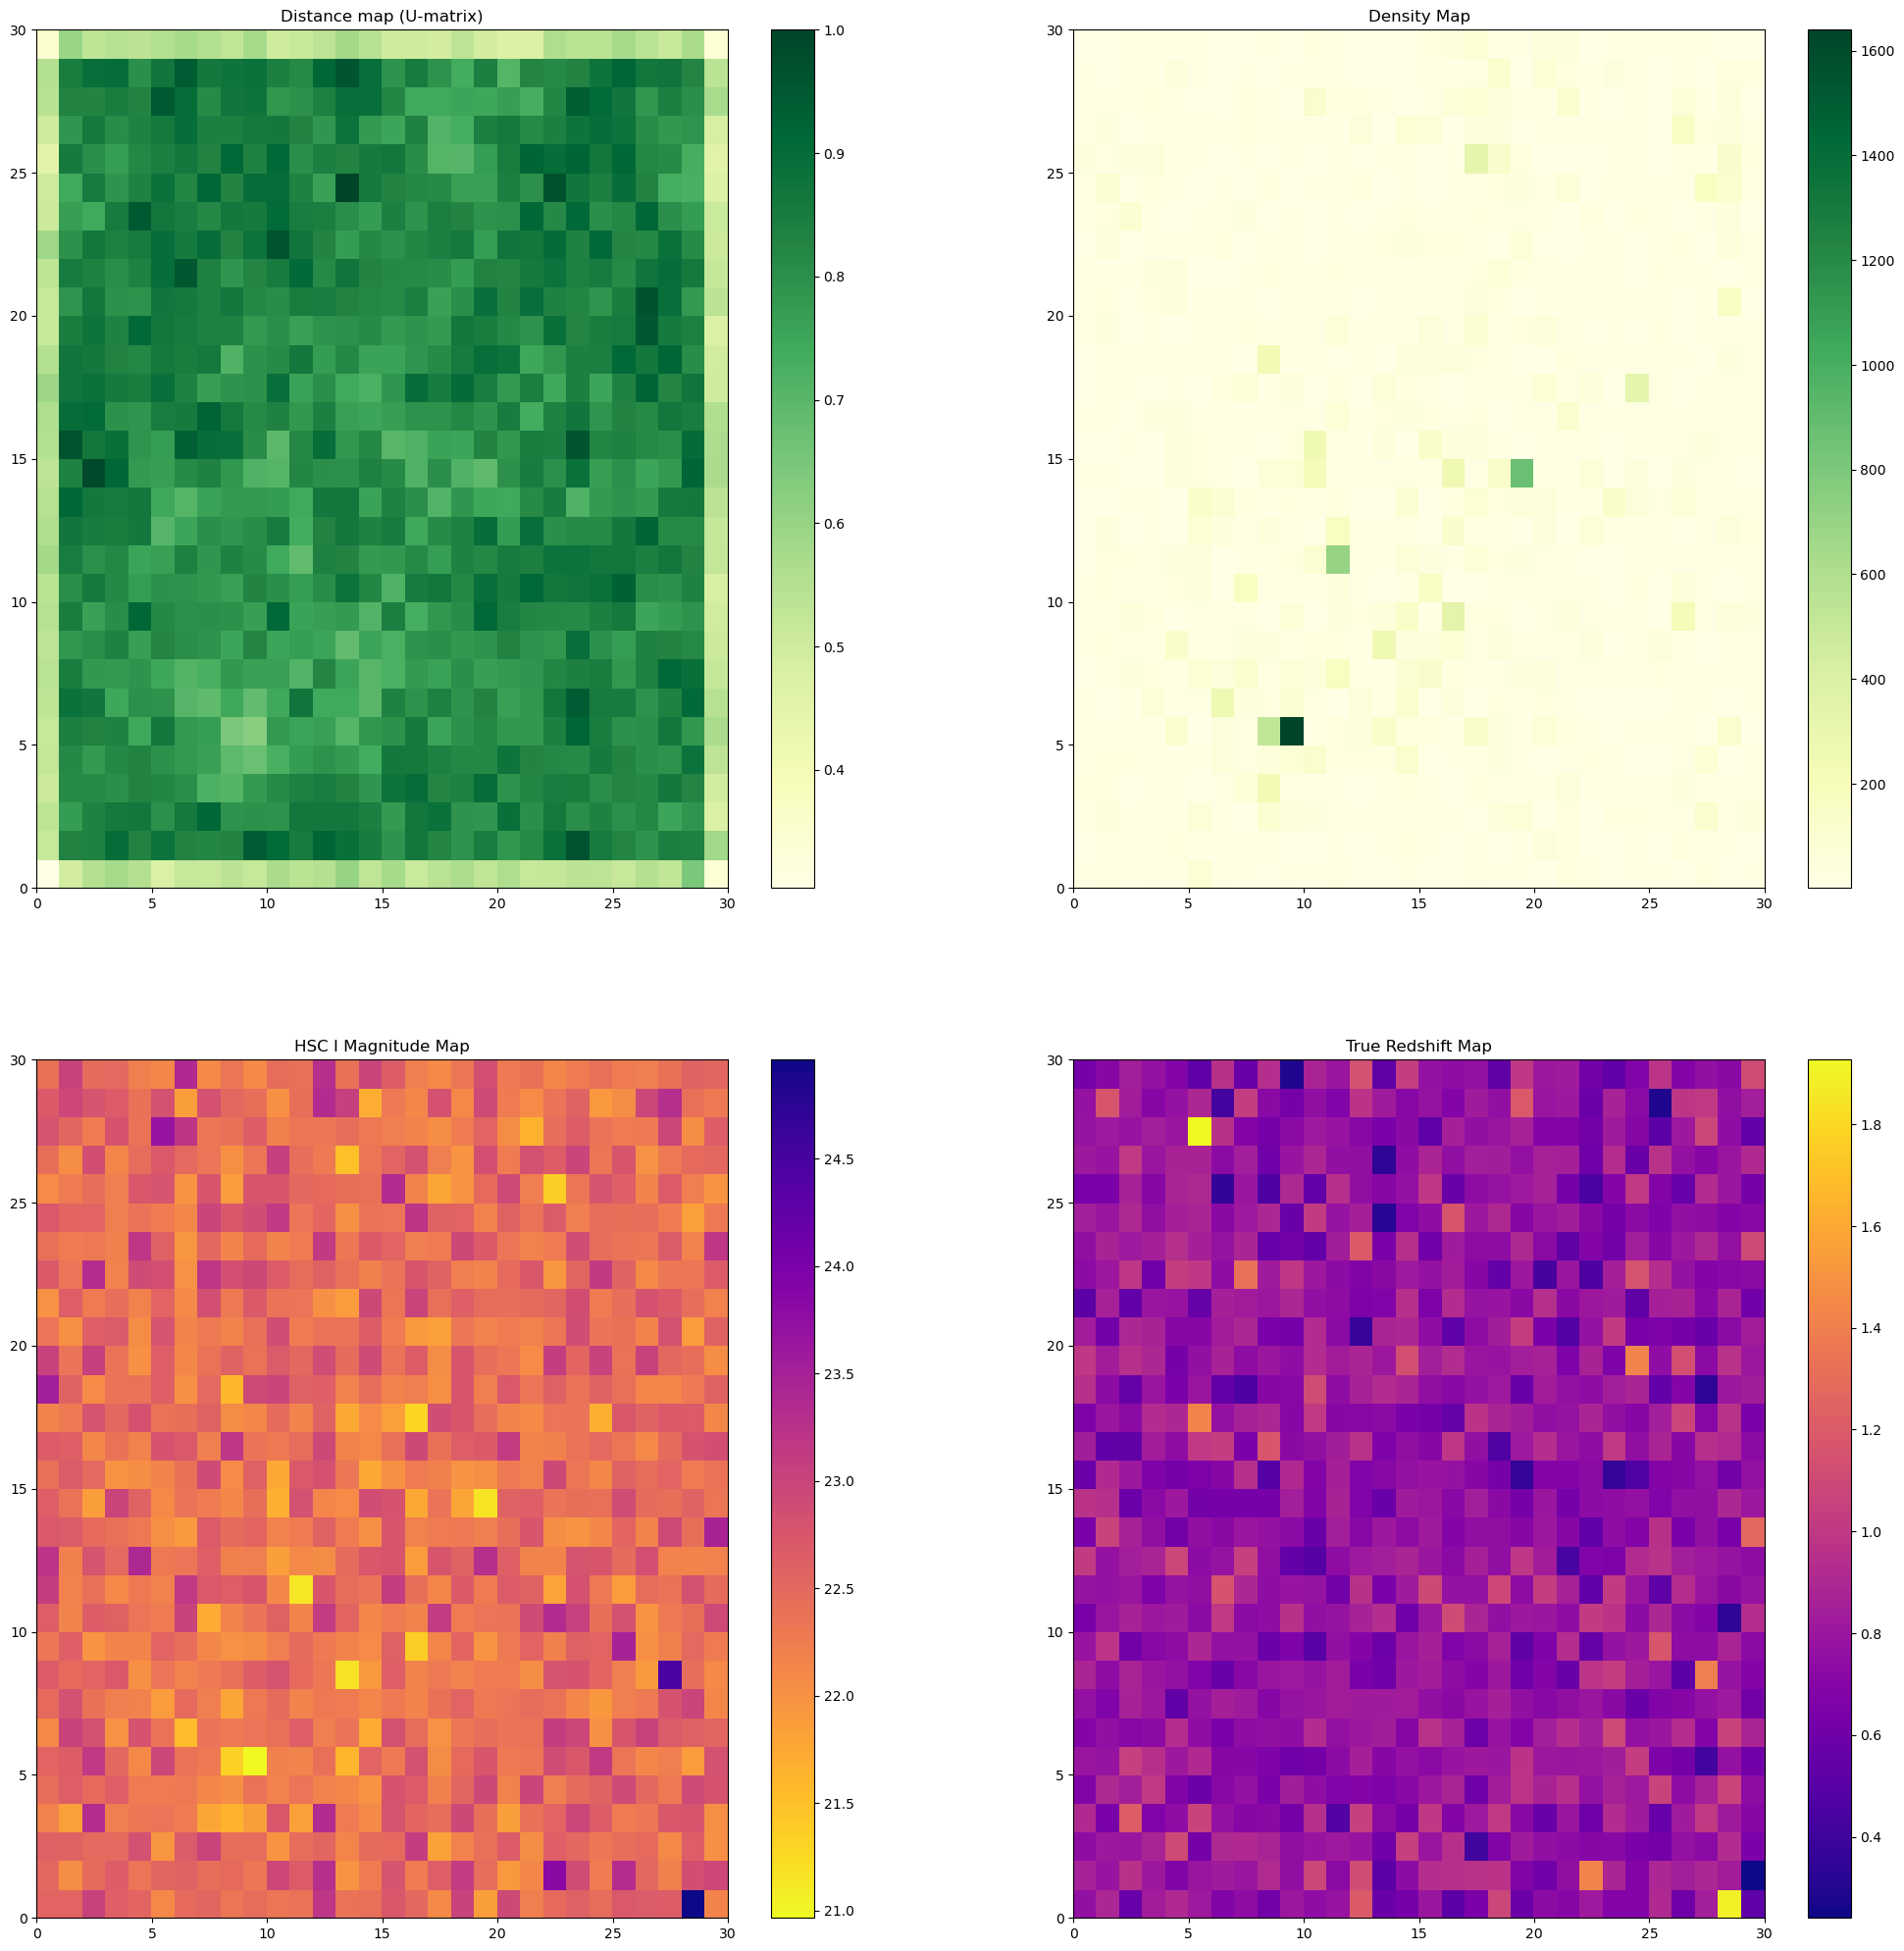

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 1.4]
Topological error: 0.9650641781491089
Quantization error: 9.683957461936767
29683.0


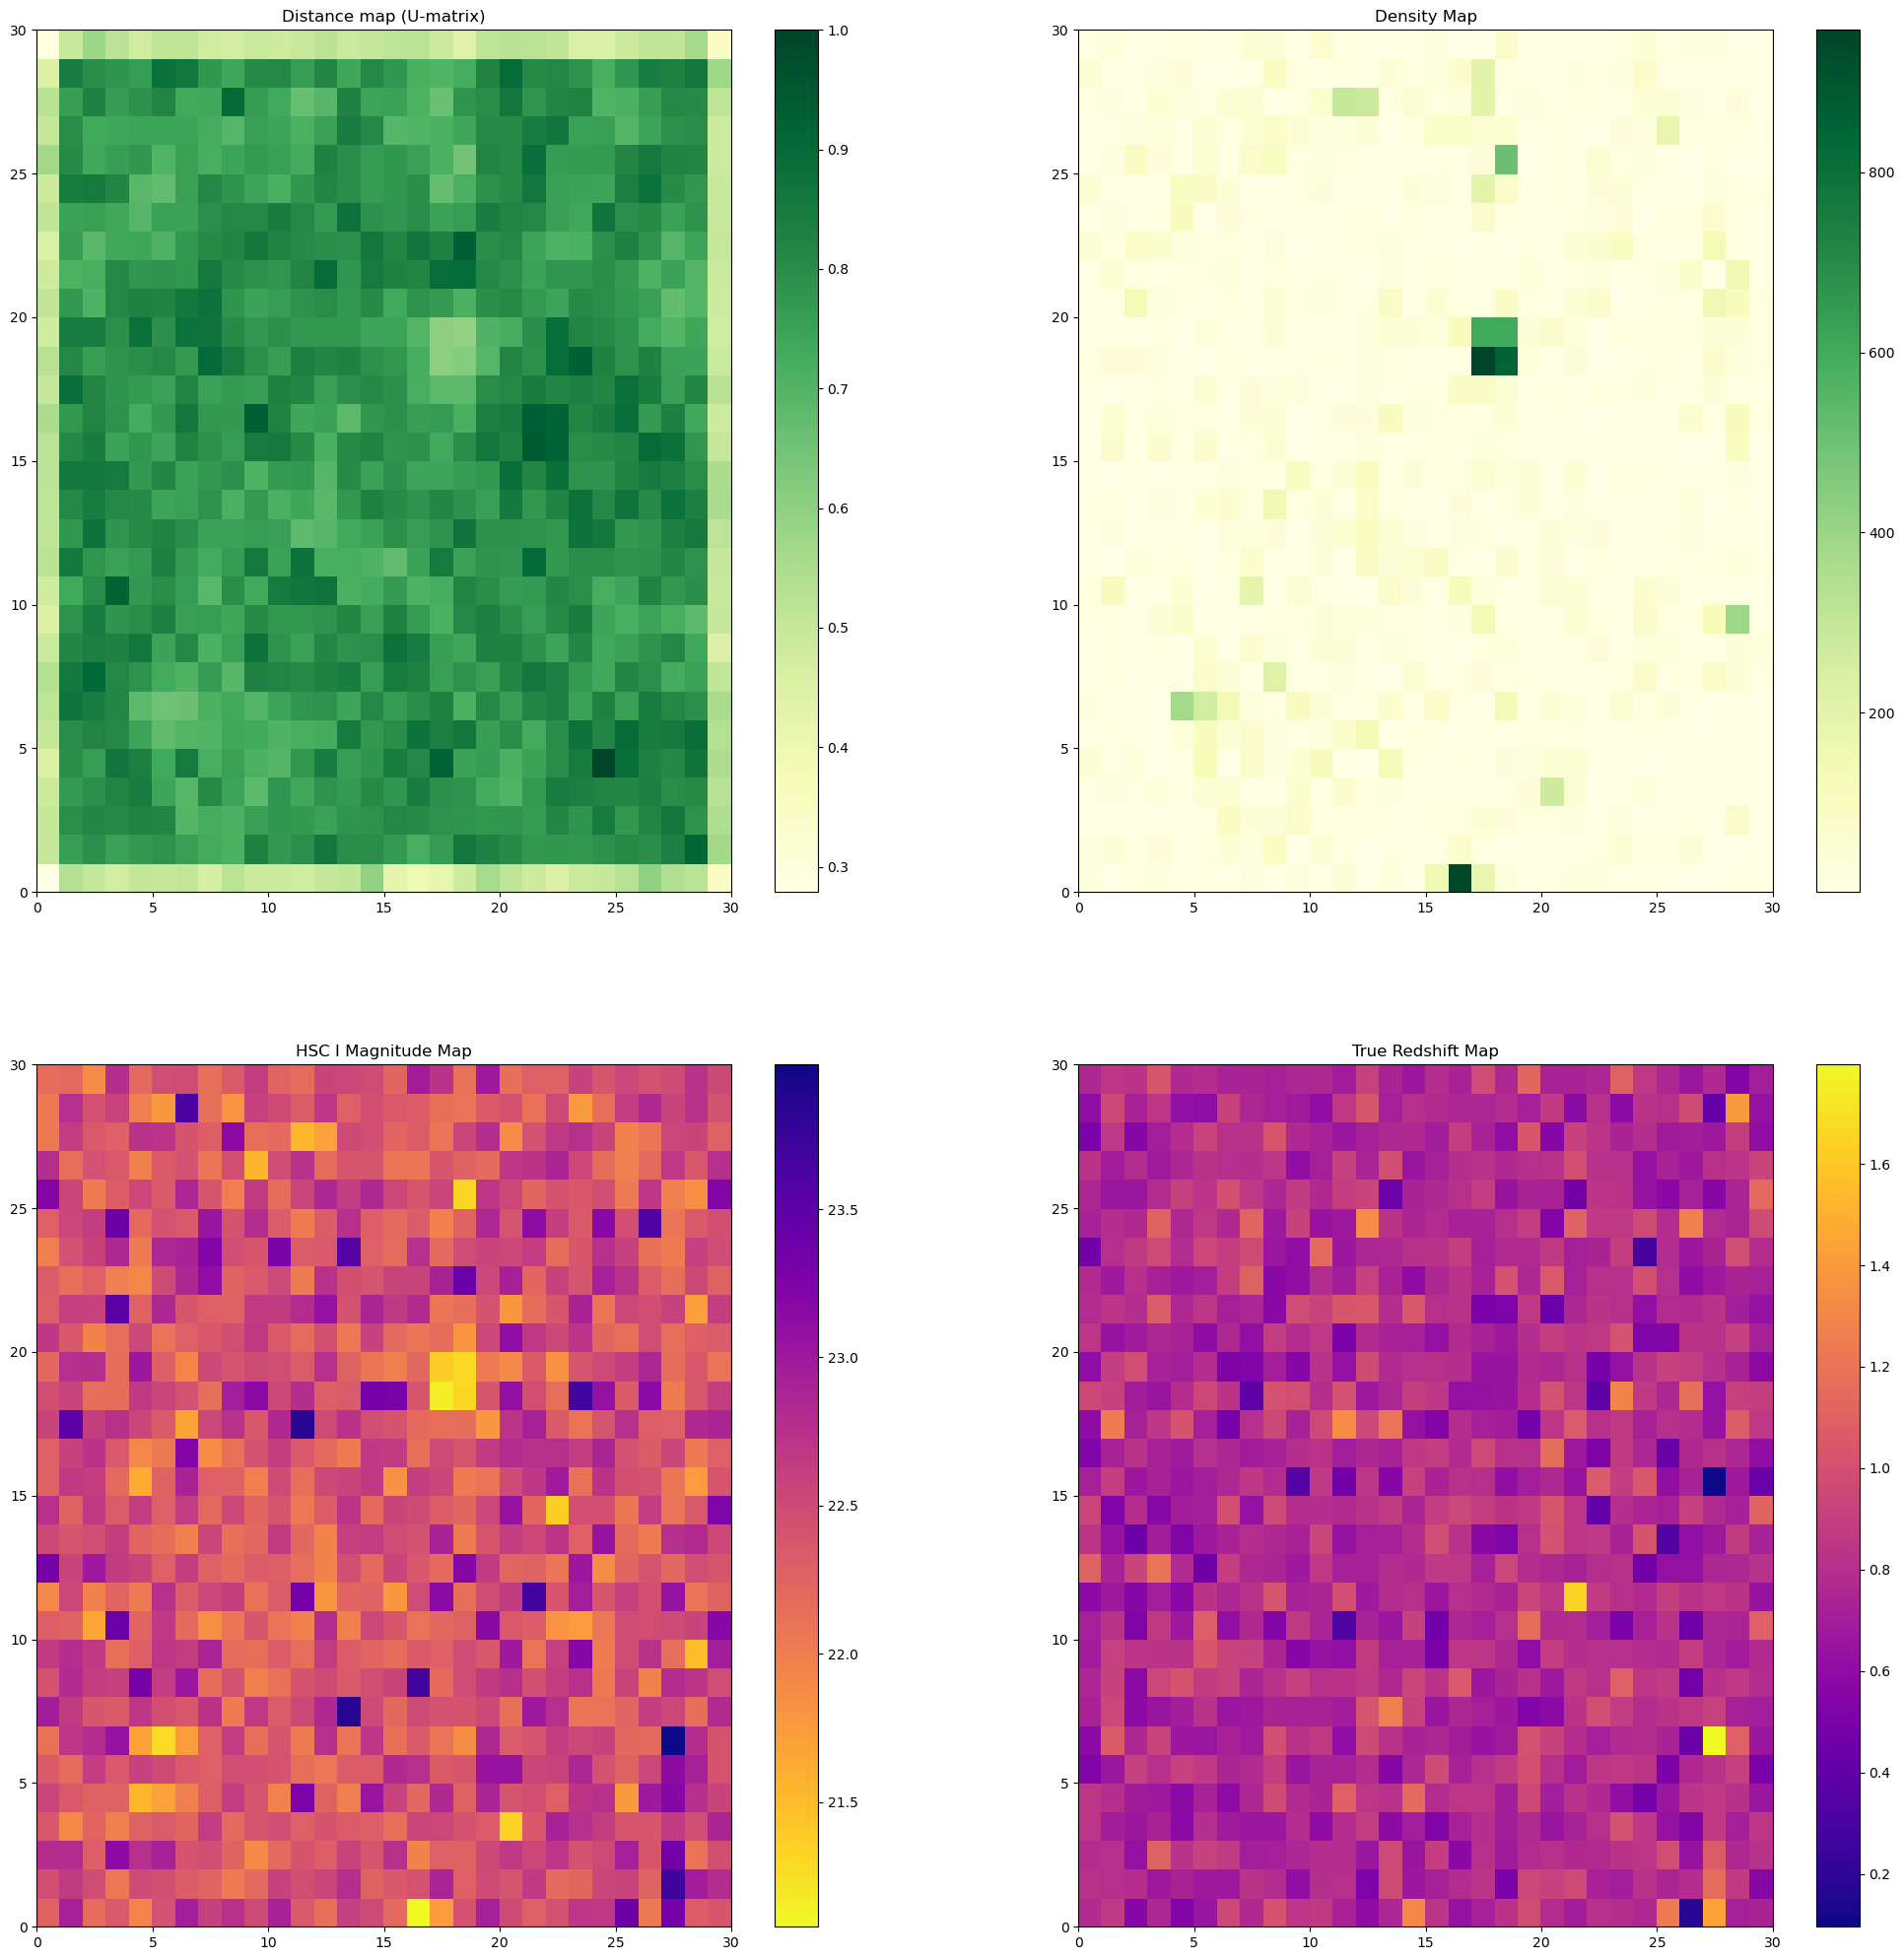

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 1.5]
Topological error: 0.9844355354916956
Quantization error: 9.774216533668598
29683.0


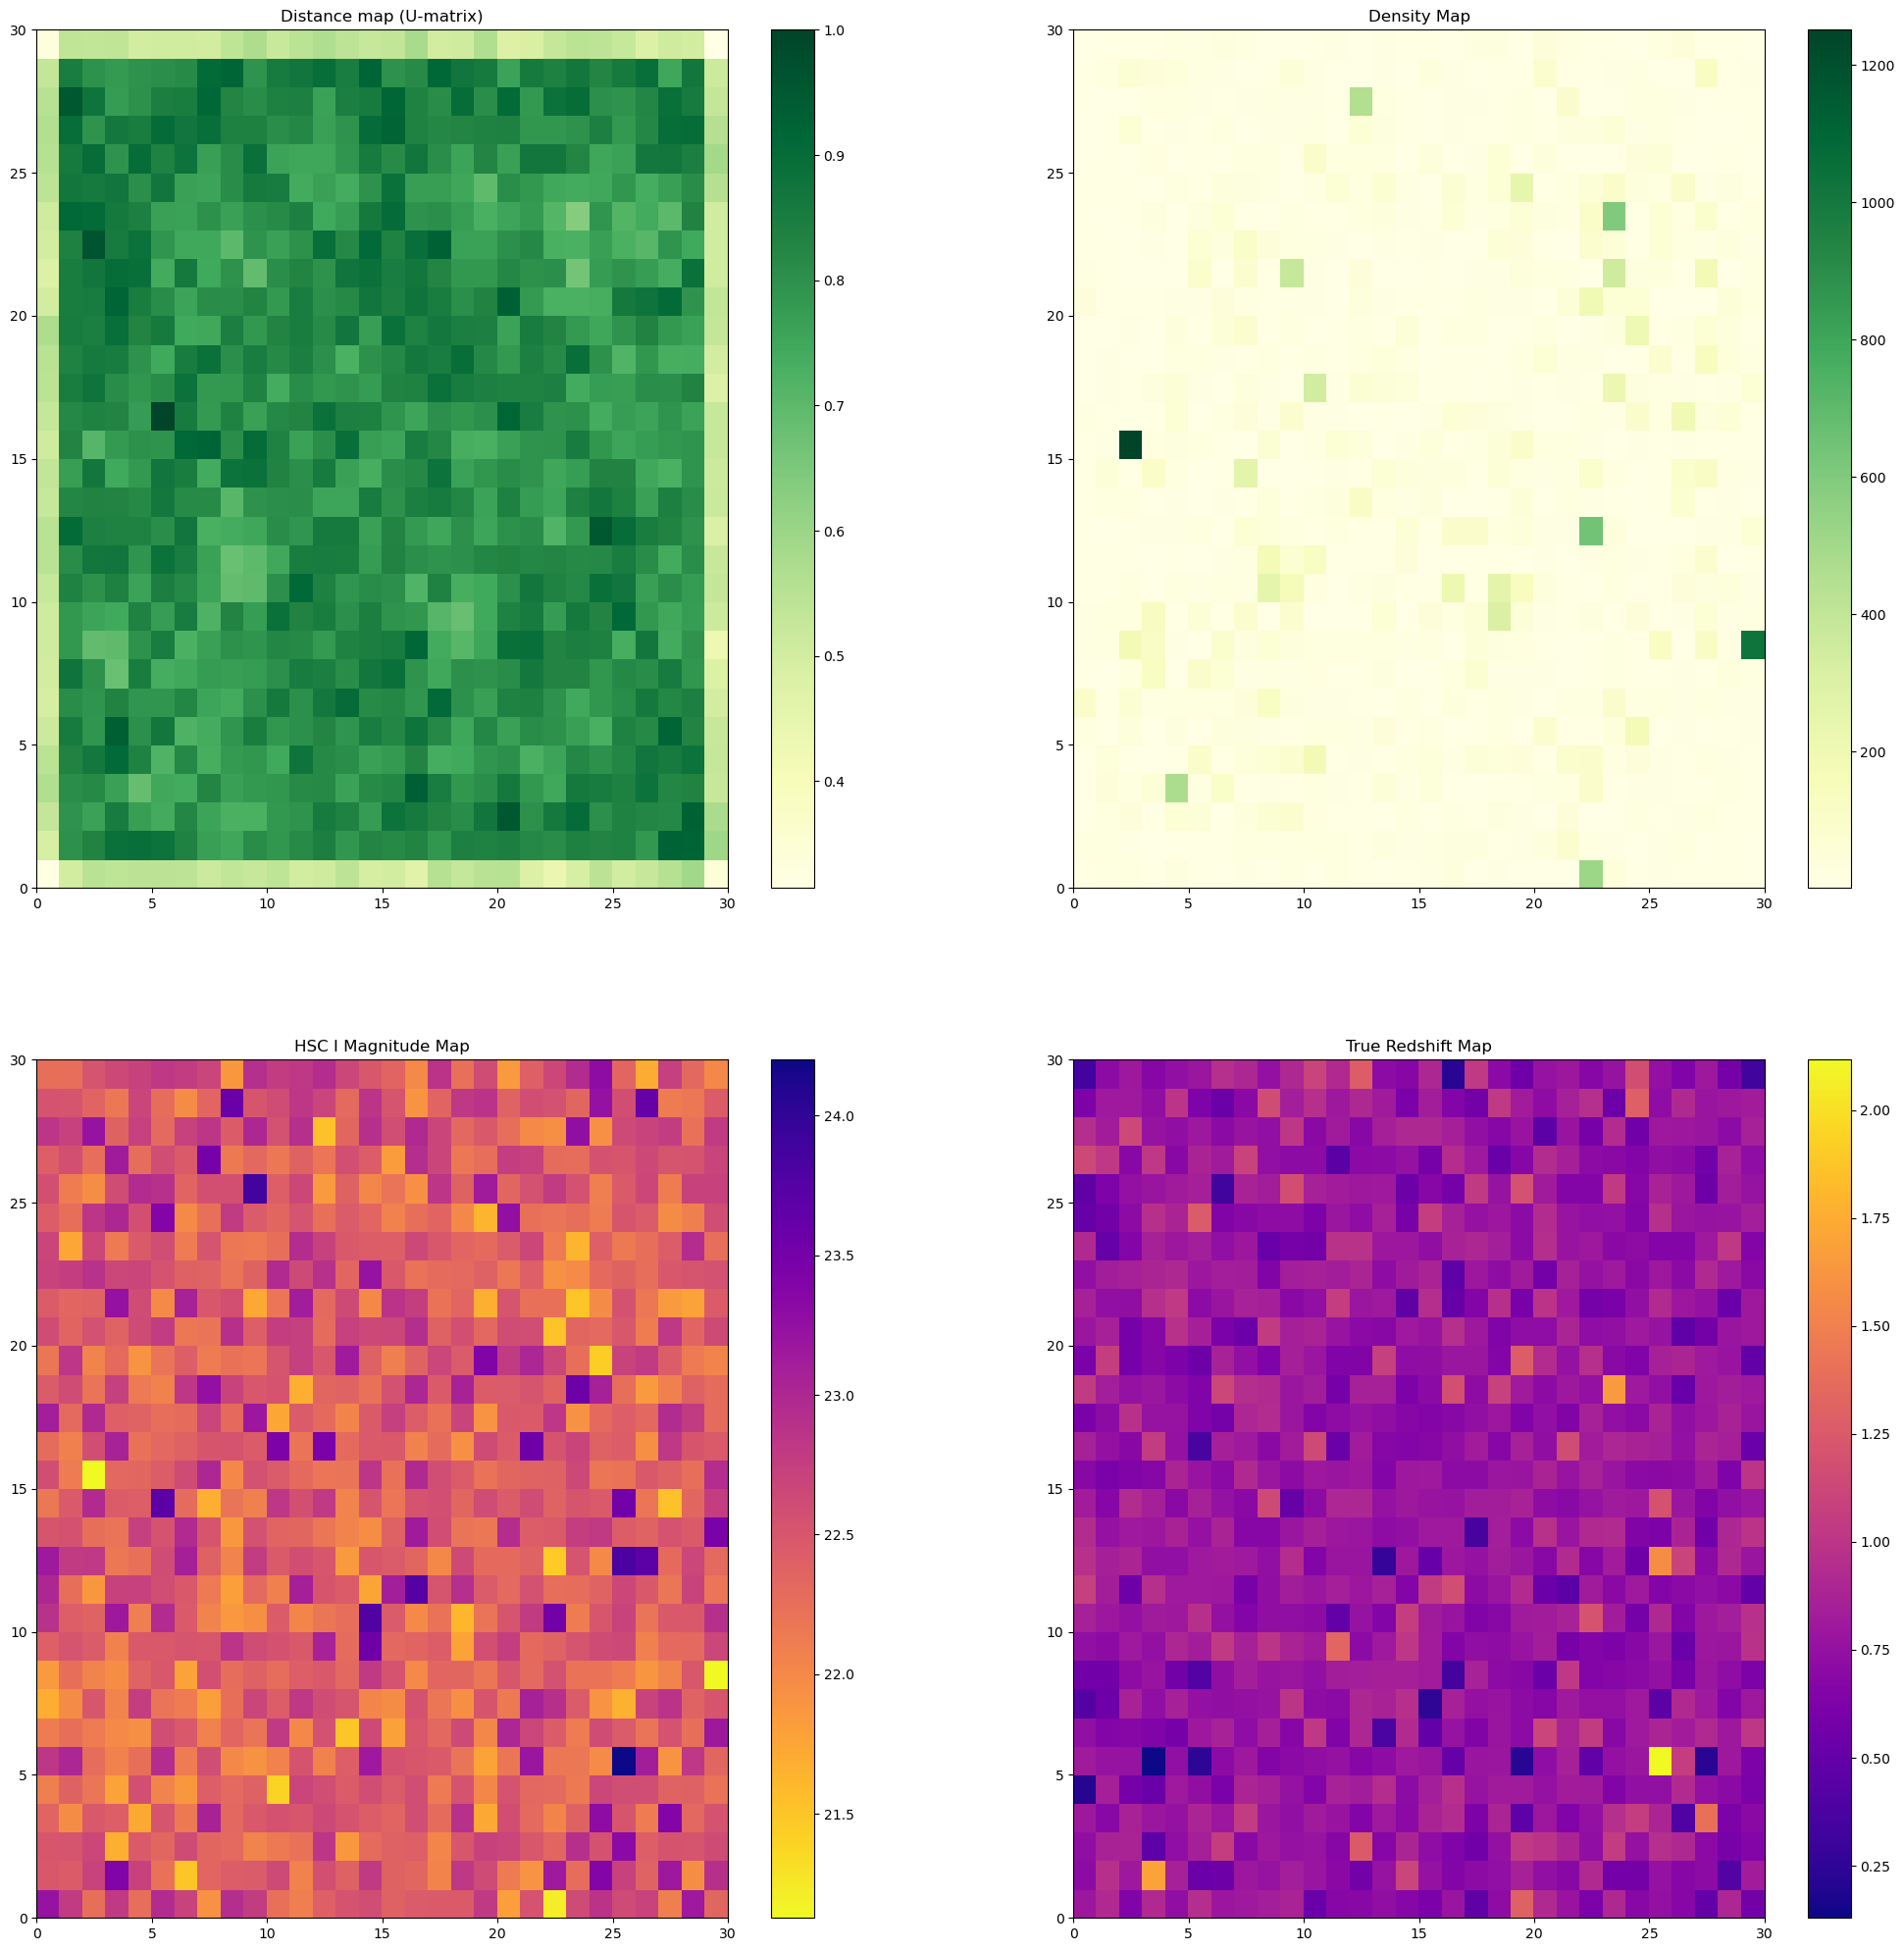

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 1.6]
Topological error: 0.9769228177744838
Quantization error: 9.877310188530346
29683.0


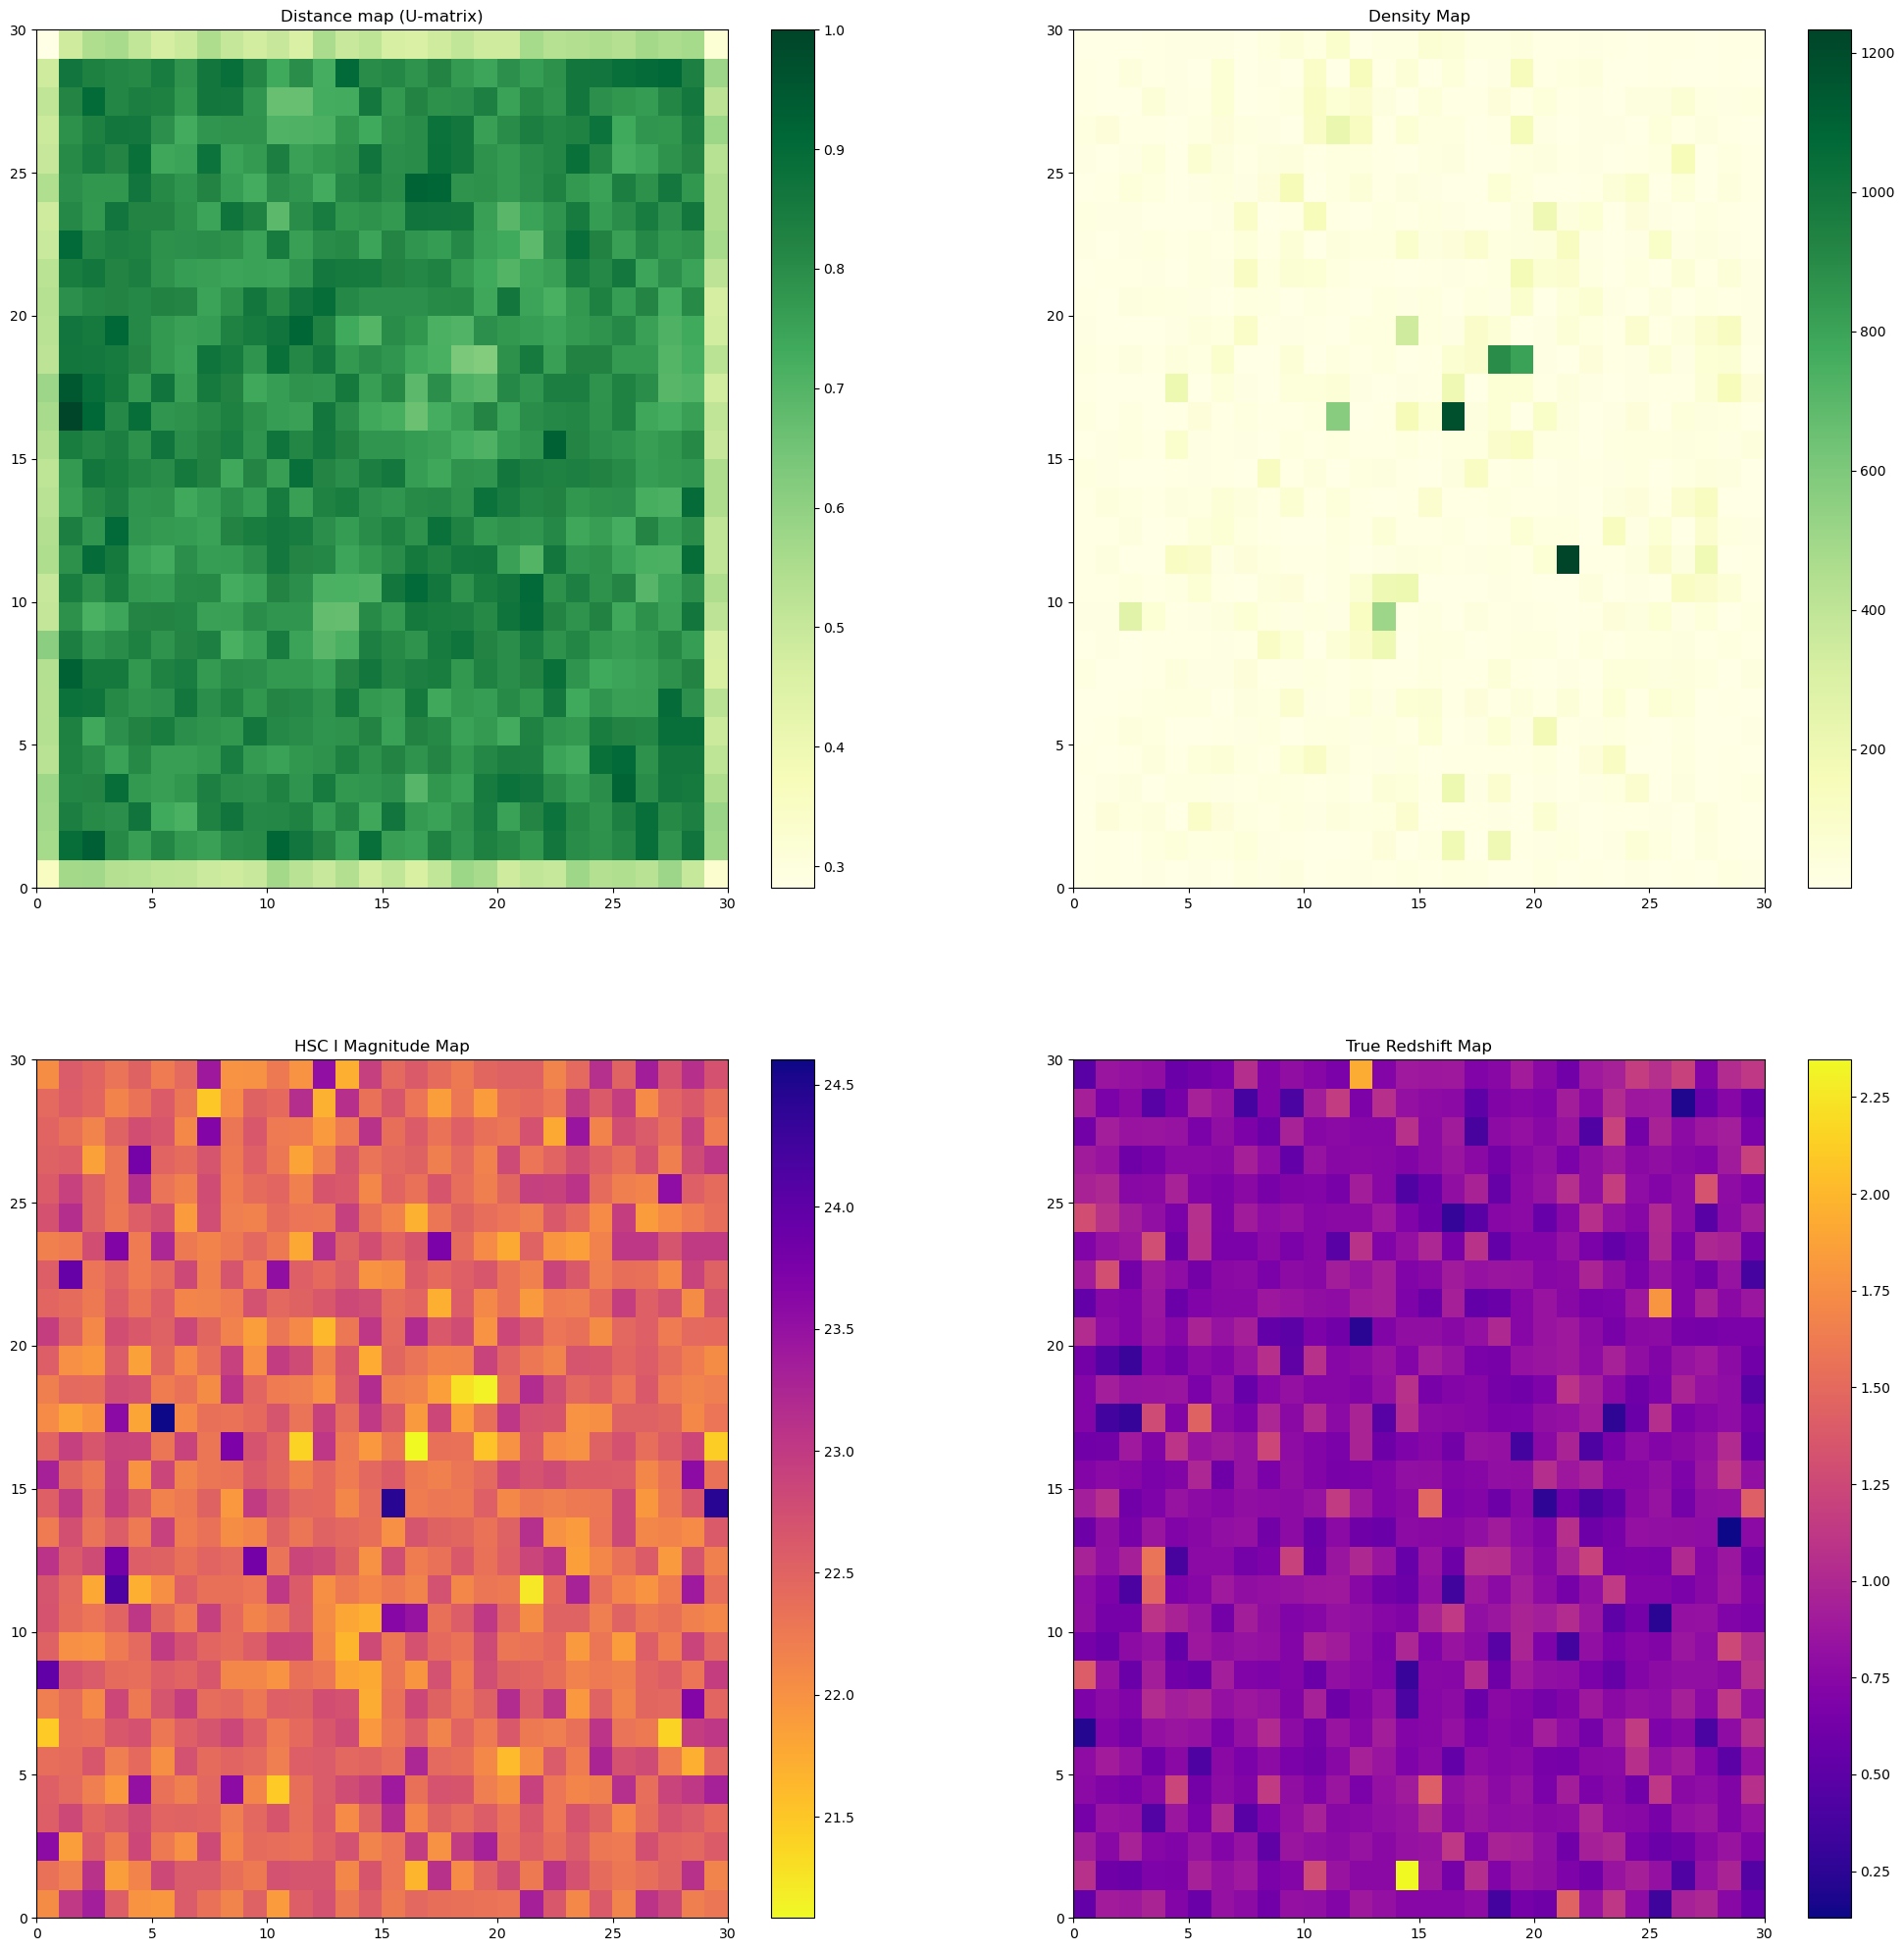

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 1.7]
Topological error: 0.9827510696358185
Quantization error: 9.98142560187669
29683.0


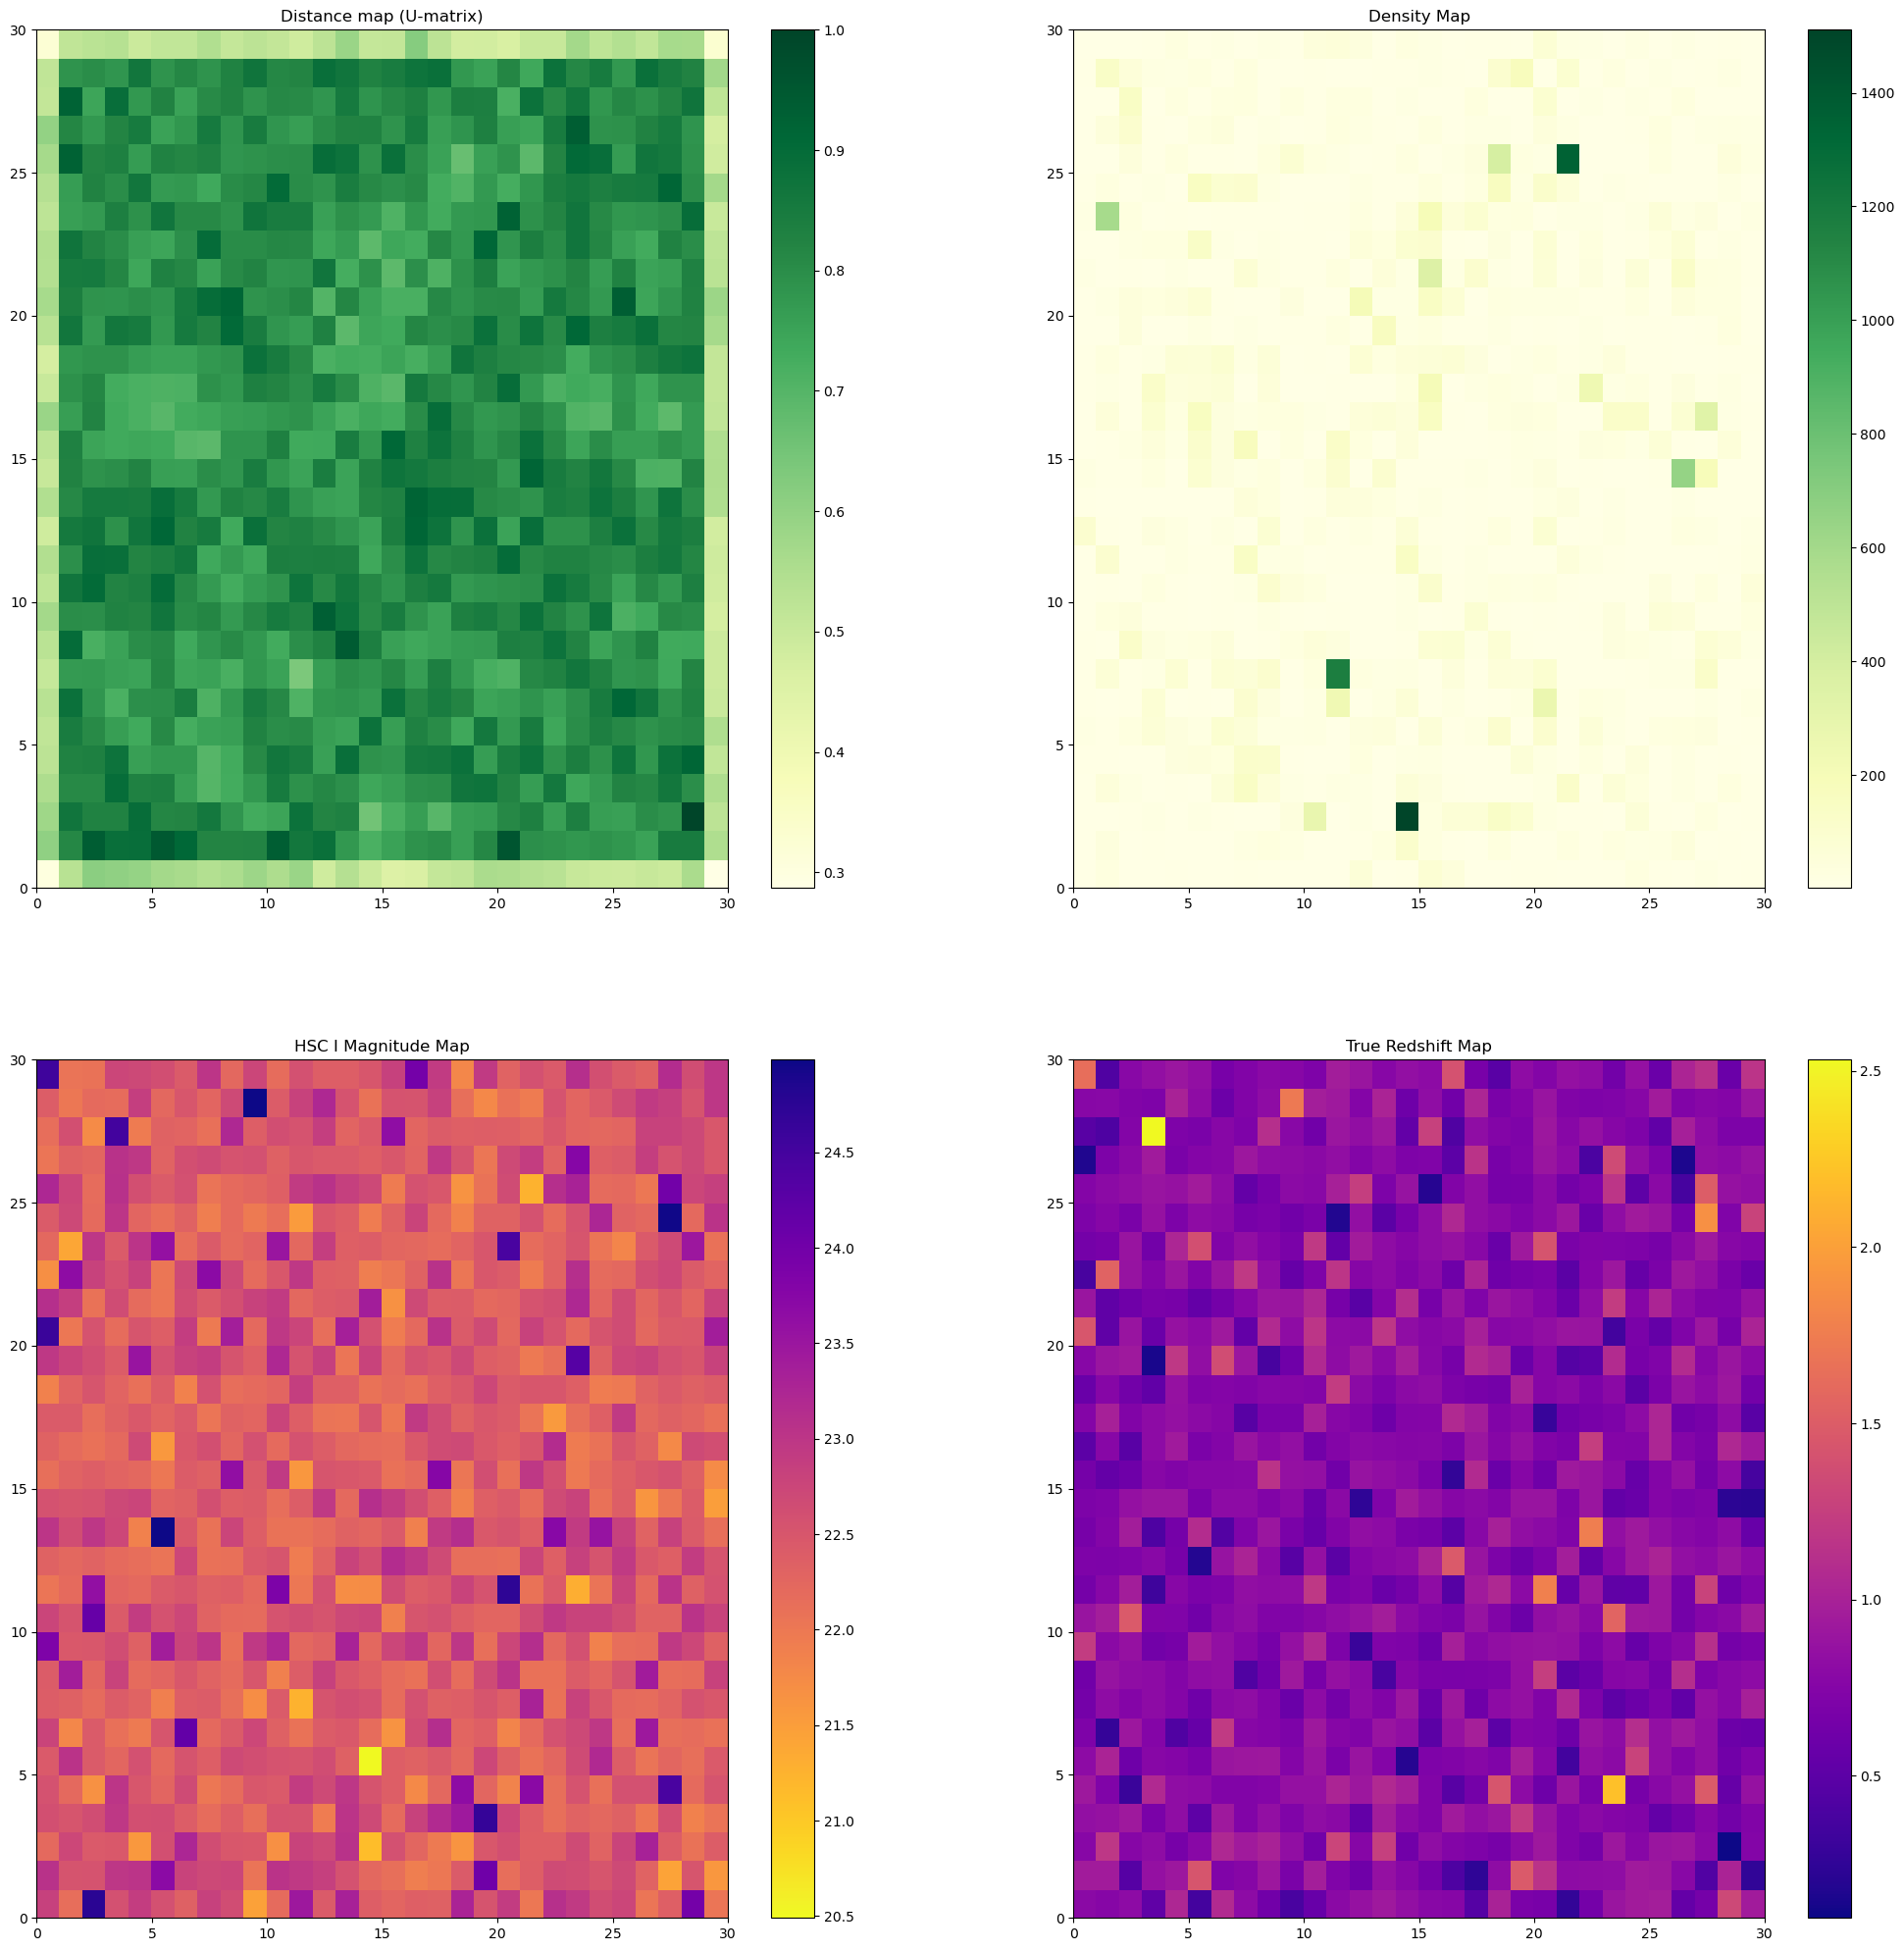

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 1.8]
Topological error: 0.9826836910015834
Quantization error: 10.065456524506363
29683.0


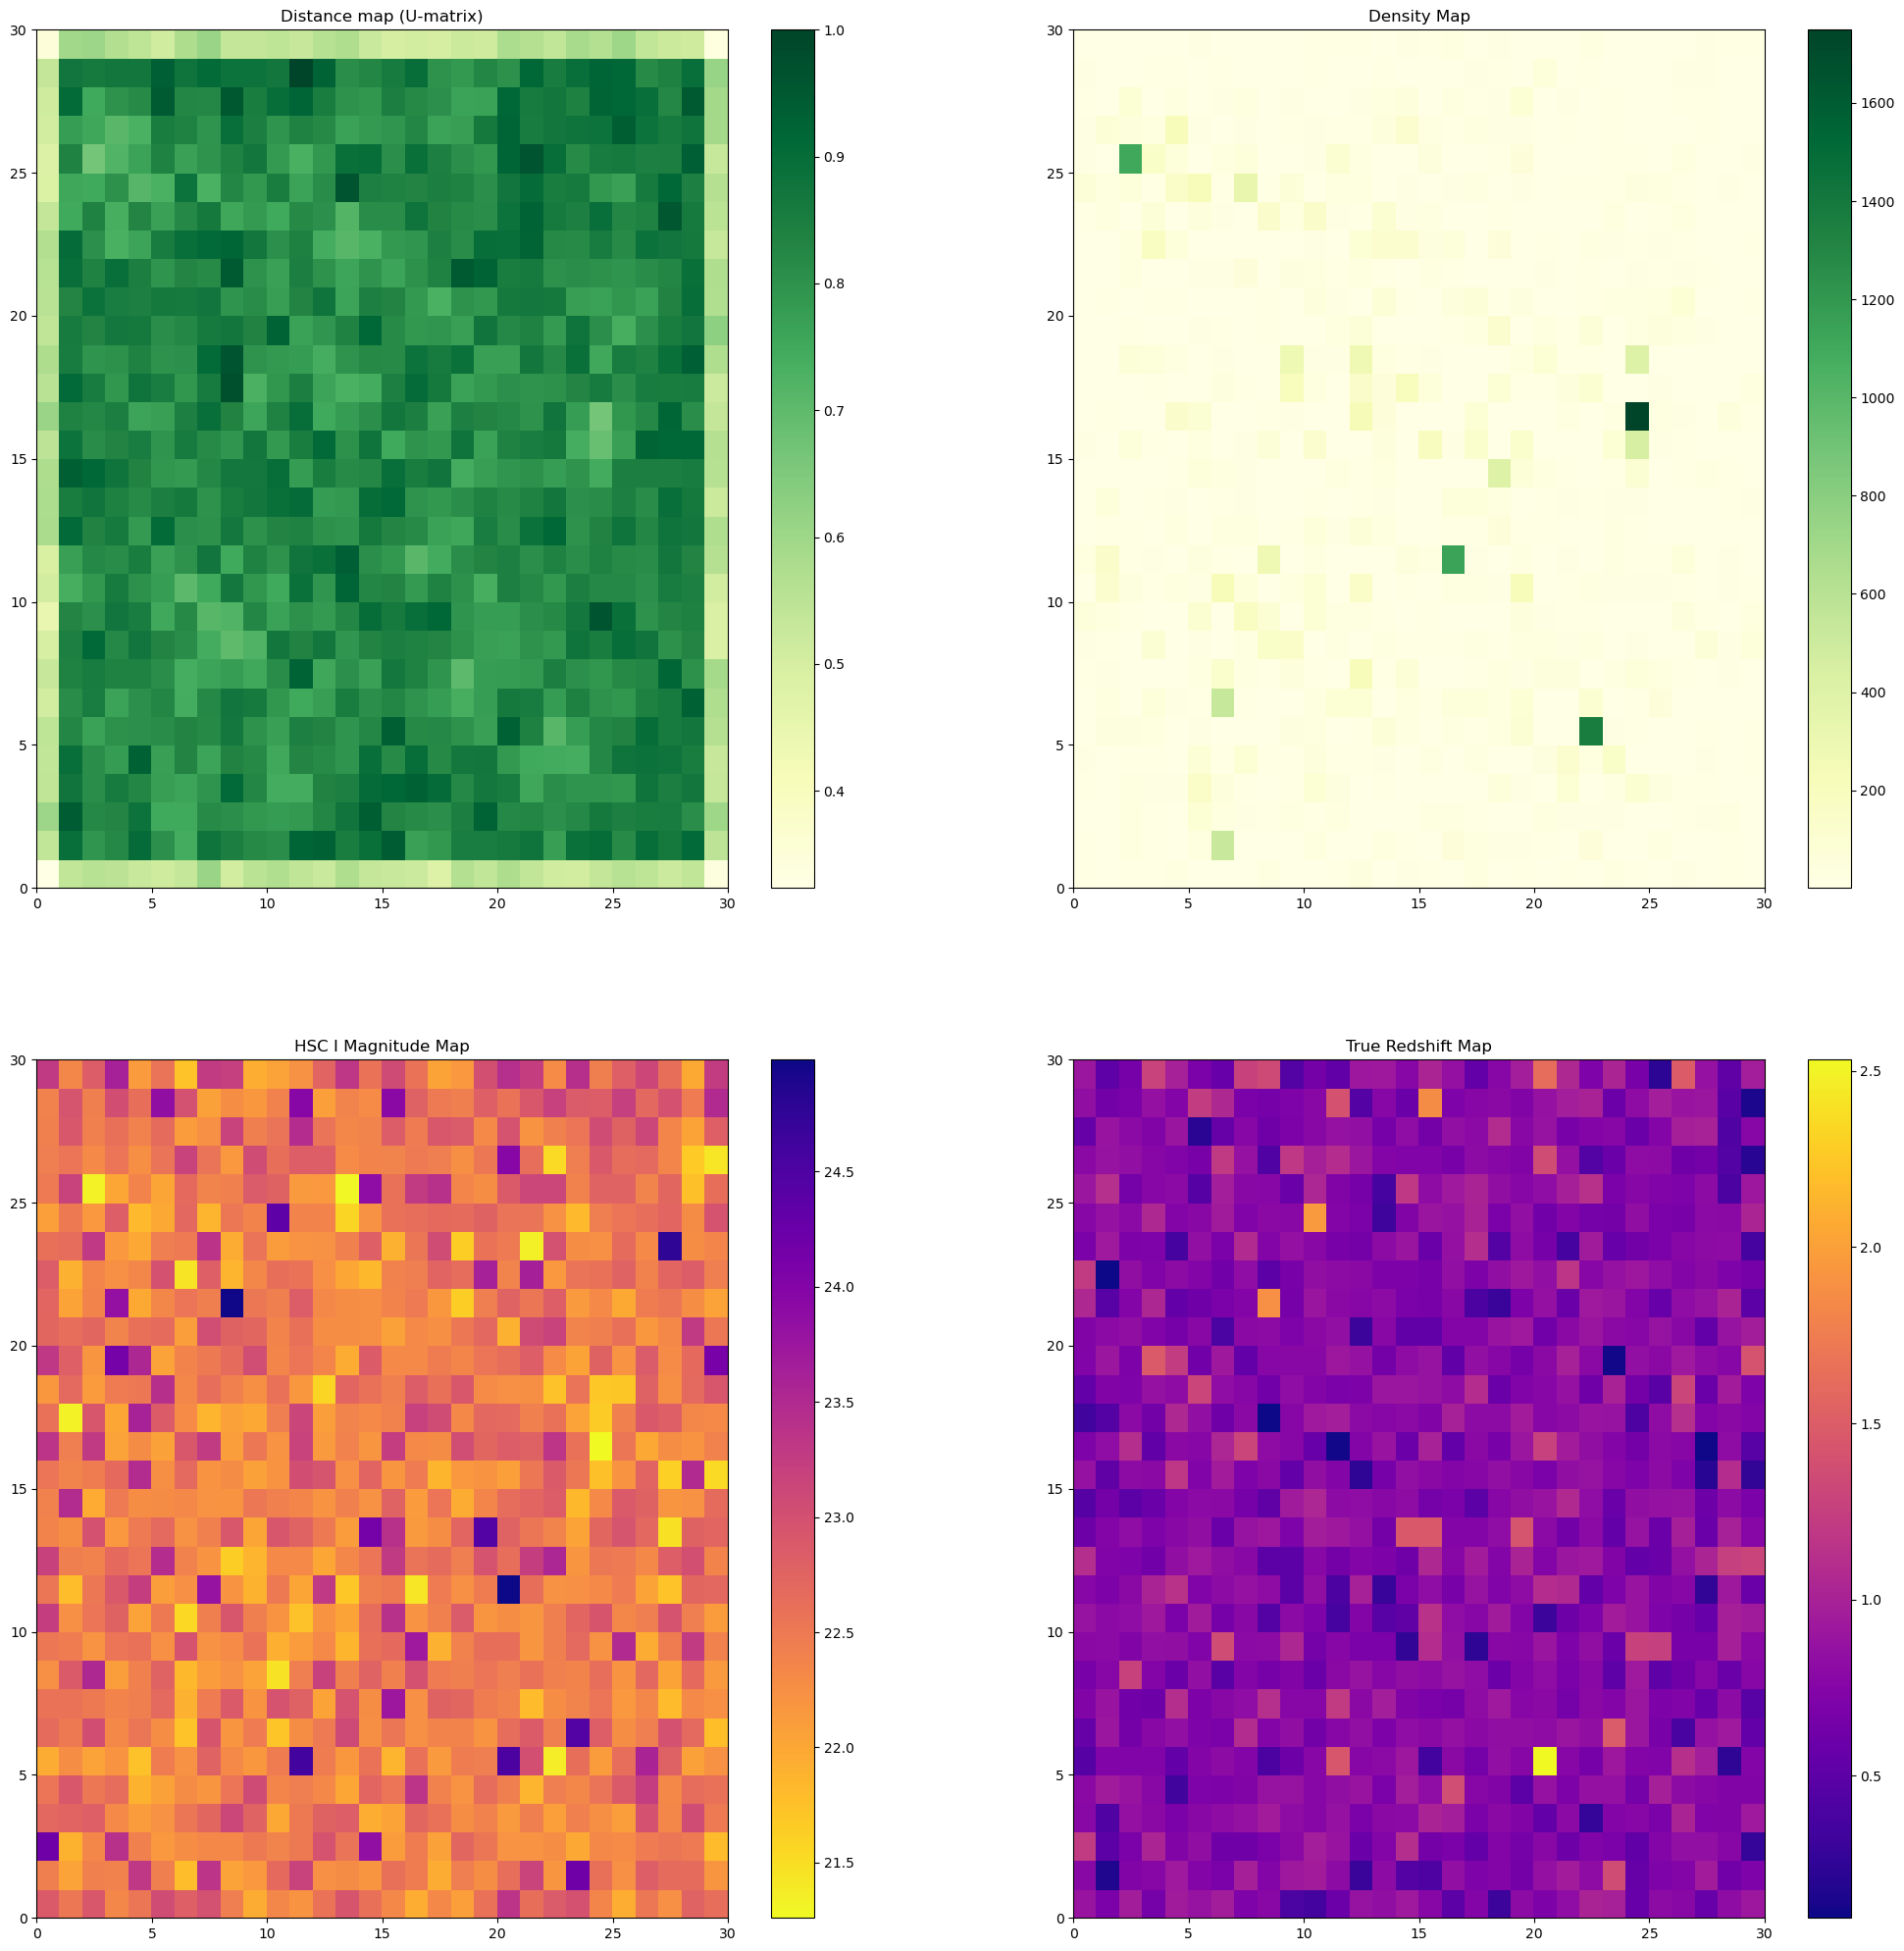

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 1.9]
Topological error: 0.9694437893743894
Quantization error: 10.178880661358777
29683.0


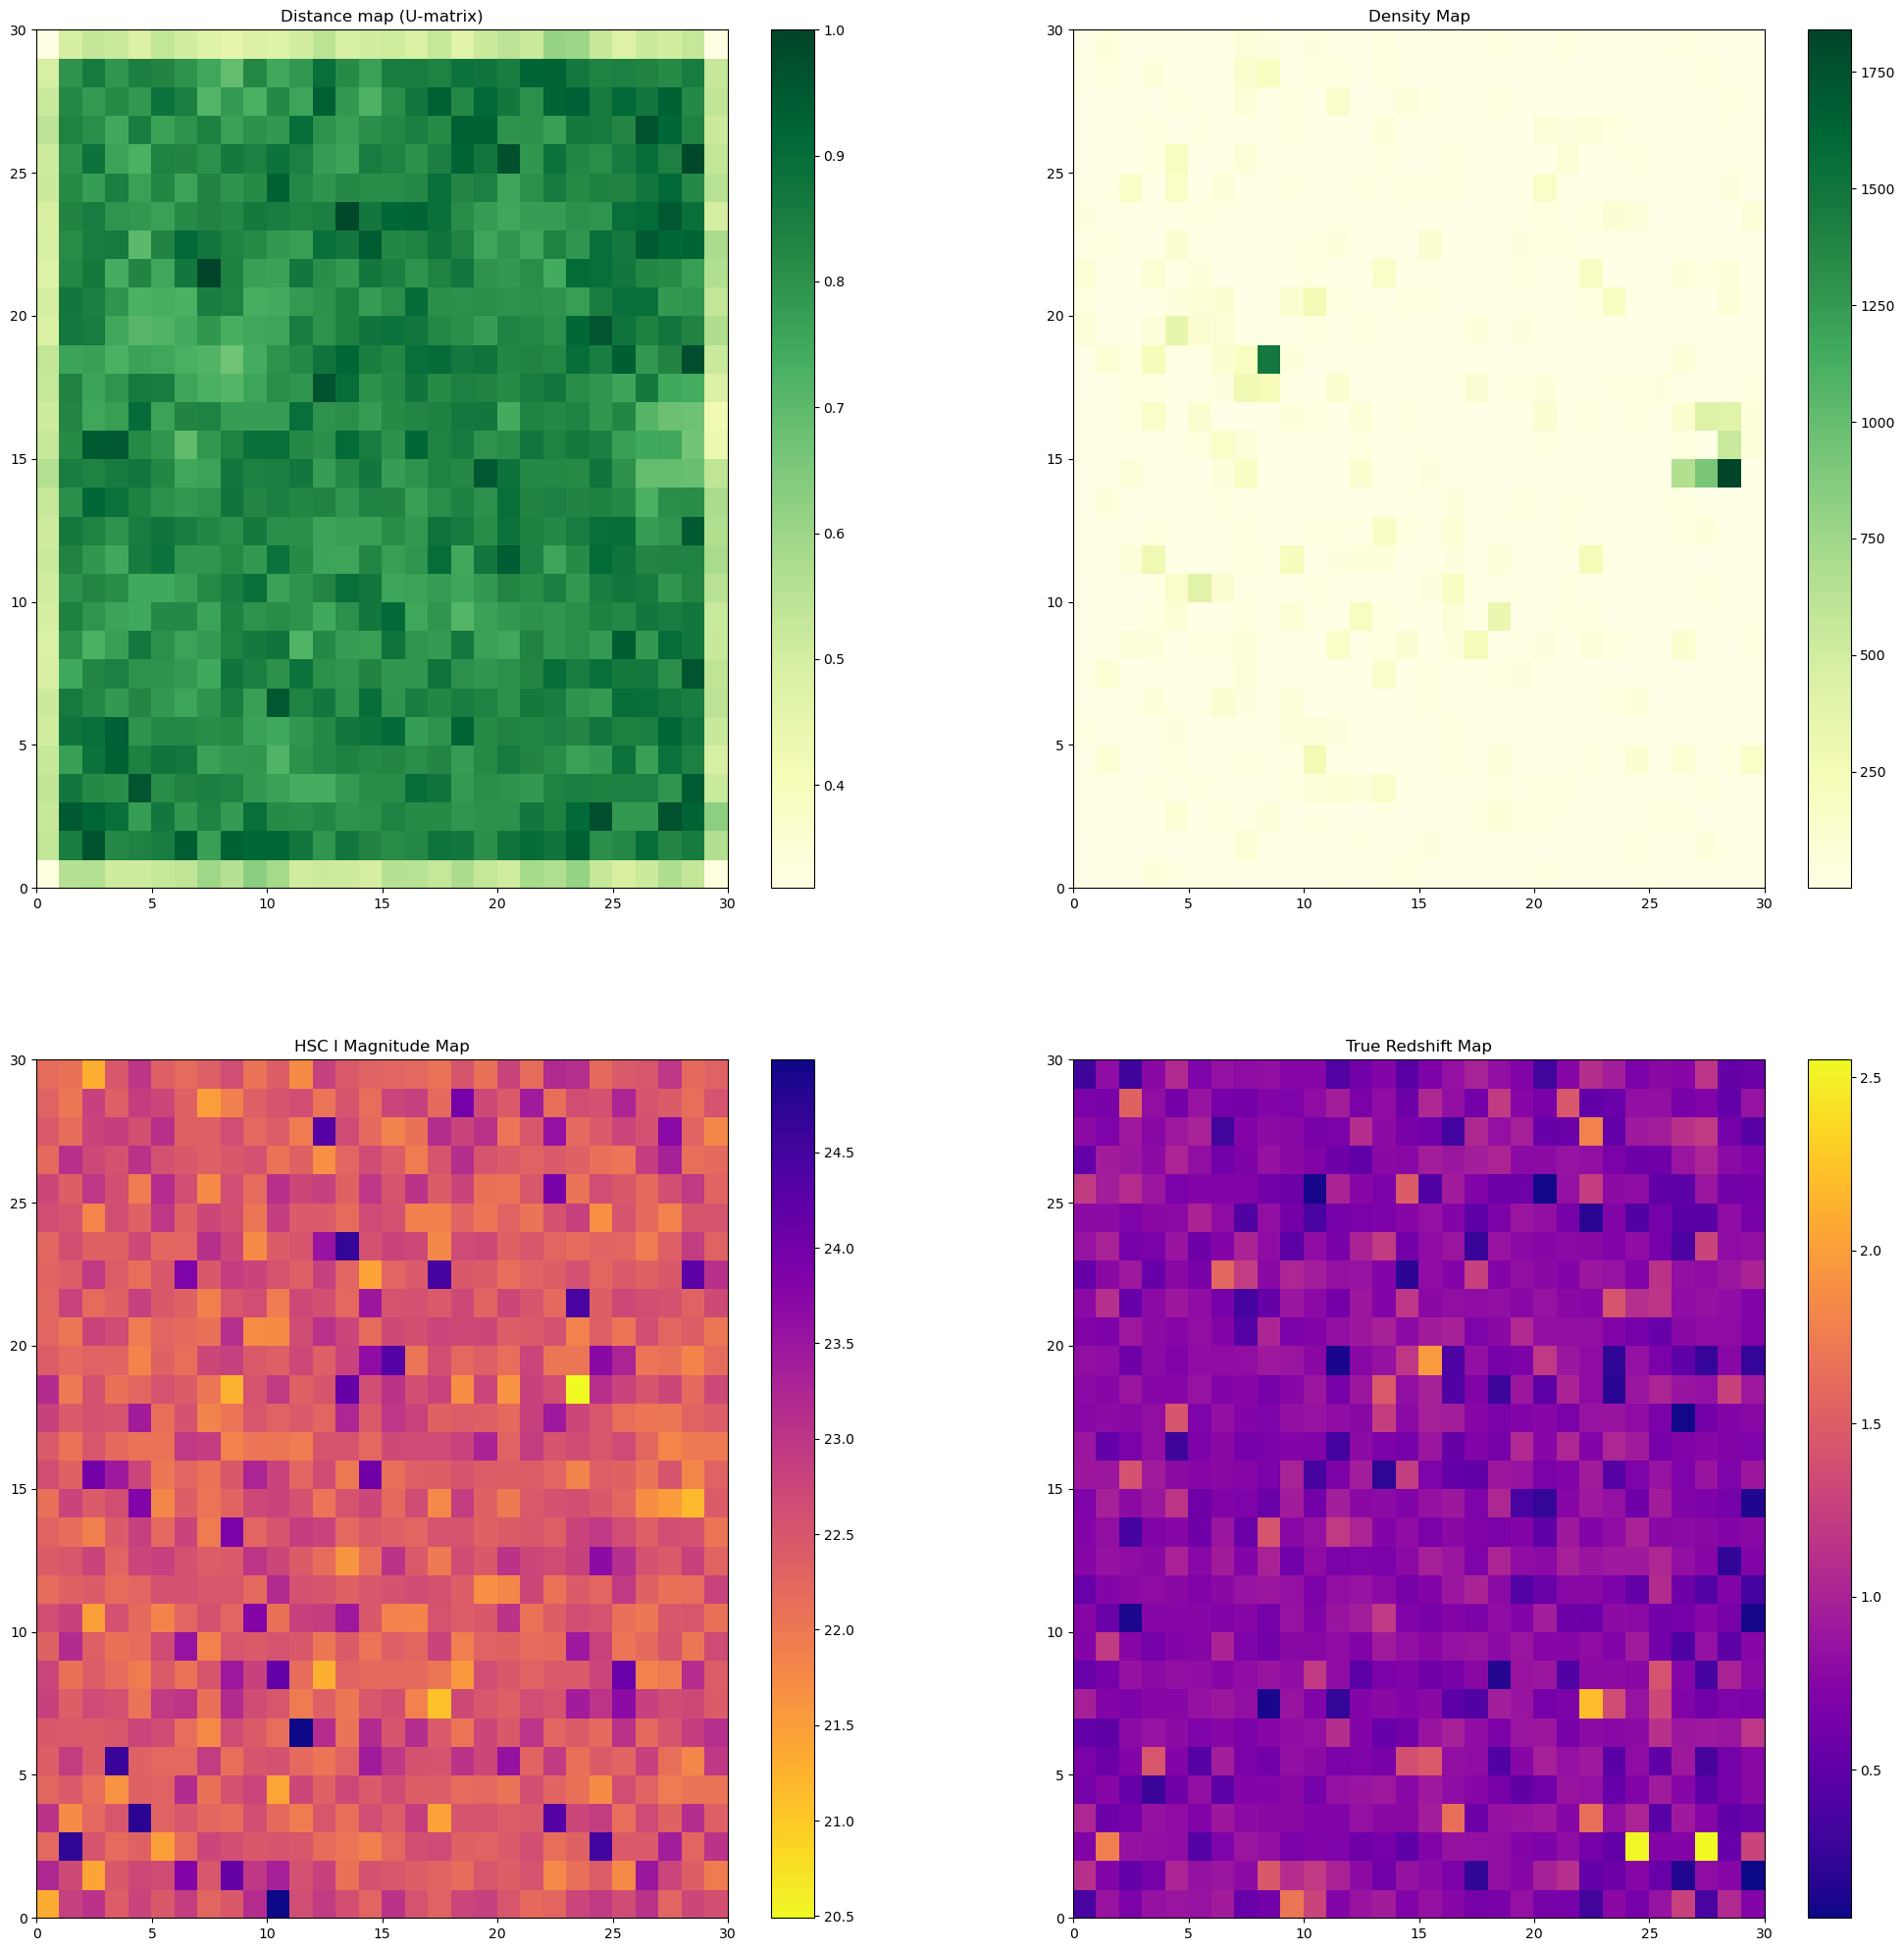

Data shape: (29683, 101)
Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[30, 0.8, 2.0]


D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:547: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Topological error: 0.973520196745612
Quantization error: 10.322569920779516
29683.0


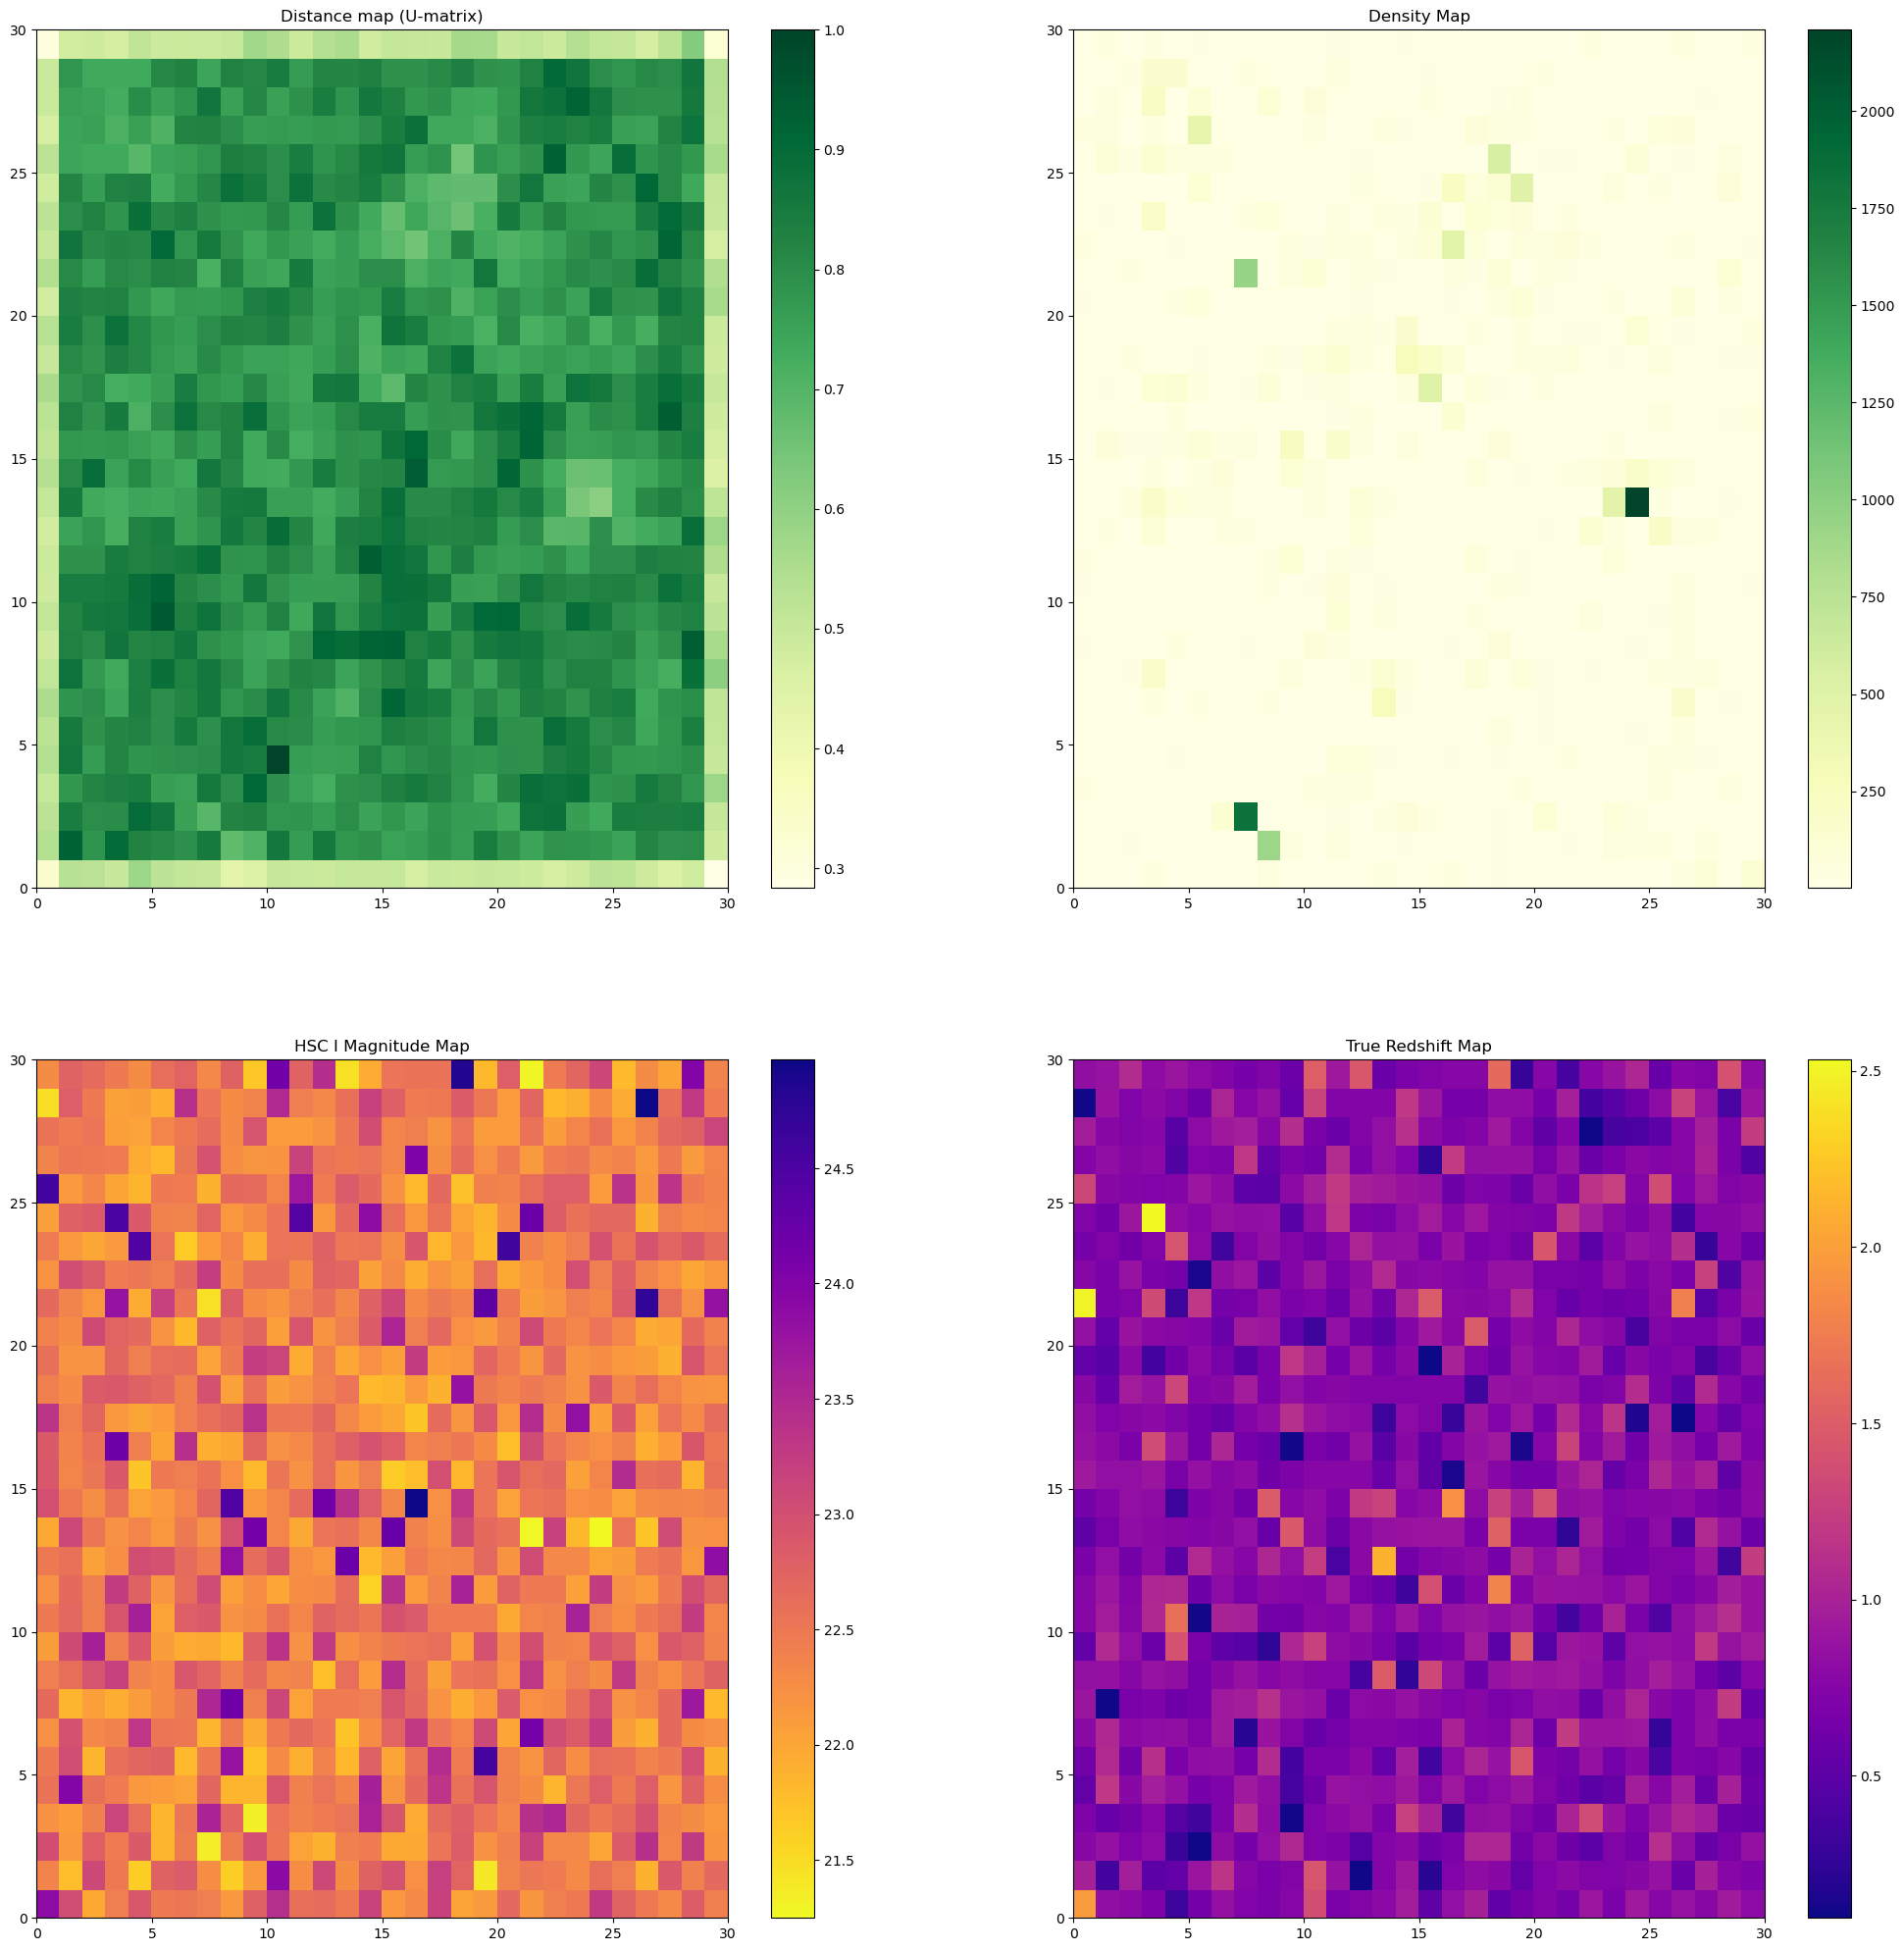

D:\miniconda\envs\SPHEREx_SOM\Lib\site-packages\minisom.py:547: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


In [8]:
for i in range(1, 21):
    som = basic_som(data = data, data_type = "noisy_lupcolor_shallow", err = err, info_data = info, dim = 30, preproc = "default", iteration = 2, sigma = 0.8, rate = i / 10, save = True, distance = "euclidean", save_record = True)